# Production Run 1 (new BC)

In [1]:
# Load the modules

# Add any possible locations of amr-wind-frontend here
amrwindfedirs = ['/projects/wind_uq/lcheung/amrwind-frontend/',
                 '/ccs/proj/cfd162/lcheung/amrwind-frontend/']
import sys, os, shutil
for x in amrwindfedirs: sys.path.insert(1, x)
import MMCutil as writeMMC
import postproamrwindsample_xarray as ppsamplexr

# Load the libraries
import numpy as np
import pandas as pd
import re
import utm
import amrwind_frontend as amrwind
import matplotlib.pyplot    as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.interpolate import CubicSpline

# Also ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Make all plots inline 
%matplotlib inline

/ascldap/users/lcheung/.local/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/ascldap/users/lcheung/.local/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


## Set up measurement coordinates

In [2]:
def dms2dec(lat):
    deg, minutes, seconds, direction =  re.split('[°\'"]', lat.strip())
    return (float(deg) + float(minutes)/60 + float(seconds)/(60*60)) * (-1 if direction in ['W', 'S'] else 1)

In [3]:
# Get the UTM coordinates of all measurement locations
mdict = {
    'siteA1':{'lat':dms2dec("""36°21'43.6"N"""), 'long':dms2dec("""97°24'16.4"W""")},
    'siteA2':{'lat':dms2dec("""36°19'05.5"N"""), 'long':dms2dec("""97°24'32.7"W""")},
    'siteA5':{'lat':dms2dec("""36°21'42.5"N"""), 'long':dms2dec("""97°22'53.8"W""")},
    'siteB':  {'lat':dms2dec("""36°13'54.4"N"""), 'long':dms2dec("""97°33'31.2"W""")},
    'siteE36':{'lat':dms2dec("""36°07'01.0"N"""), 'long':dms2dec("""97°30'39.2"W""")},
    'siteC1a': {'lat':dms2dec("""36°21'41.8"N"""), 'long':dms2dec("""97°30'36.1"W""")},
    'siteG':{'lat':dms2dec("""36°23'58.1"N"""), 'long':dms2dec("""97°24'28.9"W""")},
    'siteGC':{'lat':dms2dec("""36°22'47.09"N"""), 'long':dms2dec("""97°31'24.51"W""")},
    'siteH':{'lat':dms2dec("""36°26'12.7"N"""), 'long':dms2dec("""97°24'27.9"W""")},
    'turbE06':{'lat':dms2dec("""36°24'39.708"N"""), 'long':dms2dec("""97°24'21.24"W""")},
}

# Convert to UTM coordinates
for k,g in mdict.items():
    g['utm']  = utm.from_latlon(g['lat'], g['long'])
    g['utmx'] = g['utm'][0]
    g['utmy'] = g['utm'][1]

In [4]:
inputfile = 'FarmRun2.inp'
runOnSummit = False
rundir = 'BM2_FarmRunProd1newBC'

# Go to the run directory

# Delete any existing directory
if os.path.exists(rundir):
    shutil.rmtree(rundir)

# create a new version
os.makedirs(rundir)

cwd = os.getcwd()
os.chdir(rundir)

In [5]:
# Start the AMR-Wind case
case = amrwind.MyApp.init_nogui()

In [6]:
# Location of precursor run with boundary data
#summitprecursordir = '/gpfs/alpine2/cli187/world-shared/lcheung/AWAKEN/Benchmark1/Phase1/MMC_BM1_BigPrecursor.prod/'

#precursordir  = '/gpfs/lcheung/AWAKEN/Benchmark1/Phase2/MMC/MMC_BM2_BigPrecursor/'
precursordir  = '/gpfs/lcheung/AWAKEN/Benchmark1/Phase2/MMC/inoutflow.MMC_BM2_BigPrecursor'
precursorsetup= precursordir+'/abl_MMC_Precursor.inp'

# Load the starting point
case.loadAMRWindInput(precursorsetup)

CANNOT update: ABLMeanBoussinesq use forcechange=True in setval()


OrderedDict()

In [7]:
#case.setAMRWindInput('time_control', ['const dt'])
case.setAMRWindInput('time.fixed_dt',  0.10)
case.setAMRWindInput('ABL.stats_output_frequency', 10)

In [8]:
# Set the restart point
chkiter = '/chk12600/'
chkdir = precursordir+chkiter
case.setAMRWindInput('restart_file', os.path.realpath(chkdir))

In [9]:
# Set the boundary input file parameters
ablstatfile = precursordir+'/post_processing/abl_statistics00000.nc'
forcingdict = {'ablstatfile':ablstatfile, 'tendencyforcing_file':'./tendencyforcing.nc'}
inflowplanes= ['xlo', 'ylo', 'xhi','yhi' ] #['ylo', 'xhi']
bndryfiles  = precursordir+'/bndry_file/'

In [10]:
case.boundaryplane_restart(bndryfiles=bndryfiles, 
                           forcingdict=forcingdict, 
                           inflowplanes=inflowplanes, 
                           checkpointdir=chkdir,
                           autoset_BodyForcing=False,
                           autoset_MMCForcing=False,
                           autoset_MMCTendencyForcing=True,
                           autooutflow=False,
                           massinflowBC='mass_inflow_outflow',
                           verbose=True)

SET ABL_bndry_io_mode = '1'
SET ABL_bndry_file = '/gpfs/lcheung/AWAKEN/Benchmark1/Phase2/MMC/inoutflow.MMC_BM2_BigPrecursor/bndry_file/'
SET ABL_bndry_planes = ['xlo', 'ylo', 'xhi', 'yhi']
SET is_periodicx = False
SET is_periodicy = False
SET xlo_type = 'mass_inflow_outflow'
SET xlo_density = 1.076708
SET xlo_temperature = 0.0
SET xlo_tke = 0.0
SET ylo_type = 'mass_inflow_outflow'
SET ylo_density = 1.076708
SET ylo_temperature = 0.0
SET ylo_tke = 0.0
SET xhi_type = 'mass_inflow_outflow'
SET xhi_density = 1.076708
SET xhi_temperature = 0.0
SET xhi_tke = 0.0
SET yhi_type = 'mass_inflow_outflow'
SET yhi_density = 1.076708
SET yhi_temperature = 0.0
SET yhi_tke = 0.0
SET ABLForcing = False
Wrote ./tendencyforcing.nc
SET ABL_tendency_forcing = True
SET ABL_mesoscale_forcing = './tendencyforcing.nc'
SET ABLMesoForcingMom = True
SET ABL_initial_condition_input_file = 'None'
SET ABLMeanBoussinesq = True
SET wall_shear_stress_type = 'local'
SET checkpoint_start = 12600


## Add Turbines

In [11]:
WS     = 10.05         # Wind speed, m/s
WDir   = 180           # Wind direction, degrees
farm_domainsize = [2.5*10240.0, 3*10240.0, 3200]
farm_center     = [637500, 4.025E6]   # In utm
#print(utm.from_latlon(36.587395, -97.756294))
#farm_center          = utm.to_latlon(640000, 4030000, 14, 'S')
print("Farm center = "+repr(farm_center)) # in lat/long
farm_background_mesh = 20 

Farm center = [637500, 4025000.0]


In [12]:
summitcsv = precursordir+'/turbines.csv'
outputcsv = 'turbines_farmrun.csv'

inityaw = 230
initAFyaw = 221.3  # See MMC_BM2_bigprecursor_ABLStats.ipynb
YawNeut = 270.0-inityaw
typereplace = {'Summit_GE2.8-127':'NREL 2.8-127 ADM AWAKEN',
               'Summit_GE1.79-100':'NREL GE1.79-100 Joukowski Jul2024',
               'Summit_GE2.3-116':'NREL GE2.3-116v2 Joukowski Jul2024',
               'Summit_GE1.7-103':'NREL GE1.72-103 Joukowski Jul2024',
}

OFoptions = (
    "EDparam_YawDOF:False "
    "AMRparam_Actuator_openfast_stop_time:9000.0 "
    "FSTparam_DT_Out:0.5 "   #"FSTparam_DT_Out:1 "
    "FSTparam_TStart:0.0 "
    "EDparam_BlPitch(1):0.0 "
    "EDparam_BlPitch(2):0.0 "
    "EDparam_BlPitch(3):0.0 "
)

YAWoptions = (
    "EDparam_YawDOF:True "
    "SDparam_YawNeut:{YawNeut} "
    "SDparam_YCMode:5 "
    "SDparam_TYCOn:0.0 "
    "DISCONparam_Y_ControlMode:1 "
    "DISCONparam_Y_ErrThresh:'4.0 4.0' "    
)

OFoptions += YAWoptions.format(YawNeut=YawNeut)

if runOnSummit:
    OFoptions += "SDparam_DLL_FileName:/gpfs/alpine2/cli187/world-shared/lcheung/summit.spackbuilds/ew-mananger.20241017/ROSCO_2.9/rosco/controller/build/libdiscon.so "

JDiskoptions = (
    "AMRparam_Actuator_epsilon:[5;5;5] "
    "AMRparam_Actuator_output_frequency:1 "
)

In [13]:
# Process the csv file
df = pd.read_csv(summitcsv)

# Fix the turbine types of the turbines
for index, row in df.iterrows():
    
    turbtype = df.loc[index, ' type']
    df.loc[index, ' type'] = typereplace[turbtype.strip()]
    if turbtype.strip() == "Summit_GE2.8-127":
        df.loc[index, ' options'] = OFoptions
        df.loc[index, ' yaw']=inityaw
    else:
        df.loc[index, ' options'] = JDiskoptions
        df.loc[index, ' yaw']=initAFyaw
    
df.to_csv(outputcsv, index=False)
#print(df)
#    if row['turbine_qc_id'].startswith('WIT_USKPL_SS001'):
#        df.loc[index, 'Unnamed: 0']='King Plains'
#    if row['turbine_qc_id'].startswith('WAF1'):
#        df.loc[index, 'Unnamed: 0']='Armadillo Flats'

In [14]:
print('Total turbines: %i'%len(df))

Total turbines: 134


In [15]:
case.loadTurbineCSVFile(outputcsv)

In [16]:
case.setAMRWindInput('turbines_coordsys', 'utm')

## Set up the domain 
case.setAMRWindInput('turbines_domainsize',         farm_domainsize)
case.setAMRWindInput('turbines_backgroundmeshsize', farm_background_mesh)
case.setAMRWindInput('turbines_autocalccenter',     False)
case.setAMRWindInput('turbines_farmcenter',         [farm_center[0], farm_center[1]])
case.setAMRWindInput('turbines_deleteprev', True)

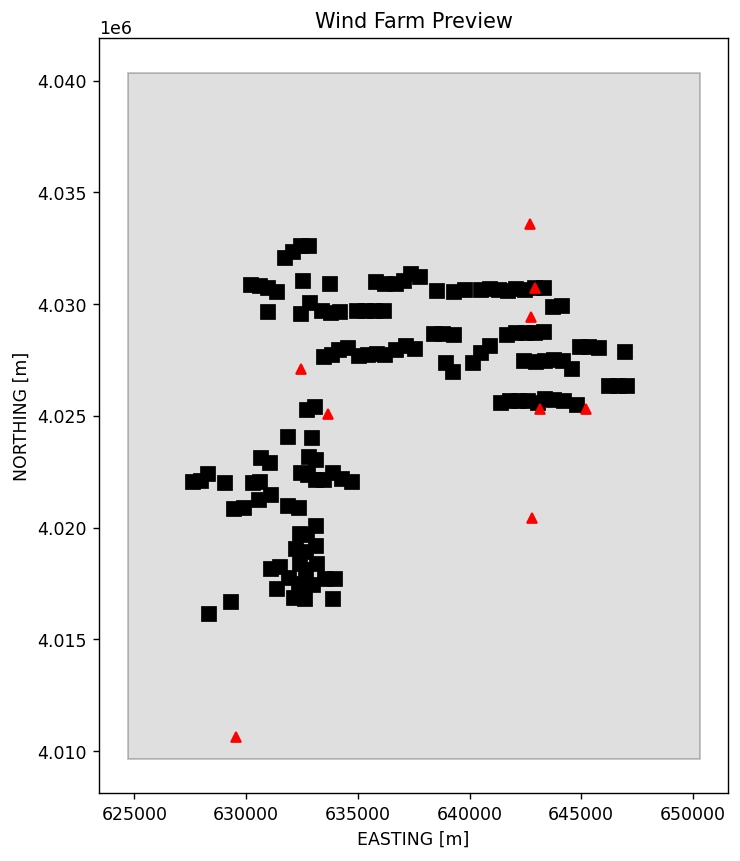

In [17]:
# Preview the turbine layout
fig, ax = plt.subplots(figsize=(8,8), facecolor='w', dpi=125)
case.setAMRWindInput('turbines_plotnames', False)
#case.popup_storteddata['plotdomain']['plot_chooseview']      = 'XY'
case.turbines_previewAllTurbines(ax=ax)

#rect = patches.Rectangle((turb_inside_box[0][0], turb_inside_box[1][0]), 
#                         turb_inside_box[0][1]-turb_inside_box[0][0], 
#                         turb_inside_box[1][1]-turb_inside_box[1][0], linewidth=1, edgecolor='k', linestyle='--', facecolor='none')
#ax.add_patch(rect)

# Plot measurement sites
for k, g in mdict.items():
    ax.plot(g['utmx'], g['utmy'], 'r^')

### Add turbines

In [18]:
case.turbines_createAllTurbines()

# Print out existing list of turbines, just to confirm that the turbines got made
print(len(case.listboxpopupwindict['listboxactuator'].getitemlist()))

docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST_NREL2p8-127_AWAKEN to WIT_USKPL_SS001_WT001_OpenFAST_NREL2p8-127_AWAKEN
WIT_USKPL_SS001_WT001_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127.fst
Fixing yaw in /projects/AWAKEN/lcheung/awaken.github/SummitRuns/AWAKEN_summit_setup/Benchmark1/Phase2/FarmRuns/prod1/BM2_FarmRunProd1newBC/WIT_USKPL_SS001_WT001_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127_ElastoDyn.dat
MISMATCH between incflo.density = 1.076708 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_openfast_stop_time to 9000.0
OrderedDict([('DT_Out', 0.5), ('TStart', 0.0)])
OrderedDict([('YawNeut', 40.0), ('YCMode', 5), ('TYCOn', 0.0)])
OrderedDict([('YawDOF', 'True'), ('BlPitch(1)', 0.0), ('BlPitch(2)', 0.0), ('BlPitch(3)', 0.0)])
OrderedDict([('Y_ControlMode', 1), ('Y_ErrThresh', '4.0 4.0')])
docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST_NREL2p8-127_AWAKEN to WIT_USKPL_SS001_WT002_OpenFAST_NREL2p8-127_AWAKEN


      40.0 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]
  1.076708 AirDens - Air density (kg/m^3) [EDITED]
       0.5 DT_Out - Time step for tabular output (s) (or "default") [EDITED]
       0.0 TStart - Time to begin tabular output (s) [EDITED]
         5 YCMode - Yaw control mode {0: none 3: user-defined from routine UserYawCont 4: user-defined from Simulink/Labview 5: user-defined from Bladed-style DLL} (switch) [EDITED]
       0.0 TYCOn - Time to enable active yaw control (s) [unused when YCMode=0] [EDITED]
      40.0 YawNeut - Neutral yaw position--yaw spring force is zero at this yaw (degrees) [EDITED]
      True YawDOF - Yaw DOF (flag) [EDITED]
       0.0 BlPitch(1) - Blade 1 initial pitch (degrees) [EDITED]
       0.0 BlPitch(2) - Blade 2 initial pitch (degrees) [EDITED]
       0.0 BlPitch(3) - Blade 3 initial pitch (degrees) [unused for 2 blades] [EDITED]
1 ! Y_ControlMode   - Yaw control mode {0: no yaw control, 1: yaw rate control, 2: yaw-by-IPC} [EDITED]
4

MISMATCH between incflo.density = 1.076708 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_openfast_stop_time to 9000.0
OrderedDict([('DT_Out', 0.5), ('TStart', 0.0)])
OrderedDict([('YawNeut', 40.0), ('YCMode', 5), ('TYCOn', 0.0)])
OrderedDict([('YawDOF', 'True'), ('BlPitch(1)', 0.0), ('BlPitch(2)', 0.0), ('BlPitch(3)', 0.0)])
OrderedDict([('Y_ControlMode', 1), ('Y_ErrThresh', '4.0 4.0')])
docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST_NREL2p8-127_AWAKEN to WIT_USKPL_SS001_WT003_OpenFAST_NREL2p8-127_AWAKEN
WIT_USKPL_SS001_WT003_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127.fst
Fixing yaw in /projects/AWAKEN/lcheung/awaken.github/SummitRuns/AWAKEN_summit_setup/Benchmark1/Phase2/FarmRuns/prod1/BM2_FarmRunProd1newBC/WIT_USKPL_SS001_WT003_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127_ElastoDyn.dat
MISMATCH between incflo.density = 1.076708 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_openfast_stop_time to 9000.0
OrderedDict(

         5 YCMode - Yaw control mode {0: none 3: user-defined from routine UserYawCont 4: user-defined from Simulink/Labview 5: user-defined from Bladed-style DLL} (switch) [EDITED]
       0.0 TYCOn - Time to enable active yaw control (s) [unused when YCMode=0] [EDITED]
      40.0 YawNeut - Neutral yaw position--yaw spring force is zero at this yaw (degrees) [EDITED]
      True YawDOF - Yaw DOF (flag) [EDITED]
       0.0 BlPitch(1) - Blade 1 initial pitch (degrees) [EDITED]
       0.0 BlPitch(2) - Blade 2 initial pitch (degrees) [EDITED]
       0.0 BlPitch(3) - Blade 3 initial pitch (degrees) [unused for 2 blades] [EDITED]
1 ! Y_ControlMode   - Yaw control mode {0: no yaw control, 1: yaw rate control, 2: yaw-by-IPC} [EDITED]
4.0 4.0 ! Y_ErrThresh    - Yaw error threshold/deadbands. Turbine begins to yaw when it passes this. If Y_uSwitch is zero, only the second value is used. [deg]. [EDITED]
      40.0 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]
  1.076708 AirDens - 

OrderedDict([('Y_ControlMode', 1), ('Y_ErrThresh', '4.0 4.0')])
docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST_NREL2p8-127_AWAKEN to WIT_USKPL_SS001_WT004_OpenFAST_NREL2p8-127_AWAKEN
WIT_USKPL_SS001_WT004_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127.fst
Fixing yaw in /projects/AWAKEN/lcheung/awaken.github/SummitRuns/AWAKEN_summit_setup/Benchmark1/Phase2/FarmRuns/prod1/BM2_FarmRunProd1newBC/WIT_USKPL_SS001_WT004_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127_ElastoDyn.dat
MISMATCH between incflo.density = 1.076708 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_openfast_stop_time to 9000.0
OrderedDict([('DT_Out', 0.5), ('TStart', 0.0)])
OrderedDict([('YawNeut', 40.0), ('YCMode', 5), ('TYCOn', 0.0)])
OrderedDict([('YawDOF', 'True'), ('BlPitch(1)', 0.0), ('BlPitch(2)', 0.0), ('BlPitch(3)', 0.0)])
OrderedDict([('Y_ControlMode', 1), ('Y_ErrThresh', '4.0 4.0')])


      40.0 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]
  1.076708 AirDens - Air density (kg/m^3) [EDITED]
       0.5 DT_Out - Time step for tabular output (s) (or "default") [EDITED]
       0.0 TStart - Time to begin tabular output (s) [EDITED]
         5 YCMode - Yaw control mode {0: none 3: user-defined from routine UserYawCont 4: user-defined from Simulink/Labview 5: user-defined from Bladed-style DLL} (switch) [EDITED]
       0.0 TYCOn - Time to enable active yaw control (s) [unused when YCMode=0] [EDITED]
      40.0 YawNeut - Neutral yaw position--yaw spring force is zero at this yaw (degrees) [EDITED]
      True YawDOF - Yaw DOF (flag) [EDITED]
       0.0 BlPitch(1) - Blade 1 initial pitch (degrees) [EDITED]
       0.0 BlPitch(2) - Blade 2 initial pitch (degrees) [EDITED]
       0.0 BlPitch(3) - Blade 3 initial pitch (degrees) [unused for 2 blades] [EDITED]
1 ! Y_ControlMode   - Yaw control mode {0: no yaw control, 1: yaw rate control, 2: yaw-by-IPC} [EDITED]
4

docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST_NREL2p8-127_AWAKEN to WIT_USKPL_SS001_WT005_OpenFAST_NREL2p8-127_AWAKEN
WIT_USKPL_SS001_WT005_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127.fst
Fixing yaw in /projects/AWAKEN/lcheung/awaken.github/SummitRuns/AWAKEN_summit_setup/Benchmark1/Phase2/FarmRuns/prod1/BM2_FarmRunProd1newBC/WIT_USKPL_SS001_WT005_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127_ElastoDyn.dat
MISMATCH between incflo.density = 1.076708 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_openfast_stop_time to 9000.0
OrderedDict([('DT_Out', 0.5), ('TStart', 0.0)])
OrderedDict([('YawNeut', 40.0), ('YCMode', 5), ('TYCOn', 0.0)])
OrderedDict([('YawDOF', 'True'), ('BlPitch(1)', 0.0), ('BlPitch(2)', 0.0), ('BlPitch(3)', 0.0)])
OrderedDict([('Y_ControlMode', 1), ('Y_ErrThresh', '4.0 4.0')])
docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST_NREL2p8-127_AWAKEN to WIT_USKPL_SS001_WT006_OpenFAST_NREL2p8-127_AWAKEN


  1.076708 AirDens - Air density (kg/m^3) [EDITED]
       0.5 DT_Out - Time step for tabular output (s) (or "default") [EDITED]
       0.0 TStart - Time to begin tabular output (s) [EDITED]
         5 YCMode - Yaw control mode {0: none 3: user-defined from routine UserYawCont 4: user-defined from Simulink/Labview 5: user-defined from Bladed-style DLL} (switch) [EDITED]
       0.0 TYCOn - Time to enable active yaw control (s) [unused when YCMode=0] [EDITED]
      40.0 YawNeut - Neutral yaw position--yaw spring force is zero at this yaw (degrees) [EDITED]
      True YawDOF - Yaw DOF (flag) [EDITED]
       0.0 BlPitch(1) - Blade 1 initial pitch (degrees) [EDITED]
       0.0 BlPitch(2) - Blade 2 initial pitch (degrees) [EDITED]
       0.0 BlPitch(3) - Blade 3 initial pitch (degrees) [unused for 2 blades] [EDITED]
1 ! Y_ControlMode   - Yaw control mode {0: no yaw control, 1: yaw rate control, 2: yaw-by-IPC} [EDITED]
4.0 4.0 ! Y_ErrThresh    - Yaw error threshold/deadbands. Turbine begins to

WIT_USKPL_SS001_WT006_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127.fst
Fixing yaw in /projects/AWAKEN/lcheung/awaken.github/SummitRuns/AWAKEN_summit_setup/Benchmark1/Phase2/FarmRuns/prod1/BM2_FarmRunProd1newBC/WIT_USKPL_SS001_WT006_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127_ElastoDyn.dat
MISMATCH between incflo.density = 1.076708 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_openfast_stop_time to 9000.0
OrderedDict([('DT_Out', 0.5), ('TStart', 0.0)])
OrderedDict([('YawNeut', 40.0), ('YCMode', 5), ('TYCOn', 0.0)])
OrderedDict([('YawDOF', 'True'), ('BlPitch(1)', 0.0), ('BlPitch(2)', 0.0), ('BlPitch(3)', 0.0)])
OrderedDict([('Y_ControlMode', 1), ('Y_ErrThresh', '4.0 4.0')])
docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST_NREL2p8-127_AWAKEN to WIT_USKPL_SS001_WT007_OpenFAST_NREL2p8-127_AWAKEN
WIT_USKPL_SS001_WT007_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127.fst
Fixing yaw in /projects/AWAKEN/lcheung/awaken.github/SummitRuns/AWAKEN_summit_setup/B

1 ! Y_ControlMode   - Yaw control mode {0: no yaw control, 1: yaw rate control, 2: yaw-by-IPC} [EDITED]
4.0 4.0 ! Y_ErrThresh    - Yaw error threshold/deadbands. Turbine begins to yaw when it passes this. If Y_uSwitch is zero, only the second value is used. [deg]. [EDITED]
      40.0 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]
  1.076708 AirDens - Air density (kg/m^3) [EDITED]
       0.5 DT_Out - Time step for tabular output (s) (or "default") [EDITED]
       0.0 TStart - Time to begin tabular output (s) [EDITED]
         5 YCMode - Yaw control mode {0: none 3: user-defined from routine UserYawCont 4: user-defined from Simulink/Labview 5: user-defined from Bladed-style DLL} (switch) [EDITED]
       0.0 TYCOn - Time to enable active yaw control (s) [unused when YCMode=0] [EDITED]
      40.0 YawNeut - Neutral yaw position--yaw spring force is zero at this yaw (degrees) [EDITED]
      True YawDOF - Yaw DOF (flag) [EDITED]
       0.0 BlPitch(1) - Blade 1 initial pitch (d

Setting Actuator_openfast_stop_time to 9000.0
OrderedDict([('DT_Out', 0.5), ('TStart', 0.0)])
OrderedDict([('YawNeut', 40.0), ('YCMode', 5), ('TYCOn', 0.0)])
OrderedDict([('YawDOF', 'True'), ('BlPitch(1)', 0.0), ('BlPitch(2)', 0.0), ('BlPitch(3)', 0.0)])
OrderedDict([('Y_ControlMode', 1), ('Y_ErrThresh', '4.0 4.0')])
docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST_NREL2p8-127_AWAKEN to WIT_USKPL_SS001_WT008_OpenFAST_NREL2p8-127_AWAKEN
WIT_USKPL_SS001_WT008_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127.fst
Fixing yaw in /projects/AWAKEN/lcheung/awaken.github/SummitRuns/AWAKEN_summit_setup/Benchmark1/Phase2/FarmRuns/prod1/BM2_FarmRunProd1newBC/WIT_USKPL_SS001_WT008_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127_ElastoDyn.dat
MISMATCH between incflo.density = 1.076708 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_openfast_stop_time to 9000.0
OrderedDict([('DT_Out', 0.5), ('TStart', 0.0)])
OrderedDict([('YawNeut', 40.0), ('YCMode', 5), ('TYCOn', 0

      40.0 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]
  1.076708 AirDens - Air density (kg/m^3) [EDITED]
       0.5 DT_Out - Time step for tabular output (s) (or "default") [EDITED]
       0.0 TStart - Time to begin tabular output (s) [EDITED]
         5 YCMode - Yaw control mode {0: none 3: user-defined from routine UserYawCont 4: user-defined from Simulink/Labview 5: user-defined from Bladed-style DLL} (switch) [EDITED]
       0.0 TYCOn - Time to enable active yaw control (s) [unused when YCMode=0] [EDITED]
      40.0 YawNeut - Neutral yaw position--yaw spring force is zero at this yaw (degrees) [EDITED]
      True YawDOF - Yaw DOF (flag) [EDITED]
       0.0 BlPitch(1) - Blade 1 initial pitch (degrees) [EDITED]
       0.0 BlPitch(2) - Blade 2 initial pitch (degrees) [EDITED]
       0.0 BlPitch(3) - Blade 3 initial pitch (degrees) [unused for 2 blades] [EDITED]
1 ! Y_ControlMode   - Yaw control mode {0: no yaw control, 1: yaw rate control, 2: yaw-by-IPC} [EDITED]
4

docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST_NREL2p8-127_AWAKEN to WIT_USKPL_SS001_WT009_OpenFAST_NREL2p8-127_AWAKEN
WIT_USKPL_SS001_WT009_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127.fst
Fixing yaw in /projects/AWAKEN/lcheung/awaken.github/SummitRuns/AWAKEN_summit_setup/Benchmark1/Phase2/FarmRuns/prod1/BM2_FarmRunProd1newBC/WIT_USKPL_SS001_WT009_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127_ElastoDyn.dat
MISMATCH between incflo.density = 1.076708 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_openfast_stop_time to 9000.0
OrderedDict([('DT_Out', 0.5), ('TStart', 0.0)])
OrderedDict([('YawNeut', 40.0), ('YCMode', 5), ('TYCOn', 0.0)])
OrderedDict([('YawDOF', 'True'), ('BlPitch(1)', 0.0), ('BlPitch(2)', 0.0), ('BlPitch(3)', 0.0)])
OrderedDict([('Y_ControlMode', 1), ('Y_ErrThresh', '4.0 4.0')])
docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST_NREL2p8-127_AWAKEN to WIT_USKPL_SS001_WT010_OpenFAST_NREL2p8-127_AWAKEN


         5 YCMode - Yaw control mode {0: none 3: user-defined from routine UserYawCont 4: user-defined from Simulink/Labview 5: user-defined from Bladed-style DLL} (switch) [EDITED]
       0.0 TYCOn - Time to enable active yaw control (s) [unused when YCMode=0] [EDITED]
      40.0 YawNeut - Neutral yaw position--yaw spring force is zero at this yaw (degrees) [EDITED]
      True YawDOF - Yaw DOF (flag) [EDITED]
       0.0 BlPitch(1) - Blade 1 initial pitch (degrees) [EDITED]
       0.0 BlPitch(2) - Blade 2 initial pitch (degrees) [EDITED]
       0.0 BlPitch(3) - Blade 3 initial pitch (degrees) [unused for 2 blades] [EDITED]
1 ! Y_ControlMode   - Yaw control mode {0: no yaw control, 1: yaw rate control, 2: yaw-by-IPC} [EDITED]
4.0 4.0 ! Y_ErrThresh    - Yaw error threshold/deadbands. Turbine begins to yaw when it passes this. If Y_uSwitch is zero, only the second value is used. [deg]. [EDITED]
      40.0 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]
  1.076708 AirDens - 

WIT_USKPL_SS001_WT010_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127.fst
Fixing yaw in /projects/AWAKEN/lcheung/awaken.github/SummitRuns/AWAKEN_summit_setup/Benchmark1/Phase2/FarmRuns/prod1/BM2_FarmRunProd1newBC/WIT_USKPL_SS001_WT010_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127_ElastoDyn.dat
MISMATCH between incflo.density = 1.076708 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_openfast_stop_time to 9000.0
OrderedDict([('DT_Out', 0.5), ('TStart', 0.0)])
OrderedDict([('YawNeut', 40.0), ('YCMode', 5), ('TYCOn', 0.0)])
OrderedDict([('YawDOF', 'True'), ('BlPitch(1)', 0.0), ('BlPitch(2)', 0.0), ('BlPitch(3)', 0.0)])
OrderedDict([('Y_ControlMode', 1), ('Y_ErrThresh', '4.0 4.0')])
docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST_NREL2p8-127_AWAKEN to WIT_USKPL_SS001_WT012_OpenFAST_NREL2p8-127_AWAKEN


         5 YCMode - Yaw control mode {0: none 3: user-defined from routine UserYawCont 4: user-defined from Simulink/Labview 5: user-defined from Bladed-style DLL} (switch) [EDITED]
       0.0 TYCOn - Time to enable active yaw control (s) [unused when YCMode=0] [EDITED]
      40.0 YawNeut - Neutral yaw position--yaw spring force is zero at this yaw (degrees) [EDITED]
      True YawDOF - Yaw DOF (flag) [EDITED]
       0.0 BlPitch(1) - Blade 1 initial pitch (degrees) [EDITED]
       0.0 BlPitch(2) - Blade 2 initial pitch (degrees) [EDITED]
       0.0 BlPitch(3) - Blade 3 initial pitch (degrees) [unused for 2 blades] [EDITED]
1 ! Y_ControlMode   - Yaw control mode {0: no yaw control, 1: yaw rate control, 2: yaw-by-IPC} [EDITED]
4.0 4.0 ! Y_ErrThresh    - Yaw error threshold/deadbands. Turbine begins to yaw when it passes this. If Y_uSwitch is zero, only the second value is used. [deg]. [EDITED]
      40.0 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]
  1.076708 AirDens - 

WIT_USKPL_SS001_WT012_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127.fst
Fixing yaw in /projects/AWAKEN/lcheung/awaken.github/SummitRuns/AWAKEN_summit_setup/Benchmark1/Phase2/FarmRuns/prod1/BM2_FarmRunProd1newBC/WIT_USKPL_SS001_WT012_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127_ElastoDyn.dat
MISMATCH between incflo.density = 1.076708 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_openfast_stop_time to 9000.0
OrderedDict([('DT_Out', 0.5), ('TStart', 0.0)])
OrderedDict([('YawNeut', 40.0), ('YCMode', 5), ('TYCOn', 0.0)])
OrderedDict([('YawDOF', 'True'), ('BlPitch(1)', 0.0), ('BlPitch(2)', 0.0), ('BlPitch(3)', 0.0)])
OrderedDict([('Y_ControlMode', 1), ('Y_ErrThresh', '4.0 4.0')])
docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST_NREL2p8-127_AWAKEN to WIT_USKPL_SS001_WT013_OpenFAST_NREL2p8-127_AWAKEN
WIT_USKPL_SS001_WT013_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127.fst
Fixing yaw in /projects/AWAKEN/lcheung/awaken.github/SummitRuns/AWAKEN_summit_setup/B

      True YawDOF - Yaw DOF (flag) [EDITED]
       0.0 BlPitch(1) - Blade 1 initial pitch (degrees) [EDITED]
       0.0 BlPitch(2) - Blade 2 initial pitch (degrees) [EDITED]
       0.0 BlPitch(3) - Blade 3 initial pitch (degrees) [unused for 2 blades] [EDITED]
1 ! Y_ControlMode   - Yaw control mode {0: no yaw control, 1: yaw rate control, 2: yaw-by-IPC} [EDITED]
4.0 4.0 ! Y_ErrThresh    - Yaw error threshold/deadbands. Turbine begins to yaw when it passes this. If Y_uSwitch is zero, only the second value is used. [deg]. [EDITED]
      40.0 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]
  1.076708 AirDens - Air density (kg/m^3) [EDITED]
       0.5 DT_Out - Time step for tabular output (s) (or "default") [EDITED]
       0.0 TStart - Time to begin tabular output (s) [EDITED]
         5 YCMode - Yaw control mode {0: none 3: user-defined from routine UserYawCont 4: user-defined from Simulink/Labview 5: user-defined from Bladed-style DLL} (switch) [EDITED]
       0.0 TYCOn - 

Setting Actuator_openfast_stop_time to 9000.0
OrderedDict([('DT_Out', 0.5), ('TStart', 0.0)])
OrderedDict([('YawNeut', 40.0), ('YCMode', 5), ('TYCOn', 0.0)])
OrderedDict([('YawDOF', 'True'), ('BlPitch(1)', 0.0), ('BlPitch(2)', 0.0), ('BlPitch(3)', 0.0)])
OrderedDict([('Y_ControlMode', 1), ('Y_ErrThresh', '4.0 4.0')])
docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST_NREL2p8-127_AWAKEN to WIT_USKPL_SS001_WT014_OpenFAST_NREL2p8-127_AWAKEN
WIT_USKPL_SS001_WT014_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127.fst
Fixing yaw in /projects/AWAKEN/lcheung/awaken.github/SummitRuns/AWAKEN_summit_setup/Benchmark1/Phase2/FarmRuns/prod1/BM2_FarmRunProd1newBC/WIT_USKPL_SS001_WT014_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127_ElastoDyn.dat
MISMATCH between incflo.density = 1.076708 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_openfast_stop_time to 9000.0
OrderedDict([('DT_Out', 0.5), ('TStart', 0.0)])
OrderedDict([('YawNeut', 40.0), ('YCMode', 5), ('TYCOn', 0

      40.0 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]
  1.076708 AirDens - Air density (kg/m^3) [EDITED]
       0.5 DT_Out - Time step for tabular output (s) (or "default") [EDITED]
       0.0 TStart - Time to begin tabular output (s) [EDITED]
         5 YCMode - Yaw control mode {0: none 3: user-defined from routine UserYawCont 4: user-defined from Simulink/Labview 5: user-defined from Bladed-style DLL} (switch) [EDITED]
       0.0 TYCOn - Time to enable active yaw control (s) [unused when YCMode=0] [EDITED]
      40.0 YawNeut - Neutral yaw position--yaw spring force is zero at this yaw (degrees) [EDITED]
      True YawDOF - Yaw DOF (flag) [EDITED]
       0.0 BlPitch(1) - Blade 1 initial pitch (degrees) [EDITED]
       0.0 BlPitch(2) - Blade 2 initial pitch (degrees) [EDITED]
       0.0 BlPitch(3) - Blade 3 initial pitch (degrees) [unused for 2 blades] [EDITED]
1 ! Y_ControlMode   - Yaw control mode {0: no yaw control, 1: yaw rate control, 2: yaw-by-IPC} [EDITED]
4

WIT_USKPL_SS001_WT015_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127.fst
Fixing yaw in /projects/AWAKEN/lcheung/awaken.github/SummitRuns/AWAKEN_summit_setup/Benchmark1/Phase2/FarmRuns/prod1/BM2_FarmRunProd1newBC/WIT_USKPL_SS001_WT015_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127_ElastoDyn.dat
MISMATCH between incflo.density = 1.076708 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_openfast_stop_time to 9000.0
OrderedDict([('DT_Out', 0.5), ('TStart', 0.0)])
OrderedDict([('YawNeut', 40.0), ('YCMode', 5), ('TYCOn', 0.0)])
OrderedDict([('YawDOF', 'True'), ('BlPitch(1)', 0.0), ('BlPitch(2)', 0.0), ('BlPitch(3)', 0.0)])
OrderedDict([('Y_ControlMode', 1), ('Y_ErrThresh', '4.0 4.0')])
docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST_NREL2p8-127_AWAKEN to WIT_USKPL_SS001_WT016_OpenFAST_NREL2p8-127_AWAKEN


      40.0 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]
  1.076708 AirDens - Air density (kg/m^3) [EDITED]
       0.5 DT_Out - Time step for tabular output (s) (or "default") [EDITED]
       0.0 TStart - Time to begin tabular output (s) [EDITED]
         5 YCMode - Yaw control mode {0: none 3: user-defined from routine UserYawCont 4: user-defined from Simulink/Labview 5: user-defined from Bladed-style DLL} (switch) [EDITED]
       0.0 TYCOn - Time to enable active yaw control (s) [unused when YCMode=0] [EDITED]
      40.0 YawNeut - Neutral yaw position--yaw spring force is zero at this yaw (degrees) [EDITED]
      True YawDOF - Yaw DOF (flag) [EDITED]
       0.0 BlPitch(1) - Blade 1 initial pitch (degrees) [EDITED]
       0.0 BlPitch(2) - Blade 2 initial pitch (degrees) [EDITED]
       0.0 BlPitch(3) - Blade 3 initial pitch (degrees) [unused for 2 blades] [EDITED]
1 ! Y_ControlMode   - Yaw control mode {0: no yaw control, 1: yaw rate control, 2: yaw-by-IPC} [EDITED]
4

WIT_USKPL_SS001_WT016_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127.fst
Fixing yaw in /projects/AWAKEN/lcheung/awaken.github/SummitRuns/AWAKEN_summit_setup/Benchmark1/Phase2/FarmRuns/prod1/BM2_FarmRunProd1newBC/WIT_USKPL_SS001_WT016_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127_ElastoDyn.dat
MISMATCH between incflo.density = 1.076708 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_openfast_stop_time to 9000.0
OrderedDict([('DT_Out', 0.5), ('TStart', 0.0)])
OrderedDict([('YawNeut', 40.0), ('YCMode', 5), ('TYCOn', 0.0)])
OrderedDict([('YawDOF', 'True'), ('BlPitch(1)', 0.0), ('BlPitch(2)', 0.0), ('BlPitch(3)', 0.0)])
OrderedDict([('Y_ControlMode', 1), ('Y_ErrThresh', '4.0 4.0')])
docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST_NREL2p8-127_AWAKEN to WIT_USKPL_SS001_WT017_OpenFAST_NREL2p8-127_AWAKEN


      40.0 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]
  1.076708 AirDens - Air density (kg/m^3) [EDITED]
       0.5 DT_Out - Time step for tabular output (s) (or "default") [EDITED]
       0.0 TStart - Time to begin tabular output (s) [EDITED]
         5 YCMode - Yaw control mode {0: none 3: user-defined from routine UserYawCont 4: user-defined from Simulink/Labview 5: user-defined from Bladed-style DLL} (switch) [EDITED]
       0.0 TYCOn - Time to enable active yaw control (s) [unused when YCMode=0] [EDITED]
      40.0 YawNeut - Neutral yaw position--yaw spring force is zero at this yaw (degrees) [EDITED]
      True YawDOF - Yaw DOF (flag) [EDITED]
       0.0 BlPitch(1) - Blade 1 initial pitch (degrees) [EDITED]
       0.0 BlPitch(2) - Blade 2 initial pitch (degrees) [EDITED]
       0.0 BlPitch(3) - Blade 3 initial pitch (degrees) [unused for 2 blades] [EDITED]
1 ! Y_ControlMode   - Yaw control mode {0: no yaw control, 1: yaw rate control, 2: yaw-by-IPC} [EDITED]
4

WIT_USKPL_SS001_WT017_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127.fst
Fixing yaw in /projects/AWAKEN/lcheung/awaken.github/SummitRuns/AWAKEN_summit_setup/Benchmark1/Phase2/FarmRuns/prod1/BM2_FarmRunProd1newBC/WIT_USKPL_SS001_WT017_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127_ElastoDyn.dat
MISMATCH between incflo.density = 1.076708 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_openfast_stop_time to 9000.0
OrderedDict([('DT_Out', 0.5), ('TStart', 0.0)])
OrderedDict([('YawNeut', 40.0), ('YCMode', 5), ('TYCOn', 0.0)])
OrderedDict([('YawDOF', 'True'), ('BlPitch(1)', 0.0), ('BlPitch(2)', 0.0), ('BlPitch(3)', 0.0)])
OrderedDict([('Y_ControlMode', 1), ('Y_ErrThresh', '4.0 4.0')])
docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST_NREL2p8-127_AWAKEN to WIT_USKPL_SS001_WT018_OpenFAST_NREL2p8-127_AWAKEN
WIT_USKPL_SS001_WT018_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127.fst
Fixing yaw in /projects/AWAKEN/lcheung/awaken.github/SummitRuns/AWAKEN_summit_setup/B

      40.0 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]
  1.076708 AirDens - Air density (kg/m^3) [EDITED]
       0.5 DT_Out - Time step for tabular output (s) (or "default") [EDITED]
       0.0 TStart - Time to begin tabular output (s) [EDITED]
         5 YCMode - Yaw control mode {0: none 3: user-defined from routine UserYawCont 4: user-defined from Simulink/Labview 5: user-defined from Bladed-style DLL} (switch) [EDITED]
       0.0 TYCOn - Time to enable active yaw control (s) [unused when YCMode=0] [EDITED]
      40.0 YawNeut - Neutral yaw position--yaw spring force is zero at this yaw (degrees) [EDITED]
      True YawDOF - Yaw DOF (flag) [EDITED]
       0.0 BlPitch(1) - Blade 1 initial pitch (degrees) [EDITED]
       0.0 BlPitch(2) - Blade 2 initial pitch (degrees) [EDITED]
       0.0 BlPitch(3) - Blade 3 initial pitch (degrees) [unused for 2 blades] [EDITED]
1 ! Y_ControlMode   - Yaw control mode {0: no yaw control, 1: yaw rate control, 2: yaw-by-IPC} [EDITED]
4

MISMATCH between incflo.density = 1.076708 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_openfast_stop_time to 9000.0
OrderedDict([('DT_Out', 0.5), ('TStart', 0.0)])
OrderedDict([('YawNeut', 40.0), ('YCMode', 5), ('TYCOn', 0.0)])
OrderedDict([('YawDOF', 'True'), ('BlPitch(1)', 0.0), ('BlPitch(2)', 0.0), ('BlPitch(3)', 0.0)])
OrderedDict([('Y_ControlMode', 1), ('Y_ErrThresh', '4.0 4.0')])
docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST_NREL2p8-127_AWAKEN to WIT_USKPL_SS001_WT019_OpenFAST_NREL2p8-127_AWAKEN
WIT_USKPL_SS001_WT019_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127.fst
Fixing yaw in /projects/AWAKEN/lcheung/awaken.github/SummitRuns/AWAKEN_summit_setup/Benchmark1/Phase2/FarmRuns/prod1/BM2_FarmRunProd1newBC/WIT_USKPL_SS001_WT019_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127_ElastoDyn.dat
MISMATCH between incflo.density = 1.076708 and OpenFAST density = 1.225000
USING incflo value


       0.5 DT_Out - Time step for tabular output (s) (or "default") [EDITED]
       0.0 TStart - Time to begin tabular output (s) [EDITED]
         5 YCMode - Yaw control mode {0: none 3: user-defined from routine UserYawCont 4: user-defined from Simulink/Labview 5: user-defined from Bladed-style DLL} (switch) [EDITED]
       0.0 TYCOn - Time to enable active yaw control (s) [unused when YCMode=0] [EDITED]
      40.0 YawNeut - Neutral yaw position--yaw spring force is zero at this yaw (degrees) [EDITED]
      True YawDOF - Yaw DOF (flag) [EDITED]
       0.0 BlPitch(1) - Blade 1 initial pitch (degrees) [EDITED]
       0.0 BlPitch(2) - Blade 2 initial pitch (degrees) [EDITED]
       0.0 BlPitch(3) - Blade 3 initial pitch (degrees) [unused for 2 blades] [EDITED]
1 ! Y_ControlMode   - Yaw control mode {0: no yaw control, 1: yaw rate control, 2: yaw-by-IPC} [EDITED]
4.0 4.0 ! Y_ErrThresh    - Yaw error threshold/deadbands. Turbine begins to yaw when it passes this. If Y_uSwitch is zero, onl

Setting Actuator_openfast_stop_time to 9000.0
OrderedDict([('DT_Out', 0.5), ('TStart', 0.0)])
OrderedDict([('YawNeut', 40.0), ('YCMode', 5), ('TYCOn', 0.0)])
OrderedDict([('YawDOF', 'True'), ('BlPitch(1)', 0.0), ('BlPitch(2)', 0.0), ('BlPitch(3)', 0.0)])
OrderedDict([('Y_ControlMode', 1), ('Y_ErrThresh', '4.0 4.0')])
docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST_NREL2p8-127_AWAKEN to WIT_USKPL_SS001_WT020_OpenFAST_NREL2p8-127_AWAKEN
WIT_USKPL_SS001_WT020_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127.fst
Fixing yaw in /projects/AWAKEN/lcheung/awaken.github/SummitRuns/AWAKEN_summit_setup/Benchmark1/Phase2/FarmRuns/prod1/BM2_FarmRunProd1newBC/WIT_USKPL_SS001_WT020_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127_ElastoDyn.dat
MISMATCH between incflo.density = 1.076708 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_openfast_stop_time to 9000.0
OrderedDict([('DT_Out', 0.5), ('TStart', 0.0)])


         5 YCMode - Yaw control mode {0: none 3: user-defined from routine UserYawCont 4: user-defined from Simulink/Labview 5: user-defined from Bladed-style DLL} (switch) [EDITED]
       0.0 TYCOn - Time to enable active yaw control (s) [unused when YCMode=0] [EDITED]
      40.0 YawNeut - Neutral yaw position--yaw spring force is zero at this yaw (degrees) [EDITED]
      True YawDOF - Yaw DOF (flag) [EDITED]
       0.0 BlPitch(1) - Blade 1 initial pitch (degrees) [EDITED]
       0.0 BlPitch(2) - Blade 2 initial pitch (degrees) [EDITED]
       0.0 BlPitch(3) - Blade 3 initial pitch (degrees) [unused for 2 blades] [EDITED]
1 ! Y_ControlMode   - Yaw control mode {0: no yaw control, 1: yaw rate control, 2: yaw-by-IPC} [EDITED]
4.0 4.0 ! Y_ErrThresh    - Yaw error threshold/deadbands. Turbine begins to yaw when it passes this. If Y_uSwitch is zero, only the second value is used. [deg]. [EDITED]
      40.0 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]
  1.076708 AirDens - 

OrderedDict([('YawNeut', 40.0), ('YCMode', 5), ('TYCOn', 0.0)])
OrderedDict([('YawDOF', 'True'), ('BlPitch(1)', 0.0), ('BlPitch(2)', 0.0), ('BlPitch(3)', 0.0)])
OrderedDict([('Y_ControlMode', 1), ('Y_ErrThresh', '4.0 4.0')])
docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST_NREL2p8-127_AWAKEN to WIT_USKPL_SS001_WT021_OpenFAST_NREL2p8-127_AWAKEN
WIT_USKPL_SS001_WT021_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127.fst
Fixing yaw in /projects/AWAKEN/lcheung/awaken.github/SummitRuns/AWAKEN_summit_setup/Benchmark1/Phase2/FarmRuns/prod1/BM2_FarmRunProd1newBC/WIT_USKPL_SS001_WT021_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127_ElastoDyn.dat
MISMATCH between incflo.density = 1.076708 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_openfast_stop_time to 9000.0
OrderedDict([('DT_Out', 0.5), ('TStart', 0.0)])
OrderedDict([('YawNeut', 40.0), ('YCMode', 5), ('TYCOn', 0.0)])
OrderedDict([('YawDOF', 'True'), ('BlPitch(1)', 0.0), ('BlPitch(2)', 0.0), ('BlPitch(3)'

      True YawDOF - Yaw DOF (flag) [EDITED]
       0.0 BlPitch(1) - Blade 1 initial pitch (degrees) [EDITED]
       0.0 BlPitch(2) - Blade 2 initial pitch (degrees) [EDITED]
       0.0 BlPitch(3) - Blade 3 initial pitch (degrees) [unused for 2 blades] [EDITED]
1 ! Y_ControlMode   - Yaw control mode {0: no yaw control, 1: yaw rate control, 2: yaw-by-IPC} [EDITED]
4.0 4.0 ! Y_ErrThresh    - Yaw error threshold/deadbands. Turbine begins to yaw when it passes this. If Y_uSwitch is zero, only the second value is used. [deg]. [EDITED]
      40.0 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]
  1.076708 AirDens - Air density (kg/m^3) [EDITED]
       0.5 DT_Out - Time step for tabular output (s) (or "default") [EDITED]
       0.0 TStart - Time to begin tabular output (s) [EDITED]
         5 YCMode - Yaw control mode {0: none 3: user-defined from routine UserYawCont 4: user-defined from Simulink/Labview 5: user-defined from Bladed-style DLL} (switch) [EDITED]
       0.0 TYCOn - 

OrderedDict([('Y_ControlMode', 1), ('Y_ErrThresh', '4.0 4.0')])
docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST_NREL2p8-127_AWAKEN to WIT_USKPL_SS001_WT022_OpenFAST_NREL2p8-127_AWAKEN
WIT_USKPL_SS001_WT022_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127.fst
Fixing yaw in /projects/AWAKEN/lcheung/awaken.github/SummitRuns/AWAKEN_summit_setup/Benchmark1/Phase2/FarmRuns/prod1/BM2_FarmRunProd1newBC/WIT_USKPL_SS001_WT022_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127_ElastoDyn.dat


1 ! Y_ControlMode   - Yaw control mode {0: no yaw control, 1: yaw rate control, 2: yaw-by-IPC} [EDITED]
4.0 4.0 ! Y_ErrThresh    - Yaw error threshold/deadbands. Turbine begins to yaw when it passes this. If Y_uSwitch is zero, only the second value is used. [deg]. [EDITED]
      40.0 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]


MISMATCH between incflo.density = 1.076708 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_openfast_stop_time to 9000.0
OrderedDict([('DT_Out', 0.5), ('TStart', 0.0)])
OrderedDict([('YawNeut', 40.0), ('YCMode', 5), ('TYCOn', 0.0)])
OrderedDict([('YawDOF', 'True'), ('BlPitch(1)', 0.0), ('BlPitch(2)', 0.0), ('BlPitch(3)', 0.0)])
OrderedDict([('Y_ControlMode', 1), ('Y_ErrThresh', '4.0 4.0')])
docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST_NREL2p8-127_AWAKEN to WIT_USKPL_SS001_WT023_OpenFAST_NREL2p8-127_AWAKEN
WIT_USKPL_SS001_WT023_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127.fst
Fixing yaw in /projects/AWAKEN/lcheung/awaken.github/SummitRuns/AWAKEN_summit_setup/Benchmark1/Phase2/FarmRuns/prod1/BM2_FarmRunProd1newBC/WIT_USKPL_SS001_WT023_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127_ElastoDyn.dat
MISMATCH between incflo.density = 1.076708 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_openfast_stop_time to 9000.0
OrderedDict(

  1.076708 AirDens - Air density (kg/m^3) [EDITED]
       0.5 DT_Out - Time step for tabular output (s) (or "default") [EDITED]
       0.0 TStart - Time to begin tabular output (s) [EDITED]
         5 YCMode - Yaw control mode {0: none 3: user-defined from routine UserYawCont 4: user-defined from Simulink/Labview 5: user-defined from Bladed-style DLL} (switch) [EDITED]
       0.0 TYCOn - Time to enable active yaw control (s) [unused when YCMode=0] [EDITED]
      40.0 YawNeut - Neutral yaw position--yaw spring force is zero at this yaw (degrees) [EDITED]
      True YawDOF - Yaw DOF (flag) [EDITED]
       0.0 BlPitch(1) - Blade 1 initial pitch (degrees) [EDITED]
       0.0 BlPitch(2) - Blade 2 initial pitch (degrees) [EDITED]
       0.0 BlPitch(3) - Blade 3 initial pitch (degrees) [unused for 2 blades] [EDITED]
1 ! Y_ControlMode   - Yaw control mode {0: no yaw control, 1: yaw rate control, 2: yaw-by-IPC} [EDITED]
4.0 4.0 ! Y_ErrThresh    - Yaw error threshold/deadbands. Turbine begins to

OrderedDict([('YawNeut', 40.0), ('YCMode', 5), ('TYCOn', 0.0)])
OrderedDict([('YawDOF', 'True'), ('BlPitch(1)', 0.0), ('BlPitch(2)', 0.0), ('BlPitch(3)', 0.0)])
OrderedDict([('Y_ControlMode', 1), ('Y_ErrThresh', '4.0 4.0')])
docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST_NREL2p8-127_AWAKEN to WIT_USKPL_SS001_WT024_OpenFAST_NREL2p8-127_AWAKEN
WIT_USKPL_SS001_WT024_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127.fst
Fixing yaw in /projects/AWAKEN/lcheung/awaken.github/SummitRuns/AWAKEN_summit_setup/Benchmark1/Phase2/FarmRuns/prod1/BM2_FarmRunProd1newBC/WIT_USKPL_SS001_WT024_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127_ElastoDyn.dat
MISMATCH between incflo.density = 1.076708 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_openfast_stop_time to 9000.0
OrderedDict([('DT_Out', 0.5), ('TStart', 0.0)])
OrderedDict([('YawNeut', 40.0), ('YCMode', 5), ('TYCOn', 0.0)])
OrderedDict([('YawDOF', 'True'), ('BlPitch(1)', 0.0), ('BlPitch(2)', 0.0), ('BlPitch(3)'

         5 YCMode - Yaw control mode {0: none 3: user-defined from routine UserYawCont 4: user-defined from Simulink/Labview 5: user-defined from Bladed-style DLL} (switch) [EDITED]
       0.0 TYCOn - Time to enable active yaw control (s) [unused when YCMode=0] [EDITED]
      40.0 YawNeut - Neutral yaw position--yaw spring force is zero at this yaw (degrees) [EDITED]
      True YawDOF - Yaw DOF (flag) [EDITED]
       0.0 BlPitch(1) - Blade 1 initial pitch (degrees) [EDITED]
       0.0 BlPitch(2) - Blade 2 initial pitch (degrees) [EDITED]
       0.0 BlPitch(3) - Blade 3 initial pitch (degrees) [unused for 2 blades] [EDITED]
1 ! Y_ControlMode   - Yaw control mode {0: no yaw control, 1: yaw rate control, 2: yaw-by-IPC} [EDITED]
4.0 4.0 ! Y_ErrThresh    - Yaw error threshold/deadbands. Turbine begins to yaw when it passes this. If Y_uSwitch is zero, only the second value is used. [deg]. [EDITED]
      40.0 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]
  1.076708 AirDens - 

docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST_NREL2p8-127_AWAKEN to WIT_USKPL_SS001_WT025_OpenFAST_NREL2p8-127_AWAKEN
WIT_USKPL_SS001_WT025_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127.fst
Fixing yaw in /projects/AWAKEN/lcheung/awaken.github/SummitRuns/AWAKEN_summit_setup/Benchmark1/Phase2/FarmRuns/prod1/BM2_FarmRunProd1newBC/WIT_USKPL_SS001_WT025_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127_ElastoDyn.dat
MISMATCH between incflo.density = 1.076708 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_openfast_stop_time to 9000.0
OrderedDict([('DT_Out', 0.5), ('TStart', 0.0)])
OrderedDict([('YawNeut', 40.0), ('YCMode', 5), ('TYCOn', 0.0)])
OrderedDict([('YawDOF', 'True'), ('BlPitch(1)', 0.0), ('BlPitch(2)', 0.0), ('BlPitch(3)', 0.0)])
OrderedDict([('Y_ControlMode', 1), ('Y_ErrThresh', '4.0 4.0')])


      40.0 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]
  1.076708 AirDens - Air density (kg/m^3) [EDITED]
       0.5 DT_Out - Time step for tabular output (s) (or "default") [EDITED]
       0.0 TStart - Time to begin tabular output (s) [EDITED]
         5 YCMode - Yaw control mode {0: none 3: user-defined from routine UserYawCont 4: user-defined from Simulink/Labview 5: user-defined from Bladed-style DLL} (switch) [EDITED]
       0.0 TYCOn - Time to enable active yaw control (s) [unused when YCMode=0] [EDITED]
      40.0 YawNeut - Neutral yaw position--yaw spring force is zero at this yaw (degrees) [EDITED]
      True YawDOF - Yaw DOF (flag) [EDITED]
       0.0 BlPitch(1) - Blade 1 initial pitch (degrees) [EDITED]
       0.0 BlPitch(2) - Blade 2 initial pitch (degrees) [EDITED]
       0.0 BlPitch(3) - Blade 3 initial pitch (degrees) [unused for 2 blades] [EDITED]
1 ! Y_ControlMode   - Yaw control mode {0: no yaw control, 1: yaw rate control, 2: yaw-by-IPC} [EDITED]
4

docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST_NREL2p8-127_AWAKEN to WIT_USKPL_SS001_WT026_OpenFAST_NREL2p8-127_AWAKEN
WIT_USKPL_SS001_WT026_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127.fst
Fixing yaw in /projects/AWAKEN/lcheung/awaken.github/SummitRuns/AWAKEN_summit_setup/Benchmark1/Phase2/FarmRuns/prod1/BM2_FarmRunProd1newBC/WIT_USKPL_SS001_WT026_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127_ElastoDyn.dat
MISMATCH between incflo.density = 1.076708 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_openfast_stop_time to 9000.0
OrderedDict([('DT_Out', 0.5), ('TStart', 0.0)])
OrderedDict([('YawNeut', 40.0), ('YCMode', 5), ('TYCOn', 0.0)])
OrderedDict([('YawDOF', 'True'), ('BlPitch(1)', 0.0), ('BlPitch(2)', 0.0), ('BlPitch(3)', 0.0)])
OrderedDict([('Y_ControlMode', 1), ('Y_ErrThresh', '4.0 4.0')])
docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST_NREL2p8-127_AWAKEN to WIT_USKPL_SS001_WT027_OpenFAST_NREL2p8-127_AWAKEN


         5 YCMode - Yaw control mode {0: none 3: user-defined from routine UserYawCont 4: user-defined from Simulink/Labview 5: user-defined from Bladed-style DLL} (switch) [EDITED]
       0.0 TYCOn - Time to enable active yaw control (s) [unused when YCMode=0] [EDITED]
      40.0 YawNeut - Neutral yaw position--yaw spring force is zero at this yaw (degrees) [EDITED]
      True YawDOF - Yaw DOF (flag) [EDITED]
       0.0 BlPitch(1) - Blade 1 initial pitch (degrees) [EDITED]
       0.0 BlPitch(2) - Blade 2 initial pitch (degrees) [EDITED]
       0.0 BlPitch(3) - Blade 3 initial pitch (degrees) [unused for 2 blades] [EDITED]
1 ! Y_ControlMode   - Yaw control mode {0: no yaw control, 1: yaw rate control, 2: yaw-by-IPC} [EDITED]
4.0 4.0 ! Y_ErrThresh    - Yaw error threshold/deadbands. Turbine begins to yaw when it passes this. If Y_uSwitch is zero, only the second value is used. [deg]. [EDITED]
      40.0 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]
  1.076708 AirDens - 

WIT_USKPL_SS001_WT027_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127.fst
Fixing yaw in /projects/AWAKEN/lcheung/awaken.github/SummitRuns/AWAKEN_summit_setup/Benchmark1/Phase2/FarmRuns/prod1/BM2_FarmRunProd1newBC/WIT_USKPL_SS001_WT027_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127_ElastoDyn.dat
MISMATCH between incflo.density = 1.076708 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_openfast_stop_time to 9000.0
OrderedDict([('DT_Out', 0.5), ('TStart', 0.0)])
OrderedDict([('YawNeut', 40.0), ('YCMode', 5), ('TYCOn', 0.0)])
OrderedDict([('YawDOF', 'True'), ('BlPitch(1)', 0.0), ('BlPitch(2)', 0.0), ('BlPitch(3)', 0.0)])
OrderedDict([('Y_ControlMode', 1), ('Y_ErrThresh', '4.0 4.0')])
docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST_NREL2p8-127_AWAKEN to WIT_USKPL_SS001_WT028_OpenFAST_NREL2p8-127_AWAKEN
WIT_USKPL_SS001_WT028_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127.fst
Fixing yaw in /projects/AWAKEN/lcheung/awaken.github/SummitRuns/AWAKEN_summit_setup/B

      40.0 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]
  1.076708 AirDens - Air density (kg/m^3) [EDITED]
       0.5 DT_Out - Time step for tabular output (s) (or "default") [EDITED]
       0.0 TStart - Time to begin tabular output (s) [EDITED]
         5 YCMode - Yaw control mode {0: none 3: user-defined from routine UserYawCont 4: user-defined from Simulink/Labview 5: user-defined from Bladed-style DLL} (switch) [EDITED]
       0.0 TYCOn - Time to enable active yaw control (s) [unused when YCMode=0] [EDITED]
      40.0 YawNeut - Neutral yaw position--yaw spring force is zero at this yaw (degrees) [EDITED]
      True YawDOF - Yaw DOF (flag) [EDITED]
       0.0 BlPitch(1) - Blade 1 initial pitch (degrees) [EDITED]
       0.0 BlPitch(2) - Blade 2 initial pitch (degrees) [EDITED]
       0.0 BlPitch(3) - Blade 3 initial pitch (degrees) [unused for 2 blades] [EDITED]
1 ! Y_ControlMode   - Yaw control mode {0: no yaw control, 1: yaw rate control, 2: yaw-by-IPC} [EDITED]
4

MISMATCH between incflo.density = 1.076708 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_openfast_stop_time to 9000.0
OrderedDict([('DT_Out', 0.5), ('TStart', 0.0)])
OrderedDict([('YawNeut', 40.0), ('YCMode', 5), ('TYCOn', 0.0)])
OrderedDict([('YawDOF', 'True'), ('BlPitch(1)', 0.0), ('BlPitch(2)', 0.0), ('BlPitch(3)', 0.0)])
OrderedDict([('Y_ControlMode', 1), ('Y_ErrThresh', '4.0 4.0')])
docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST_NREL2p8-127_AWAKEN to WIT_USKPL_SS001_WT030_OpenFAST_NREL2p8-127_AWAKEN
WIT_USKPL_SS001_WT030_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127.fst
Fixing yaw in /projects/AWAKEN/lcheung/awaken.github/SummitRuns/AWAKEN_summit_setup/Benchmark1/Phase2/FarmRuns/prod1/BM2_FarmRunProd1newBC/WIT_USKPL_SS001_WT030_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127_ElastoDyn.dat
MISMATCH between incflo.density = 1.076708 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_openfast_stop_time to 9000.0
OrderedDict(

       0.5 DT_Out - Time step for tabular output (s) (or "default") [EDITED]
       0.0 TStart - Time to begin tabular output (s) [EDITED]
         5 YCMode - Yaw control mode {0: none 3: user-defined from routine UserYawCont 4: user-defined from Simulink/Labview 5: user-defined from Bladed-style DLL} (switch) [EDITED]
       0.0 TYCOn - Time to enable active yaw control (s) [unused when YCMode=0] [EDITED]
      40.0 YawNeut - Neutral yaw position--yaw spring force is zero at this yaw (degrees) [EDITED]
      True YawDOF - Yaw DOF (flag) [EDITED]
       0.0 BlPitch(1) - Blade 1 initial pitch (degrees) [EDITED]
       0.0 BlPitch(2) - Blade 2 initial pitch (degrees) [EDITED]
       0.0 BlPitch(3) - Blade 3 initial pitch (degrees) [unused for 2 blades] [EDITED]
1 ! Y_ControlMode   - Yaw control mode {0: no yaw control, 1: yaw rate control, 2: yaw-by-IPC} [EDITED]
4.0 4.0 ! Y_ErrThresh    - Yaw error threshold/deadbands. Turbine begins to yaw when it passes this. If Y_uSwitch is zero, onl

OrderedDict([('YawDOF', 'True'), ('BlPitch(1)', 0.0), ('BlPitch(2)', 0.0), ('BlPitch(3)', 0.0)])
OrderedDict([('Y_ControlMode', 1), ('Y_ErrThresh', '4.0 4.0')])
docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST_NREL2p8-127_AWAKEN to WIT_USKPL_SS001_WT031_OpenFAST_NREL2p8-127_AWAKEN
WIT_USKPL_SS001_WT031_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127.fst
Fixing yaw in /projects/AWAKEN/lcheung/awaken.github/SummitRuns/AWAKEN_summit_setup/Benchmark1/Phase2/FarmRuns/prod1/BM2_FarmRunProd1newBC/WIT_USKPL_SS001_WT031_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127_ElastoDyn.dat
MISMATCH between incflo.density = 1.076708 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_openfast_stop_time to 9000.0
OrderedDict([('DT_Out', 0.5), ('TStart', 0.0)])
OrderedDict([('YawNeut', 40.0), ('YCMode', 5), ('TYCOn', 0.0)])
OrderedDict([('YawDOF', 'True'), ('BlPitch(1)', 0.0), ('BlPitch(2)', 0.0), ('BlPitch(3)', 0.0)])
OrderedDict([('Y_ControlMode', 1), ('Y_ErrThresh', '4.0

      True YawDOF - Yaw DOF (flag) [EDITED]
       0.0 BlPitch(1) - Blade 1 initial pitch (degrees) [EDITED]
       0.0 BlPitch(2) - Blade 2 initial pitch (degrees) [EDITED]
       0.0 BlPitch(3) - Blade 3 initial pitch (degrees) [unused for 2 blades] [EDITED]
1 ! Y_ControlMode   - Yaw control mode {0: no yaw control, 1: yaw rate control, 2: yaw-by-IPC} [EDITED]
4.0 4.0 ! Y_ErrThresh    - Yaw error threshold/deadbands. Turbine begins to yaw when it passes this. If Y_uSwitch is zero, only the second value is used. [deg]. [EDITED]
      40.0 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]
  1.076708 AirDens - Air density (kg/m^3) [EDITED]
       0.5 DT_Out - Time step for tabular output (s) (or "default") [EDITED]
       0.0 TStart - Time to begin tabular output (s) [EDITED]
         5 YCMode - Yaw control mode {0: none 3: user-defined from routine UserYawCont 4: user-defined from Simulink/Labview 5: user-defined from Bladed-style DLL} (switch) [EDITED]
       0.0 TYCOn - 

docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST_NREL2p8-127_AWAKEN to WIT_USKPL_SS001_WT032_OpenFAST_NREL2p8-127_AWAKEN
WIT_USKPL_SS001_WT032_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127.fst
Fixing yaw in /projects/AWAKEN/lcheung/awaken.github/SummitRuns/AWAKEN_summit_setup/Benchmark1/Phase2/FarmRuns/prod1/BM2_FarmRunProd1newBC/WIT_USKPL_SS001_WT032_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127_ElastoDyn.dat
MISMATCH between incflo.density = 1.076708 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_openfast_stop_time to 9000.0
OrderedDict([('DT_Out', 0.5), ('TStart', 0.0)])
OrderedDict([('YawNeut', 40.0), ('YCMode', 5), ('TYCOn', 0.0)])
OrderedDict([('YawDOF', 'True'), ('BlPitch(1)', 0.0), ('BlPitch(2)', 0.0), ('BlPitch(3)', 0.0)])
OrderedDict([('Y_ControlMode', 1), ('Y_ErrThresh', '4.0 4.0')])
docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST_NREL2p8-127_AWAKEN to WIT_USKPL_SS001_WT033_OpenFAST_NREL2p8-127_AWAKEN


      40.0 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]
  1.076708 AirDens - Air density (kg/m^3) [EDITED]
       0.5 DT_Out - Time step for tabular output (s) (or "default") [EDITED]
       0.0 TStart - Time to begin tabular output (s) [EDITED]
         5 YCMode - Yaw control mode {0: none 3: user-defined from routine UserYawCont 4: user-defined from Simulink/Labview 5: user-defined from Bladed-style DLL} (switch) [EDITED]
       0.0 TYCOn - Time to enable active yaw control (s) [unused when YCMode=0] [EDITED]
      40.0 YawNeut - Neutral yaw position--yaw spring force is zero at this yaw (degrees) [EDITED]
      True YawDOF - Yaw DOF (flag) [EDITED]
       0.0 BlPitch(1) - Blade 1 initial pitch (degrees) [EDITED]
       0.0 BlPitch(2) - Blade 2 initial pitch (degrees) [EDITED]
       0.0 BlPitch(3) - Blade 3 initial pitch (degrees) [unused for 2 blades] [EDITED]
1 ! Y_ControlMode   - Yaw control mode {0: no yaw control, 1: yaw rate control, 2: yaw-by-IPC} [EDITED]
4

Setting Actuator_openfast_stop_time to 9000.0
OrderedDict([('DT_Out', 0.5), ('TStart', 0.0)])
OrderedDict([('YawNeut', 40.0), ('YCMode', 5), ('TYCOn', 0.0)])
OrderedDict([('YawDOF', 'True'), ('BlPitch(1)', 0.0), ('BlPitch(2)', 0.0), ('BlPitch(3)', 0.0)])
OrderedDict([('Y_ControlMode', 1), ('Y_ErrThresh', '4.0 4.0')])
docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST_NREL2p8-127_AWAKEN to WIT_USKPL_SS001_WT035_OpenFAST_NREL2p8-127_AWAKEN
WIT_USKPL_SS001_WT035_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127.fst
Fixing yaw in /projects/AWAKEN/lcheung/awaken.github/SummitRuns/AWAKEN_summit_setup/Benchmark1/Phase2/FarmRuns/prod1/BM2_FarmRunProd1newBC/WIT_USKPL_SS001_WT035_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127_ElastoDyn.dat
MISMATCH between incflo.density = 1.076708 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_openfast_stop_time to 9000.0
OrderedDict([('DT_Out', 0.5), ('TStart', 0.0)])
OrderedDict([('YawNeut', 40.0), ('YCMode', 5), ('TYCOn', 0

       0.5 DT_Out - Time step for tabular output (s) (or "default") [EDITED]
       0.0 TStart - Time to begin tabular output (s) [EDITED]
         5 YCMode - Yaw control mode {0: none 3: user-defined from routine UserYawCont 4: user-defined from Simulink/Labview 5: user-defined from Bladed-style DLL} (switch) [EDITED]
       0.0 TYCOn - Time to enable active yaw control (s) [unused when YCMode=0] [EDITED]
      40.0 YawNeut - Neutral yaw position--yaw spring force is zero at this yaw (degrees) [EDITED]
      True YawDOF - Yaw DOF (flag) [EDITED]
       0.0 BlPitch(1) - Blade 1 initial pitch (degrees) [EDITED]
       0.0 BlPitch(2) - Blade 2 initial pitch (degrees) [EDITED]
       0.0 BlPitch(3) - Blade 3 initial pitch (degrees) [unused for 2 blades] [EDITED]
1 ! Y_ControlMode   - Yaw control mode {0: no yaw control, 1: yaw rate control, 2: yaw-by-IPC} [EDITED]
4.0 4.0 ! Y_ErrThresh    - Yaw error threshold/deadbands. Turbine begins to yaw when it passes this. If Y_uSwitch is zero, onl

OrderedDict([('Y_ControlMode', 1), ('Y_ErrThresh', '4.0 4.0')])
docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST_NREL2p8-127_AWAKEN to WIT_USKPL_SS001_WT036_OpenFAST_NREL2p8-127_AWAKEN
WIT_USKPL_SS001_WT036_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127.fst
Fixing yaw in /projects/AWAKEN/lcheung/awaken.github/SummitRuns/AWAKEN_summit_setup/Benchmark1/Phase2/FarmRuns/prod1/BM2_FarmRunProd1newBC/WIT_USKPL_SS001_WT036_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127_ElastoDyn.dat
MISMATCH between incflo.density = 1.076708 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_openfast_stop_time to 9000.0
OrderedDict([('DT_Out', 0.5), ('TStart', 0.0)])
OrderedDict([('YawNeut', 40.0), ('YCMode', 5), ('TYCOn', 0.0)])
OrderedDict([('YawDOF', 'True'), ('BlPitch(1)', 0.0), ('BlPitch(2)', 0.0), ('BlPitch(3)', 0.0)])
OrderedDict([('Y_ControlMode', 1), ('Y_ErrThresh', '4.0 4.0')])


1 ! Y_ControlMode   - Yaw control mode {0: no yaw control, 1: yaw rate control, 2: yaw-by-IPC} [EDITED]
4.0 4.0 ! Y_ErrThresh    - Yaw error threshold/deadbands. Turbine begins to yaw when it passes this. If Y_uSwitch is zero, only the second value is used. [deg]. [EDITED]
      40.0 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]
  1.076708 AirDens - Air density (kg/m^3) [EDITED]
       0.5 DT_Out - Time step for tabular output (s) (or "default") [EDITED]
       0.0 TStart - Time to begin tabular output (s) [EDITED]
         5 YCMode - Yaw control mode {0: none 3: user-defined from routine UserYawCont 4: user-defined from Simulink/Labview 5: user-defined from Bladed-style DLL} (switch) [EDITED]
       0.0 TYCOn - Time to enable active yaw control (s) [unused when YCMode=0] [EDITED]
      40.0 YawNeut - Neutral yaw position--yaw spring force is zero at this yaw (degrees) [EDITED]
      True YawDOF - Yaw DOF (flag) [EDITED]
       0.0 BlPitch(1) - Blade 1 initial pitch (d

docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST_NREL2p8-127_AWAKEN to WIT_USKPL_SS001_WT037_OpenFAST_NREL2p8-127_AWAKEN
WIT_USKPL_SS001_WT037_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127.fst
Fixing yaw in /projects/AWAKEN/lcheung/awaken.github/SummitRuns/AWAKEN_summit_setup/Benchmark1/Phase2/FarmRuns/prod1/BM2_FarmRunProd1newBC/WIT_USKPL_SS001_WT037_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127_ElastoDyn.dat
MISMATCH between incflo.density = 1.076708 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_openfast_stop_time to 9000.0
OrderedDict([('DT_Out', 0.5), ('TStart', 0.0)])
OrderedDict([('YawNeut', 40.0), ('YCMode', 5), ('TYCOn', 0.0)])
OrderedDict([('YawDOF', 'True'), ('BlPitch(1)', 0.0), ('BlPitch(2)', 0.0), ('BlPitch(3)', 0.0)])
OrderedDict([('Y_ControlMode', 1), ('Y_ErrThresh', '4.0 4.0')])


      40.0 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]
  1.076708 AirDens - Air density (kg/m^3) [EDITED]
       0.5 DT_Out - Time step for tabular output (s) (or "default") [EDITED]
       0.0 TStart - Time to begin tabular output (s) [EDITED]
         5 YCMode - Yaw control mode {0: none 3: user-defined from routine UserYawCont 4: user-defined from Simulink/Labview 5: user-defined from Bladed-style DLL} (switch) [EDITED]
       0.0 TYCOn - Time to enable active yaw control (s) [unused when YCMode=0] [EDITED]
      40.0 YawNeut - Neutral yaw position--yaw spring force is zero at this yaw (degrees) [EDITED]
      True YawDOF - Yaw DOF (flag) [EDITED]
       0.0 BlPitch(1) - Blade 1 initial pitch (degrees) [EDITED]
       0.0 BlPitch(2) - Blade 2 initial pitch (degrees) [EDITED]
       0.0 BlPitch(3) - Blade 3 initial pitch (degrees) [unused for 2 blades] [EDITED]
1 ! Y_ControlMode   - Yaw control mode {0: no yaw control, 1: yaw rate control, 2: yaw-by-IPC} [EDITED]
4

docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST_NREL2p8-127_AWAKEN to WIT_USKPL_SS001_WT038_OpenFAST_NREL2p8-127_AWAKEN
WIT_USKPL_SS001_WT038_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127.fst
Fixing yaw in /projects/AWAKEN/lcheung/awaken.github/SummitRuns/AWAKEN_summit_setup/Benchmark1/Phase2/FarmRuns/prod1/BM2_FarmRunProd1newBC/WIT_USKPL_SS001_WT038_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127_ElastoDyn.dat
MISMATCH between incflo.density = 1.076708 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_openfast_stop_time to 9000.0
OrderedDict([('DT_Out', 0.5), ('TStart', 0.0)])
OrderedDict([('YawNeut', 40.0), ('YCMode', 5), ('TYCOn', 0.0)])
OrderedDict([('YawDOF', 'True'), ('BlPitch(1)', 0.0), ('BlPitch(2)', 0.0), ('BlPitch(3)', 0.0)])


      40.0 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]
  1.076708 AirDens - Air density (kg/m^3) [EDITED]
       0.5 DT_Out - Time step for tabular output (s) (or "default") [EDITED]
       0.0 TStart - Time to begin tabular output (s) [EDITED]
         5 YCMode - Yaw control mode {0: none 3: user-defined from routine UserYawCont 4: user-defined from Simulink/Labview 5: user-defined from Bladed-style DLL} (switch) [EDITED]
       0.0 TYCOn - Time to enable active yaw control (s) [unused when YCMode=0] [EDITED]
      40.0 YawNeut - Neutral yaw position--yaw spring force is zero at this yaw (degrees) [EDITED]
      True YawDOF - Yaw DOF (flag) [EDITED]
       0.0 BlPitch(1) - Blade 1 initial pitch (degrees) [EDITED]
       0.0 BlPitch(2) - Blade 2 initial pitch (degrees) [EDITED]
       0.0 BlPitch(3) - Blade 3 initial pitch (degrees) [unused for 2 blades] [EDITED]
1 ! Y_ControlMode   - Yaw control mode {0: no yaw control, 1: yaw rate control, 2: yaw-by-IPC} [EDITED]
4

OrderedDict([('Y_ControlMode', 1), ('Y_ErrThresh', '4.0 4.0')])
docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST_NREL2p8-127_AWAKEN to WIT_USKPL_SS001_WT039_OpenFAST_NREL2p8-127_AWAKEN
WIT_USKPL_SS001_WT039_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127.fst
Fixing yaw in /projects/AWAKEN/lcheung/awaken.github/SummitRuns/AWAKEN_summit_setup/Benchmark1/Phase2/FarmRuns/prod1/BM2_FarmRunProd1newBC/WIT_USKPL_SS001_WT039_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127_ElastoDyn.dat
MISMATCH between incflo.density = 1.076708 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_openfast_stop_time to 9000.0
OrderedDict([('DT_Out', 0.5), ('TStart', 0.0)])
OrderedDict([('YawNeut', 40.0), ('YCMode', 5), ('TYCOn', 0.0)])
OrderedDict([('YawDOF', 'True'), ('BlPitch(1)', 0.0), ('BlPitch(2)', 0.0), ('BlPitch(3)', 0.0)])
OrderedDict([('Y_ControlMode', 1), ('Y_ErrThresh', '4.0 4.0')])
docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST_NREL2p8-

      40.0 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]
  1.076708 AirDens - Air density (kg/m^3) [EDITED]
       0.5 DT_Out - Time step for tabular output (s) (or "default") [EDITED]
       0.0 TStart - Time to begin tabular output (s) [EDITED]
         5 YCMode - Yaw control mode {0: none 3: user-defined from routine UserYawCont 4: user-defined from Simulink/Labview 5: user-defined from Bladed-style DLL} (switch) [EDITED]
       0.0 TYCOn - Time to enable active yaw control (s) [unused when YCMode=0] [EDITED]
      40.0 YawNeut - Neutral yaw position--yaw spring force is zero at this yaw (degrees) [EDITED]
      True YawDOF - Yaw DOF (flag) [EDITED]
       0.0 BlPitch(1) - Blade 1 initial pitch (degrees) [EDITED]
       0.0 BlPitch(2) - Blade 2 initial pitch (degrees) [EDITED]
       0.0 BlPitch(3) - Blade 3 initial pitch (degrees) [unused for 2 blades] [EDITED]
1 ! Y_ControlMode   - Yaw control mode {0: no yaw control, 1: yaw rate control, 2: yaw-by-IPC} [EDITED]
4

WIT_USKPL_SS001_WT040_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127.fst
Fixing yaw in /projects/AWAKEN/lcheung/awaken.github/SummitRuns/AWAKEN_summit_setup/Benchmark1/Phase2/FarmRuns/prod1/BM2_FarmRunProd1newBC/WIT_USKPL_SS001_WT040_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127_ElastoDyn.dat
MISMATCH between incflo.density = 1.076708 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_openfast_stop_time to 9000.0
OrderedDict([('DT_Out', 0.5), ('TStart', 0.0)])
OrderedDict([('YawNeut', 40.0), ('YCMode', 5), ('TYCOn', 0.0)])
OrderedDict([('YawDOF', 'True'), ('BlPitch(1)', 0.0), ('BlPitch(2)', 0.0), ('BlPitch(3)', 0.0)])
OrderedDict([('Y_ControlMode', 1), ('Y_ErrThresh', '4.0 4.0')])
docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST_NREL2p8-127_AWAKEN to WIT_USKPL_SS001_WT041_OpenFAST_NREL2p8-127_AWAKEN


      40.0 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]
  1.076708 AirDens - Air density (kg/m^3) [EDITED]
       0.5 DT_Out - Time step for tabular output (s) (or "default") [EDITED]
       0.0 TStart - Time to begin tabular output (s) [EDITED]
         5 YCMode - Yaw control mode {0: none 3: user-defined from routine UserYawCont 4: user-defined from Simulink/Labview 5: user-defined from Bladed-style DLL} (switch) [EDITED]
       0.0 TYCOn - Time to enable active yaw control (s) [unused when YCMode=0] [EDITED]
      40.0 YawNeut - Neutral yaw position--yaw spring force is zero at this yaw (degrees) [EDITED]
      True YawDOF - Yaw DOF (flag) [EDITED]
       0.0 BlPitch(1) - Blade 1 initial pitch (degrees) [EDITED]
       0.0 BlPitch(2) - Blade 2 initial pitch (degrees) [EDITED]
       0.0 BlPitch(3) - Blade 3 initial pitch (degrees) [unused for 2 blades] [EDITED]
1 ! Y_ControlMode   - Yaw control mode {0: no yaw control, 1: yaw rate control, 2: yaw-by-IPC} [EDITED]
4

WIT_USKPL_SS001_WT041_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127.fst
Fixing yaw in /projects/AWAKEN/lcheung/awaken.github/SummitRuns/AWAKEN_summit_setup/Benchmark1/Phase2/FarmRuns/prod1/BM2_FarmRunProd1newBC/WIT_USKPL_SS001_WT041_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127_ElastoDyn.dat
MISMATCH between incflo.density = 1.076708 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_openfast_stop_time to 9000.0
OrderedDict([('DT_Out', 0.5), ('TStart', 0.0)])
OrderedDict([('YawNeut', 40.0), ('YCMode', 5), ('TYCOn', 0.0)])
OrderedDict([('YawDOF', 'True'), ('BlPitch(1)', 0.0), ('BlPitch(2)', 0.0), ('BlPitch(3)', 0.0)])
OrderedDict([('Y_ControlMode', 1), ('Y_ErrThresh', '4.0 4.0')])
docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST_NREL2p8-127_AWAKEN to WIT_USKPL_SS001_WT042_OpenFAST_NREL2p8-127_AWAKEN
WIT_USKPL_SS001_WT042_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127.fst
Fixing yaw in /projects/AWAKEN/lcheung/awaken.github/SummitRuns/AWAKEN_summit_setup/B

      40.0 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]
  1.076708 AirDens - Air density (kg/m^3) [EDITED]
       0.5 DT_Out - Time step for tabular output (s) (or "default") [EDITED]
       0.0 TStart - Time to begin tabular output (s) [EDITED]
         5 YCMode - Yaw control mode {0: none 3: user-defined from routine UserYawCont 4: user-defined from Simulink/Labview 5: user-defined from Bladed-style DLL} (switch) [EDITED]
       0.0 TYCOn - Time to enable active yaw control (s) [unused when YCMode=0] [EDITED]
      40.0 YawNeut - Neutral yaw position--yaw spring force is zero at this yaw (degrees) [EDITED]
      True YawDOF - Yaw DOF (flag) [EDITED]
       0.0 BlPitch(1) - Blade 1 initial pitch (degrees) [EDITED]
       0.0 BlPitch(2) - Blade 2 initial pitch (degrees) [EDITED]
       0.0 BlPitch(3) - Blade 3 initial pitch (degrees) [unused for 2 blades] [EDITED]
1 ! Y_ControlMode   - Yaw control mode {0: no yaw control, 1: yaw rate control, 2: yaw-by-IPC} [EDITED]
4

Setting Actuator_openfast_stop_time to 9000.0
OrderedDict([('DT_Out', 0.5), ('TStart', 0.0)])
OrderedDict([('YawNeut', 40.0), ('YCMode', 5), ('TYCOn', 0.0)])
OrderedDict([('YawDOF', 'True'), ('BlPitch(1)', 0.0), ('BlPitch(2)', 0.0), ('BlPitch(3)', 0.0)])
OrderedDict([('Y_ControlMode', 1), ('Y_ErrThresh', '4.0 4.0')])
docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST_NREL2p8-127_AWAKEN to WIT_USKPL_SS001_WT043_OpenFAST_NREL2p8-127_AWAKEN
WIT_USKPL_SS001_WT043_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127.fst
Fixing yaw in /projects/AWAKEN/lcheung/awaken.github/SummitRuns/AWAKEN_summit_setup/Benchmark1/Phase2/FarmRuns/prod1/BM2_FarmRunProd1newBC/WIT_USKPL_SS001_WT043_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127_ElastoDyn.dat
MISMATCH between incflo.density = 1.076708 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_openfast_stop_time to 9000.0
OrderedDict([('DT_Out', 0.5), ('TStart', 0.0)])
OrderedDict([('YawNeut', 40.0), ('YCMode', 5), ('TYCOn', 0

         5 YCMode - Yaw control mode {0: none 3: user-defined from routine UserYawCont 4: user-defined from Simulink/Labview 5: user-defined from Bladed-style DLL} (switch) [EDITED]
       0.0 TYCOn - Time to enable active yaw control (s) [unused when YCMode=0] [EDITED]
      40.0 YawNeut - Neutral yaw position--yaw spring force is zero at this yaw (degrees) [EDITED]
      True YawDOF - Yaw DOF (flag) [EDITED]
       0.0 BlPitch(1) - Blade 1 initial pitch (degrees) [EDITED]
       0.0 BlPitch(2) - Blade 2 initial pitch (degrees) [EDITED]
       0.0 BlPitch(3) - Blade 3 initial pitch (degrees) [unused for 2 blades] [EDITED]
1 ! Y_ControlMode   - Yaw control mode {0: no yaw control, 1: yaw rate control, 2: yaw-by-IPC} [EDITED]
4.0 4.0 ! Y_ErrThresh    - Yaw error threshold/deadbands. Turbine begins to yaw when it passes this. If Y_uSwitch is zero, only the second value is used. [deg]. [EDITED]
      40.0 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]
  1.076708 AirDens - 

docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST_NREL2p8-127_AWAKEN to WIT_USKPL_SS001_WT044_OpenFAST_NREL2p8-127_AWAKEN
WIT_USKPL_SS001_WT044_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127.fst
Fixing yaw in /projects/AWAKEN/lcheung/awaken.github/SummitRuns/AWAKEN_summit_setup/Benchmark1/Phase2/FarmRuns/prod1/BM2_FarmRunProd1newBC/WIT_USKPL_SS001_WT044_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127_ElastoDyn.dat
MISMATCH between incflo.density = 1.076708 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_openfast_stop_time to 9000.0
OrderedDict([('DT_Out', 0.5), ('TStart', 0.0)])
OrderedDict([('YawNeut', 40.0), ('YCMode', 5), ('TYCOn', 0.0)])
OrderedDict([('YawDOF', 'True'), ('BlPitch(1)', 0.0), ('BlPitch(2)', 0.0), ('BlPitch(3)', 0.0)])
OrderedDict([('Y_ControlMode', 1), ('Y_ErrThresh', '4.0 4.0')])
docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST_NREL2p8-127_AWAKEN to WIT_USKPL_SS001_WT045_OpenFAST_NREL2p8-127_AWAKEN


      40.0 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]
  1.076708 AirDens - Air density (kg/m^3) [EDITED]
       0.5 DT_Out - Time step for tabular output (s) (or "default") [EDITED]
       0.0 TStart - Time to begin tabular output (s) [EDITED]
         5 YCMode - Yaw control mode {0: none 3: user-defined from routine UserYawCont 4: user-defined from Simulink/Labview 5: user-defined from Bladed-style DLL} (switch) [EDITED]
       0.0 TYCOn - Time to enable active yaw control (s) [unused when YCMode=0] [EDITED]
      40.0 YawNeut - Neutral yaw position--yaw spring force is zero at this yaw (degrees) [EDITED]
      True YawDOF - Yaw DOF (flag) [EDITED]
       0.0 BlPitch(1) - Blade 1 initial pitch (degrees) [EDITED]
       0.0 BlPitch(2) - Blade 2 initial pitch (degrees) [EDITED]
       0.0 BlPitch(3) - Blade 3 initial pitch (degrees) [unused for 2 blades] [EDITED]
1 ! Y_ControlMode   - Yaw control mode {0: no yaw control, 1: yaw rate control, 2: yaw-by-IPC} [EDITED]
4

WIT_USKPL_SS001_WT045_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127.fst
Fixing yaw in /projects/AWAKEN/lcheung/awaken.github/SummitRuns/AWAKEN_summit_setup/Benchmark1/Phase2/FarmRuns/prod1/BM2_FarmRunProd1newBC/WIT_USKPL_SS001_WT045_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127_ElastoDyn.dat
MISMATCH between incflo.density = 1.076708 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_openfast_stop_time to 9000.0
OrderedDict([('DT_Out', 0.5), ('TStart', 0.0)])
OrderedDict([('YawNeut', 40.0), ('YCMode', 5), ('TYCOn', 0.0)])
OrderedDict([('YawDOF', 'True'), ('BlPitch(1)', 0.0), ('BlPitch(2)', 0.0), ('BlPitch(3)', 0.0)])
OrderedDict([('Y_ControlMode', 1), ('Y_ErrThresh', '4.0 4.0')])
docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST_NREL2p8-127_AWAKEN to WIT_USKPL_SS001_WT046_OpenFAST_NREL2p8-127_AWAKEN


  1.076708 AirDens - Air density (kg/m^3) [EDITED]
       0.5 DT_Out - Time step for tabular output (s) (or "default") [EDITED]
       0.0 TStart - Time to begin tabular output (s) [EDITED]
         5 YCMode - Yaw control mode {0: none 3: user-defined from routine UserYawCont 4: user-defined from Simulink/Labview 5: user-defined from Bladed-style DLL} (switch) [EDITED]
       0.0 TYCOn - Time to enable active yaw control (s) [unused when YCMode=0] [EDITED]
      40.0 YawNeut - Neutral yaw position--yaw spring force is zero at this yaw (degrees) [EDITED]
      True YawDOF - Yaw DOF (flag) [EDITED]
       0.0 BlPitch(1) - Blade 1 initial pitch (degrees) [EDITED]
       0.0 BlPitch(2) - Blade 2 initial pitch (degrees) [EDITED]
       0.0 BlPitch(3) - Blade 3 initial pitch (degrees) [unused for 2 blades] [EDITED]
1 ! Y_ControlMode   - Yaw control mode {0: no yaw control, 1: yaw rate control, 2: yaw-by-IPC} [EDITED]
4.0 4.0 ! Y_ErrThresh    - Yaw error threshold/deadbands. Turbine begins to

WIT_USKPL_SS001_WT046_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127.fst
Fixing yaw in /projects/AWAKEN/lcheung/awaken.github/SummitRuns/AWAKEN_summit_setup/Benchmark1/Phase2/FarmRuns/prod1/BM2_FarmRunProd1newBC/WIT_USKPL_SS001_WT046_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127_ElastoDyn.dat
MISMATCH between incflo.density = 1.076708 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_openfast_stop_time to 9000.0
OrderedDict([('DT_Out', 0.5), ('TStart', 0.0)])
OrderedDict([('YawNeut', 40.0), ('YCMode', 5), ('TYCOn', 0.0)])
OrderedDict([('YawDOF', 'True'), ('BlPitch(1)', 0.0), ('BlPitch(2)', 0.0), ('BlPitch(3)', 0.0)])
OrderedDict([('Y_ControlMode', 1), ('Y_ErrThresh', '4.0 4.0')])
docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST_NREL2p8-127_AWAKEN to WIT_USKPL_SS001_WT047_OpenFAST_NREL2p8-127_AWAKEN
WIT_USKPL_SS001_WT047_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127.fst
Fixing yaw in /projects/AWAKEN/lcheung/awaken.github/SummitRuns/AWAKEN_summit_setup/B

  1.076708 AirDens - Air density (kg/m^3) [EDITED]
       0.5 DT_Out - Time step for tabular output (s) (or "default") [EDITED]
       0.0 TStart - Time to begin tabular output (s) [EDITED]
         5 YCMode - Yaw control mode {0: none 3: user-defined from routine UserYawCont 4: user-defined from Simulink/Labview 5: user-defined from Bladed-style DLL} (switch) [EDITED]
       0.0 TYCOn - Time to enable active yaw control (s) [unused when YCMode=0] [EDITED]
      40.0 YawNeut - Neutral yaw position--yaw spring force is zero at this yaw (degrees) [EDITED]
      True YawDOF - Yaw DOF (flag) [EDITED]
       0.0 BlPitch(1) - Blade 1 initial pitch (degrees) [EDITED]
       0.0 BlPitch(2) - Blade 2 initial pitch (degrees) [EDITED]
       0.0 BlPitch(3) - Blade 3 initial pitch (degrees) [unused for 2 blades] [EDITED]
1 ! Y_ControlMode   - Yaw control mode {0: no yaw control, 1: yaw rate control, 2: yaw-by-IPC} [EDITED]
4.0 4.0 ! Y_ErrThresh    - Yaw error threshold/deadbands. Turbine begins to

Setting Actuator_openfast_stop_time to 9000.0
OrderedDict([('DT_Out', 0.5), ('TStart', 0.0)])
OrderedDict([('YawNeut', 40.0), ('YCMode', 5), ('TYCOn', 0.0)])
OrderedDict([('YawDOF', 'True'), ('BlPitch(1)', 0.0), ('BlPitch(2)', 0.0), ('BlPitch(3)', 0.0)])
OrderedDict([('Y_ControlMode', 1), ('Y_ErrThresh', '4.0 4.0')])
docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST_NREL2p8-127_AWAKEN to WIT_USKPL_SS001_WT048_OpenFAST_NREL2p8-127_AWAKEN
WIT_USKPL_SS001_WT048_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127.fst
Fixing yaw in /projects/AWAKEN/lcheung/awaken.github/SummitRuns/AWAKEN_summit_setup/Benchmark1/Phase2/FarmRuns/prod1/BM2_FarmRunProd1newBC/WIT_USKPL_SS001_WT048_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127_ElastoDyn.dat
MISMATCH between incflo.density = 1.076708 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_openfast_stop_time to 9000.0
OrderedDict([('DT_Out', 0.5), ('TStart', 0.0)])
OrderedDict([('YawNeut', 40.0), ('YCMode', 5), ('TYCOn', 0

1 ! Y_ControlMode   - Yaw control mode {0: no yaw control, 1: yaw rate control, 2: yaw-by-IPC} [EDITED]
4.0 4.0 ! Y_ErrThresh    - Yaw error threshold/deadbands. Turbine begins to yaw when it passes this. If Y_uSwitch is zero, only the second value is used. [deg]. [EDITED]
      40.0 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]
  1.076708 AirDens - Air density (kg/m^3) [EDITED]
       0.5 DT_Out - Time step for tabular output (s) (or "default") [EDITED]
       0.0 TStart - Time to begin tabular output (s) [EDITED]
         5 YCMode - Yaw control mode {0: none 3: user-defined from routine UserYawCont 4: user-defined from Simulink/Labview 5: user-defined from Bladed-style DLL} (switch) [EDITED]
       0.0 TYCOn - Time to enable active yaw control (s) [unused when YCMode=0] [EDITED]
      40.0 YawNeut - Neutral yaw position--yaw spring force is zero at this yaw (degrees) [EDITED]
      True YawDOF - Yaw DOF (flag) [EDITED]
       0.0 BlPitch(1) - Blade 1 initial pitch (d

OrderedDict([('YawDOF', 'True'), ('BlPitch(1)', 0.0), ('BlPitch(2)', 0.0), ('BlPitch(3)', 0.0)])
OrderedDict([('Y_ControlMode', 1), ('Y_ErrThresh', '4.0 4.0')])
docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST_NREL2p8-127_AWAKEN to WIT_USKPL_SS001_WT049_OpenFAST_NREL2p8-127_AWAKEN
WIT_USKPL_SS001_WT049_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127.fst
Fixing yaw in /projects/AWAKEN/lcheung/awaken.github/SummitRuns/AWAKEN_summit_setup/Benchmark1/Phase2/FarmRuns/prod1/BM2_FarmRunProd1newBC/WIT_USKPL_SS001_WT049_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127_ElastoDyn.dat
MISMATCH between incflo.density = 1.076708 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_openfast_stop_time to 9000.0
OrderedDict([('DT_Out', 0.5), ('TStart', 0.0)])
OrderedDict([('YawNeut', 40.0), ('YCMode', 5), ('TYCOn', 0.0)])
OrderedDict([('YawDOF', 'True'), ('BlPitch(1)', 0.0), ('BlPitch(2)', 0.0), ('BlPitch(3)', 0.0)])
OrderedDict([('Y_ControlMode', 1), ('Y_ErrThresh', '4.0

      40.0 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]
  1.076708 AirDens - Air density (kg/m^3) [EDITED]
       0.5 DT_Out - Time step for tabular output (s) (or "default") [EDITED]
       0.0 TStart - Time to begin tabular output (s) [EDITED]
         5 YCMode - Yaw control mode {0: none 3: user-defined from routine UserYawCont 4: user-defined from Simulink/Labview 5: user-defined from Bladed-style DLL} (switch) [EDITED]
       0.0 TYCOn - Time to enable active yaw control (s) [unused when YCMode=0] [EDITED]
      40.0 YawNeut - Neutral yaw position--yaw spring force is zero at this yaw (degrees) [EDITED]
      True YawDOF - Yaw DOF (flag) [EDITED]
       0.0 BlPitch(1) - Blade 1 initial pitch (degrees) [EDITED]
       0.0 BlPitch(2) - Blade 2 initial pitch (degrees) [EDITED]
       0.0 BlPitch(3) - Blade 3 initial pitch (degrees) [unused for 2 blades] [EDITED]
1 ! Y_ControlMode   - Yaw control mode {0: no yaw control, 1: yaw rate control, 2: yaw-by-IPC} [EDITED]
4

WIT_USKPL_SS001_WT050_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127.fst
Fixing yaw in /projects/AWAKEN/lcheung/awaken.github/SummitRuns/AWAKEN_summit_setup/Benchmark1/Phase2/FarmRuns/prod1/BM2_FarmRunProd1newBC/WIT_USKPL_SS001_WT050_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127_ElastoDyn.dat
MISMATCH between incflo.density = 1.076708 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_openfast_stop_time to 9000.0
OrderedDict([('DT_Out', 0.5), ('TStart', 0.0)])
OrderedDict([('YawNeut', 40.0), ('YCMode', 5), ('TYCOn', 0.0)])
OrderedDict([('YawDOF', 'True'), ('BlPitch(1)', 0.0), ('BlPitch(2)', 0.0), ('BlPitch(3)', 0.0)])
OrderedDict([('Y_ControlMode', 1), ('Y_ErrThresh', '4.0 4.0')])
docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST_NREL2p8-127_AWAKEN to WIT_USKPL_SS001_WT051_OpenFAST_NREL2p8-127_AWAKEN


      40.0 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]
  1.076708 AirDens - Air density (kg/m^3) [EDITED]
       0.5 DT_Out - Time step for tabular output (s) (or "default") [EDITED]
       0.0 TStart - Time to begin tabular output (s) [EDITED]
         5 YCMode - Yaw control mode {0: none 3: user-defined from routine UserYawCont 4: user-defined from Simulink/Labview 5: user-defined from Bladed-style DLL} (switch) [EDITED]
       0.0 TYCOn - Time to enable active yaw control (s) [unused when YCMode=0] [EDITED]
      40.0 YawNeut - Neutral yaw position--yaw spring force is zero at this yaw (degrees) [EDITED]
      True YawDOF - Yaw DOF (flag) [EDITED]
       0.0 BlPitch(1) - Blade 1 initial pitch (degrees) [EDITED]
       0.0 BlPitch(2) - Blade 2 initial pitch (degrees) [EDITED]
       0.0 BlPitch(3) - Blade 3 initial pitch (degrees) [unused for 2 blades] [EDITED]
1 ! Y_ControlMode   - Yaw control mode {0: no yaw control, 1: yaw rate control, 2: yaw-by-IPC} [EDITED]
4

WIT_USKPL_SS001_WT051_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127.fst
Fixing yaw in /projects/AWAKEN/lcheung/awaken.github/SummitRuns/AWAKEN_summit_setup/Benchmark1/Phase2/FarmRuns/prod1/BM2_FarmRunProd1newBC/WIT_USKPL_SS001_WT051_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127_ElastoDyn.dat
MISMATCH between incflo.density = 1.076708 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_openfast_stop_time to 9000.0
OrderedDict([('DT_Out', 0.5), ('TStart', 0.0)])
OrderedDict([('YawNeut', 40.0), ('YCMode', 5), ('TYCOn', 0.0)])
OrderedDict([('YawDOF', 'True'), ('BlPitch(1)', 0.0), ('BlPitch(2)', 0.0), ('BlPitch(3)', 0.0)])
OrderedDict([('Y_ControlMode', 1), ('Y_ErrThresh', '4.0 4.0')])
docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST_NREL2p8-127_AWAKEN to WIT_USKPL_SS001_WT052_OpenFAST_NREL2p8-127_AWAKEN


      40.0 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]
  1.076708 AirDens - Air density (kg/m^3) [EDITED]
       0.5 DT_Out - Time step for tabular output (s) (or "default") [EDITED]
       0.0 TStart - Time to begin tabular output (s) [EDITED]
         5 YCMode - Yaw control mode {0: none 3: user-defined from routine UserYawCont 4: user-defined from Simulink/Labview 5: user-defined from Bladed-style DLL} (switch) [EDITED]
       0.0 TYCOn - Time to enable active yaw control (s) [unused when YCMode=0] [EDITED]
      40.0 YawNeut - Neutral yaw position--yaw spring force is zero at this yaw (degrees) [EDITED]
      True YawDOF - Yaw DOF (flag) [EDITED]
       0.0 BlPitch(1) - Blade 1 initial pitch (degrees) [EDITED]
       0.0 BlPitch(2) - Blade 2 initial pitch (degrees) [EDITED]
       0.0 BlPitch(3) - Blade 3 initial pitch (degrees) [unused for 2 blades] [EDITED]
1 ! Y_ControlMode   - Yaw control mode {0: no yaw control, 1: yaw rate control, 2: yaw-by-IPC} [EDITED]
4

WIT_USKPL_SS001_WT052_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127.fst
Fixing yaw in /projects/AWAKEN/lcheung/awaken.github/SummitRuns/AWAKEN_summit_setup/Benchmark1/Phase2/FarmRuns/prod1/BM2_FarmRunProd1newBC/WIT_USKPL_SS001_WT052_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127_ElastoDyn.dat
MISMATCH between incflo.density = 1.076708 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_openfast_stop_time to 9000.0
OrderedDict([('DT_Out', 0.5), ('TStart', 0.0)])
OrderedDict([('YawNeut', 40.0), ('YCMode', 5), ('TYCOn', 0.0)])
OrderedDict([('YawDOF', 'True'), ('BlPitch(1)', 0.0), ('BlPitch(2)', 0.0), ('BlPitch(3)', 0.0)])
OrderedDict([('Y_ControlMode', 1), ('Y_ErrThresh', '4.0 4.0')])
docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST_NREL2p8-127_AWAKEN to WIT_USKPL_SS001_WT053_OpenFAST_NREL2p8-127_AWAKEN


      40.0 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]
  1.076708 AirDens - Air density (kg/m^3) [EDITED]
       0.5 DT_Out - Time step for tabular output (s) (or "default") [EDITED]
       0.0 TStart - Time to begin tabular output (s) [EDITED]
         5 YCMode - Yaw control mode {0: none 3: user-defined from routine UserYawCont 4: user-defined from Simulink/Labview 5: user-defined from Bladed-style DLL} (switch) [EDITED]
       0.0 TYCOn - Time to enable active yaw control (s) [unused when YCMode=0] [EDITED]
      40.0 YawNeut - Neutral yaw position--yaw spring force is zero at this yaw (degrees) [EDITED]
      True YawDOF - Yaw DOF (flag) [EDITED]
       0.0 BlPitch(1) - Blade 1 initial pitch (degrees) [EDITED]
       0.0 BlPitch(2) - Blade 2 initial pitch (degrees) [EDITED]
       0.0 BlPitch(3) - Blade 3 initial pitch (degrees) [unused for 2 blades] [EDITED]
1 ! Y_ControlMode   - Yaw control mode {0: no yaw control, 1: yaw rate control, 2: yaw-by-IPC} [EDITED]
4

WIT_USKPL_SS001_WT053_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127.fst
Fixing yaw in /projects/AWAKEN/lcheung/awaken.github/SummitRuns/AWAKEN_summit_setup/Benchmark1/Phase2/FarmRuns/prod1/BM2_FarmRunProd1newBC/WIT_USKPL_SS001_WT053_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127_ElastoDyn.dat
MISMATCH between incflo.density = 1.076708 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_openfast_stop_time to 9000.0
OrderedDict([('DT_Out', 0.5), ('TStart', 0.0)])
OrderedDict([('YawNeut', 40.0), ('YCMode', 5), ('TYCOn', 0.0)])
OrderedDict([('YawDOF', 'True'), ('BlPitch(1)', 0.0), ('BlPitch(2)', 0.0), ('BlPitch(3)', 0.0)])
OrderedDict([('Y_ControlMode', 1), ('Y_ErrThresh', '4.0 4.0')])
docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST_NREL2p8-127_AWAKEN to WIT_USKPL_SS001_WT054_OpenFAST_NREL2p8-127_AWAKEN
WIT_USKPL_SS001_WT054_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127.fst


      40.0 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]
  1.076708 AirDens - Air density (kg/m^3) [EDITED]
       0.5 DT_Out - Time step for tabular output (s) (or "default") [EDITED]
       0.0 TStart - Time to begin tabular output (s) [EDITED]
         5 YCMode - Yaw control mode {0: none 3: user-defined from routine UserYawCont 4: user-defined from Simulink/Labview 5: user-defined from Bladed-style DLL} (switch) [EDITED]
       0.0 TYCOn - Time to enable active yaw control (s) [unused when YCMode=0] [EDITED]
      40.0 YawNeut - Neutral yaw position--yaw spring force is zero at this yaw (degrees) [EDITED]
      True YawDOF - Yaw DOF (flag) [EDITED]
       0.0 BlPitch(1) - Blade 1 initial pitch (degrees) [EDITED]
       0.0 BlPitch(2) - Blade 2 initial pitch (degrees) [EDITED]
       0.0 BlPitch(3) - Blade 3 initial pitch (degrees) [unused for 2 blades] [EDITED]
1 ! Y_ControlMode   - Yaw control mode {0: no yaw control, 1: yaw rate control, 2: yaw-by-IPC} [EDITED]
4

Fixing yaw in /projects/AWAKEN/lcheung/awaken.github/SummitRuns/AWAKEN_summit_setup/Benchmark1/Phase2/FarmRuns/prod1/BM2_FarmRunProd1newBC/WIT_USKPL_SS001_WT054_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127_ElastoDyn.dat
MISMATCH between incflo.density = 1.076708 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_openfast_stop_time to 9000.0
OrderedDict([('DT_Out', 0.5), ('TStart', 0.0)])
OrderedDict([('YawNeut', 40.0), ('YCMode', 5), ('TYCOn', 0.0)])
OrderedDict([('YawDOF', 'True'), ('BlPitch(1)', 0.0), ('BlPitch(2)', 0.0), ('BlPitch(3)', 0.0)])
OrderedDict([('Y_ControlMode', 1), ('Y_ErrThresh', '4.0 4.0')])
docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST_NREL2p8-127_AWAKEN to WIT_USKPL_SS001_WT055_OpenFAST_NREL2p8-127_AWAKEN
WIT_USKPL_SS001_WT055_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127.fst
Fixing yaw in /projects/AWAKEN/lcheung/awaken.github/SummitRuns/AWAKEN_summit_setup/Benchmark1/Phase2/FarmRuns/prod1/BM2_FarmRunProd1newBC/WIT_USKPL_SS0

  1.076708 AirDens - Air density (kg/m^3) [EDITED]
       0.5 DT_Out - Time step for tabular output (s) (or "default") [EDITED]
       0.0 TStart - Time to begin tabular output (s) [EDITED]
         5 YCMode - Yaw control mode {0: none 3: user-defined from routine UserYawCont 4: user-defined from Simulink/Labview 5: user-defined from Bladed-style DLL} (switch) [EDITED]
       0.0 TYCOn - Time to enable active yaw control (s) [unused when YCMode=0] [EDITED]
      40.0 YawNeut - Neutral yaw position--yaw spring force is zero at this yaw (degrees) [EDITED]
      True YawDOF - Yaw DOF (flag) [EDITED]
       0.0 BlPitch(1) - Blade 1 initial pitch (degrees) [EDITED]
       0.0 BlPitch(2) - Blade 2 initial pitch (degrees) [EDITED]
       0.0 BlPitch(3) - Blade 3 initial pitch (degrees) [unused for 2 blades] [EDITED]
1 ! Y_ControlMode   - Yaw control mode {0: no yaw control, 1: yaw rate control, 2: yaw-by-IPC} [EDITED]
4.0 4.0 ! Y_ErrThresh    - Yaw error threshold/deadbands. Turbine begins to

Setting Actuator_openfast_stop_time to 9000.0
OrderedDict([('DT_Out', 0.5), ('TStart', 0.0)])
OrderedDict([('YawNeut', 40.0), ('YCMode', 5), ('TYCOn', 0.0)])
OrderedDict([('YawDOF', 'True'), ('BlPitch(1)', 0.0), ('BlPitch(2)', 0.0), ('BlPitch(3)', 0.0)])
OrderedDict([('Y_ControlMode', 1), ('Y_ErrThresh', '4.0 4.0')])
docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST_NREL2p8-127_AWAKEN to WIT_USKPL_SS001_WT056_OpenFAST_NREL2p8-127_AWAKEN
WIT_USKPL_SS001_WT056_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127.fst
Fixing yaw in /projects/AWAKEN/lcheung/awaken.github/SummitRuns/AWAKEN_summit_setup/Benchmark1/Phase2/FarmRuns/prod1/BM2_FarmRunProd1newBC/WIT_USKPL_SS001_WT056_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127_ElastoDyn.dat
MISMATCH between incflo.density = 1.076708 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_openfast_stop_time to 9000.0
OrderedDict([('DT_Out', 0.5), ('TStart', 0.0)])


      True YawDOF - Yaw DOF (flag) [EDITED]
       0.0 BlPitch(1) - Blade 1 initial pitch (degrees) [EDITED]
       0.0 BlPitch(2) - Blade 2 initial pitch (degrees) [EDITED]
       0.0 BlPitch(3) - Blade 3 initial pitch (degrees) [unused for 2 blades] [EDITED]
1 ! Y_ControlMode   - Yaw control mode {0: no yaw control, 1: yaw rate control, 2: yaw-by-IPC} [EDITED]
4.0 4.0 ! Y_ErrThresh    - Yaw error threshold/deadbands. Turbine begins to yaw when it passes this. If Y_uSwitch is zero, only the second value is used. [deg]. [EDITED]
      40.0 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]
  1.076708 AirDens - Air density (kg/m^3) [EDITED]
       0.5 DT_Out - Time step for tabular output (s) (or "default") [EDITED]
       0.0 TStart - Time to begin tabular output (s) [EDITED]
         5 YCMode - Yaw control mode {0: none 3: user-defined from routine UserYawCont 4: user-defined from Simulink/Labview 5: user-defined from Bladed-style DLL} (switch) [EDITED]
       0.0 TYCOn - 

OrderedDict([('YawNeut', 40.0), ('YCMode', 5), ('TYCOn', 0.0)])
OrderedDict([('YawDOF', 'True'), ('BlPitch(1)', 0.0), ('BlPitch(2)', 0.0), ('BlPitch(3)', 0.0)])
OrderedDict([('Y_ControlMode', 1), ('Y_ErrThresh', '4.0 4.0')])
docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST_NREL2p8-127_AWAKEN to WIT_USKPL_SS001_WT057_OpenFAST_NREL2p8-127_AWAKEN
WIT_USKPL_SS001_WT057_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127.fst
Fixing yaw in /projects/AWAKEN/lcheung/awaken.github/SummitRuns/AWAKEN_summit_setup/Benchmark1/Phase2/FarmRuns/prod1/BM2_FarmRunProd1newBC/WIT_USKPL_SS001_WT057_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127_ElastoDyn.dat


      True YawDOF - Yaw DOF (flag) [EDITED]
       0.0 BlPitch(1) - Blade 1 initial pitch (degrees) [EDITED]
       0.0 BlPitch(2) - Blade 2 initial pitch (degrees) [EDITED]
       0.0 BlPitch(3) - Blade 3 initial pitch (degrees) [unused for 2 blades] [EDITED]
1 ! Y_ControlMode   - Yaw control mode {0: no yaw control, 1: yaw rate control, 2: yaw-by-IPC} [EDITED]
4.0 4.0 ! Y_ErrThresh    - Yaw error threshold/deadbands. Turbine begins to yaw when it passes this. If Y_uSwitch is zero, only the second value is used. [deg]. [EDITED]
      40.0 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]
  1.076708 AirDens - Air density (kg/m^3) [EDITED]
       0.5 DT_Out - Time step for tabular output (s) (or "default") [EDITED]
       0.0 TStart - Time to begin tabular output (s) [EDITED]


MISMATCH between incflo.density = 1.076708 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_openfast_stop_time to 9000.0
OrderedDict([('DT_Out', 0.5), ('TStart', 0.0)])
OrderedDict([('YawNeut', 40.0), ('YCMode', 5), ('TYCOn', 0.0)])
OrderedDict([('YawDOF', 'True'), ('BlPitch(1)', 0.0), ('BlPitch(2)', 0.0), ('BlPitch(3)', 0.0)])
OrderedDict([('Y_ControlMode', 1), ('Y_ErrThresh', '4.0 4.0')])
docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST_NREL2p8-127_AWAKEN to WIT_USKPL_SS001_WT058_OpenFAST_NREL2p8-127_AWAKEN


         5 YCMode - Yaw control mode {0: none 3: user-defined from routine UserYawCont 4: user-defined from Simulink/Labview 5: user-defined from Bladed-style DLL} (switch) [EDITED]
       0.0 TYCOn - Time to enable active yaw control (s) [unused when YCMode=0] [EDITED]
      40.0 YawNeut - Neutral yaw position--yaw spring force is zero at this yaw (degrees) [EDITED]
      True YawDOF - Yaw DOF (flag) [EDITED]
       0.0 BlPitch(1) - Blade 1 initial pitch (degrees) [EDITED]
       0.0 BlPitch(2) - Blade 2 initial pitch (degrees) [EDITED]
       0.0 BlPitch(3) - Blade 3 initial pitch (degrees) [unused for 2 blades] [EDITED]
1 ! Y_ControlMode   - Yaw control mode {0: no yaw control, 1: yaw rate control, 2: yaw-by-IPC} [EDITED]
4.0 4.0 ! Y_ErrThresh    - Yaw error threshold/deadbands. Turbine begins to yaw when it passes this. If Y_uSwitch is zero, only the second value is used. [deg]. [EDITED]
      40.0 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]


WIT_USKPL_SS001_WT058_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127.fst
Fixing yaw in /projects/AWAKEN/lcheung/awaken.github/SummitRuns/AWAKEN_summit_setup/Benchmark1/Phase2/FarmRuns/prod1/BM2_FarmRunProd1newBC/WIT_USKPL_SS001_WT058_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127_ElastoDyn.dat
MISMATCH between incflo.density = 1.076708 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_openfast_stop_time to 9000.0
OrderedDict([('DT_Out', 0.5), ('TStart', 0.0)])
OrderedDict([('YawNeut', 40.0), ('YCMode', 5), ('TYCOn', 0.0)])
OrderedDict([('YawDOF', 'True'), ('BlPitch(1)', 0.0), ('BlPitch(2)', 0.0), ('BlPitch(3)', 0.0)])
OrderedDict([('Y_ControlMode', 1), ('Y_ErrThresh', '4.0 4.0')])
docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST_NREL2p8-127_AWAKEN to WIT_USKPL_SS001_WT059_OpenFAST_NREL2p8-127_AWAKEN


  1.076708 AirDens - Air density (kg/m^3) [EDITED]
       0.5 DT_Out - Time step for tabular output (s) (or "default") [EDITED]
       0.0 TStart - Time to begin tabular output (s) [EDITED]
         5 YCMode - Yaw control mode {0: none 3: user-defined from routine UserYawCont 4: user-defined from Simulink/Labview 5: user-defined from Bladed-style DLL} (switch) [EDITED]
       0.0 TYCOn - Time to enable active yaw control (s) [unused when YCMode=0] [EDITED]
      40.0 YawNeut - Neutral yaw position--yaw spring force is zero at this yaw (degrees) [EDITED]
      True YawDOF - Yaw DOF (flag) [EDITED]
       0.0 BlPitch(1) - Blade 1 initial pitch (degrees) [EDITED]
       0.0 BlPitch(2) - Blade 2 initial pitch (degrees) [EDITED]
       0.0 BlPitch(3) - Blade 3 initial pitch (degrees) [unused for 2 blades] [EDITED]
1 ! Y_ControlMode   - Yaw control mode {0: no yaw control, 1: yaw rate control, 2: yaw-by-IPC} [EDITED]
4.0 4.0 ! Y_ErrThresh    - Yaw error threshold/deadbands. Turbine begins to

WIT_USKPL_SS001_WT059_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127.fst
Fixing yaw in /projects/AWAKEN/lcheung/awaken.github/SummitRuns/AWAKEN_summit_setup/Benchmark1/Phase2/FarmRuns/prod1/BM2_FarmRunProd1newBC/WIT_USKPL_SS001_WT059_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127_ElastoDyn.dat
MISMATCH between incflo.density = 1.076708 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_openfast_stop_time to 9000.0
OrderedDict([('DT_Out', 0.5), ('TStart', 0.0)])
OrderedDict([('YawNeut', 40.0), ('YCMode', 5), ('TYCOn', 0.0)])
OrderedDict([('YawDOF', 'True'), ('BlPitch(1)', 0.0), ('BlPitch(2)', 0.0), ('BlPitch(3)', 0.0)])
OrderedDict([('Y_ControlMode', 1), ('Y_ErrThresh', '4.0 4.0')])
docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST_NREL2p8-127_AWAKEN to WIT_USKPL_SS001_WT060_OpenFAST_NREL2p8-127_AWAKEN


      40.0 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]
  1.076708 AirDens - Air density (kg/m^3) [EDITED]
       0.5 DT_Out - Time step for tabular output (s) (or "default") [EDITED]
       0.0 TStart - Time to begin tabular output (s) [EDITED]
         5 YCMode - Yaw control mode {0: none 3: user-defined from routine UserYawCont 4: user-defined from Simulink/Labview 5: user-defined from Bladed-style DLL} (switch) [EDITED]
       0.0 TYCOn - Time to enable active yaw control (s) [unused when YCMode=0] [EDITED]
      40.0 YawNeut - Neutral yaw position--yaw spring force is zero at this yaw (degrees) [EDITED]
      True YawDOF - Yaw DOF (flag) [EDITED]
       0.0 BlPitch(1) - Blade 1 initial pitch (degrees) [EDITED]
       0.0 BlPitch(2) - Blade 2 initial pitch (degrees) [EDITED]
       0.0 BlPitch(3) - Blade 3 initial pitch (degrees) [unused for 2 blades] [EDITED]
1 ! Y_ControlMode   - Yaw control mode {0: no yaw control, 1: yaw rate control, 2: yaw-by-IPC} [EDITED]
4

WIT_USKPL_SS001_WT060_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127.fst
Fixing yaw in /projects/AWAKEN/lcheung/awaken.github/SummitRuns/AWAKEN_summit_setup/Benchmark1/Phase2/FarmRuns/prod1/BM2_FarmRunProd1newBC/WIT_USKPL_SS001_WT060_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127_ElastoDyn.dat
MISMATCH between incflo.density = 1.076708 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_openfast_stop_time to 9000.0
OrderedDict([('DT_Out', 0.5), ('TStart', 0.0)])
OrderedDict([('YawNeut', 40.0), ('YCMode', 5), ('TYCOn', 0.0)])
OrderedDict([('YawDOF', 'True'), ('BlPitch(1)', 0.0), ('BlPitch(2)', 0.0), ('BlPitch(3)', 0.0)])
OrderedDict([('Y_ControlMode', 1), ('Y_ErrThresh', '4.0 4.0')])
docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST_NREL2p8-127_AWAKEN to WIT_USKPL_SS001_WT061_OpenFAST_NREL2p8-127_AWAKEN


      40.0 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]
  1.076708 AirDens - Air density (kg/m^3) [EDITED]
       0.5 DT_Out - Time step for tabular output (s) (or "default") [EDITED]
       0.0 TStart - Time to begin tabular output (s) [EDITED]
         5 YCMode - Yaw control mode {0: none 3: user-defined from routine UserYawCont 4: user-defined from Simulink/Labview 5: user-defined from Bladed-style DLL} (switch) [EDITED]
       0.0 TYCOn - Time to enable active yaw control (s) [unused when YCMode=0] [EDITED]
      40.0 YawNeut - Neutral yaw position--yaw spring force is zero at this yaw (degrees) [EDITED]
      True YawDOF - Yaw DOF (flag) [EDITED]
       0.0 BlPitch(1) - Blade 1 initial pitch (degrees) [EDITED]
       0.0 BlPitch(2) - Blade 2 initial pitch (degrees) [EDITED]
       0.0 BlPitch(3) - Blade 3 initial pitch (degrees) [unused for 2 blades] [EDITED]
1 ! Y_ControlMode   - Yaw control mode {0: no yaw control, 1: yaw rate control, 2: yaw-by-IPC} [EDITED]
4

WIT_USKPL_SS001_WT061_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127.fst
Fixing yaw in /projects/AWAKEN/lcheung/awaken.github/SummitRuns/AWAKEN_summit_setup/Benchmark1/Phase2/FarmRuns/prod1/BM2_FarmRunProd1newBC/WIT_USKPL_SS001_WT061_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127_ElastoDyn.dat
MISMATCH between incflo.density = 1.076708 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_openfast_stop_time to 9000.0
OrderedDict([('DT_Out', 0.5), ('TStart', 0.0)])
OrderedDict([('YawNeut', 40.0), ('YCMode', 5), ('TYCOn', 0.0)])
OrderedDict([('YawDOF', 'True'), ('BlPitch(1)', 0.0), ('BlPitch(2)', 0.0), ('BlPitch(3)', 0.0)])
OrderedDict([('Y_ControlMode', 1), ('Y_ErrThresh', '4.0 4.0')])
docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST_NREL2p8-127_AWAKEN to WIT_USKPL_SS001_WT062_OpenFAST_NREL2p8-127_AWAKEN
WIT_USKPL_SS001_WT062_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127.fst
Fixing yaw in /projects/AWAKEN/lcheung/awaken.github/SummitRuns/AWAKEN_summit_setup/B

      40.0 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]
  1.076708 AirDens - Air density (kg/m^3) [EDITED]
       0.5 DT_Out - Time step for tabular output (s) (or "default") [EDITED]
       0.0 TStart - Time to begin tabular output (s) [EDITED]
         5 YCMode - Yaw control mode {0: none 3: user-defined from routine UserYawCont 4: user-defined from Simulink/Labview 5: user-defined from Bladed-style DLL} (switch) [EDITED]
       0.0 TYCOn - Time to enable active yaw control (s) [unused when YCMode=0] [EDITED]
      40.0 YawNeut - Neutral yaw position--yaw spring force is zero at this yaw (degrees) [EDITED]
      True YawDOF - Yaw DOF (flag) [EDITED]
       0.0 BlPitch(1) - Blade 1 initial pitch (degrees) [EDITED]
       0.0 BlPitch(2) - Blade 2 initial pitch (degrees) [EDITED]
       0.0 BlPitch(3) - Blade 3 initial pitch (degrees) [unused for 2 blades] [EDITED]
1 ! Y_ControlMode   - Yaw control mode {0: no yaw control, 1: yaw rate control, 2: yaw-by-IPC} [EDITED]
4

MISMATCH between incflo.density = 1.076708 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_openfast_stop_time to 9000.0
OrderedDict([('DT_Out', 0.5), ('TStart', 0.0)])
OrderedDict([('YawNeut', 40.0), ('YCMode', 5), ('TYCOn', 0.0)])
OrderedDict([('YawDOF', 'True'), ('BlPitch(1)', 0.0), ('BlPitch(2)', 0.0), ('BlPitch(3)', 0.0)])
OrderedDict([('Y_ControlMode', 1), ('Y_ErrThresh', '4.0 4.0')])
docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST_NREL2p8-127_AWAKEN to WIT_USKPL_SS001_WT063_OpenFAST_NREL2p8-127_AWAKEN
WIT_USKPL_SS001_WT063_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127.fst
Fixing yaw in /projects/AWAKEN/lcheung/awaken.github/SummitRuns/AWAKEN_summit_setup/Benchmark1/Phase2/FarmRuns/prod1/BM2_FarmRunProd1newBC/WIT_USKPL_SS001_WT063_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127_ElastoDyn.dat
MISMATCH between incflo.density = 1.076708 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_openfast_stop_time to 9000.0
OrderedDict(

  1.076708 AirDens - Air density (kg/m^3) [EDITED]
       0.5 DT_Out - Time step for tabular output (s) (or "default") [EDITED]
       0.0 TStart - Time to begin tabular output (s) [EDITED]
         5 YCMode - Yaw control mode {0: none 3: user-defined from routine UserYawCont 4: user-defined from Simulink/Labview 5: user-defined from Bladed-style DLL} (switch) [EDITED]
       0.0 TYCOn - Time to enable active yaw control (s) [unused when YCMode=0] [EDITED]
      40.0 YawNeut - Neutral yaw position--yaw spring force is zero at this yaw (degrees) [EDITED]
      True YawDOF - Yaw DOF (flag) [EDITED]
       0.0 BlPitch(1) - Blade 1 initial pitch (degrees) [EDITED]
       0.0 BlPitch(2) - Blade 2 initial pitch (degrees) [EDITED]
       0.0 BlPitch(3) - Blade 3 initial pitch (degrees) [unused for 2 blades] [EDITED]
1 ! Y_ControlMode   - Yaw control mode {0: no yaw control, 1: yaw rate control, 2: yaw-by-IPC} [EDITED]
4.0 4.0 ! Y_ErrThresh    - Yaw error threshold/deadbands. Turbine begins to

OrderedDict([('Y_ControlMode', 1), ('Y_ErrThresh', '4.0 4.0')])
docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST_NREL2p8-127_AWAKEN to WIT_USKPL_SS001_WT064_OpenFAST_NREL2p8-127_AWAKEN
WIT_USKPL_SS001_WT064_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127.fst
Fixing yaw in /projects/AWAKEN/lcheung/awaken.github/SummitRuns/AWAKEN_summit_setup/Benchmark1/Phase2/FarmRuns/prod1/BM2_FarmRunProd1newBC/WIT_USKPL_SS001_WT064_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127_ElastoDyn.dat
MISMATCH between incflo.density = 1.076708 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_openfast_stop_time to 9000.0
OrderedDict([('DT_Out', 0.5), ('TStart', 0.0)])
OrderedDict([('YawNeut', 40.0), ('YCMode', 5), ('TYCOn', 0.0)])
OrderedDict([('YawDOF', 'True'), ('BlPitch(1)', 0.0), ('BlPitch(2)', 0.0), ('BlPitch(3)', 0.0)])
OrderedDict([('Y_ControlMode', 1), ('Y_ErrThresh', '4.0 4.0')])


1 ! Y_ControlMode   - Yaw control mode {0: no yaw control, 1: yaw rate control, 2: yaw-by-IPC} [EDITED]
4.0 4.0 ! Y_ErrThresh    - Yaw error threshold/deadbands. Turbine begins to yaw when it passes this. If Y_uSwitch is zero, only the second value is used. [deg]. [EDITED]
      40.0 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]
  1.076708 AirDens - Air density (kg/m^3) [EDITED]
       0.5 DT_Out - Time step for tabular output (s) (or "default") [EDITED]
       0.0 TStart - Time to begin tabular output (s) [EDITED]
         5 YCMode - Yaw control mode {0: none 3: user-defined from routine UserYawCont 4: user-defined from Simulink/Labview 5: user-defined from Bladed-style DLL} (switch) [EDITED]
       0.0 TYCOn - Time to enable active yaw control (s) [unused when YCMode=0] [EDITED]
      40.0 YawNeut - Neutral yaw position--yaw spring force is zero at this yaw (degrees) [EDITED]
      True YawDOF - Yaw DOF (flag) [EDITED]
       0.0 BlPitch(1) - Blade 1 initial pitch (d

docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST_NREL2p8-127_AWAKEN to WIT_USKPL_SS001_WT065_OpenFAST_NREL2p8-127_AWAKEN
WIT_USKPL_SS001_WT065_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127.fst
Fixing yaw in /projects/AWAKEN/lcheung/awaken.github/SummitRuns/AWAKEN_summit_setup/Benchmark1/Phase2/FarmRuns/prod1/BM2_FarmRunProd1newBC/WIT_USKPL_SS001_WT065_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127_ElastoDyn.dat
MISMATCH between incflo.density = 1.076708 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_openfast_stop_time to 9000.0
OrderedDict([('DT_Out', 0.5), ('TStart', 0.0)])
OrderedDict([('YawNeut', 40.0), ('YCMode', 5), ('TYCOn', 0.0)])
OrderedDict([('YawDOF', 'True'), ('BlPitch(1)', 0.0), ('BlPitch(2)', 0.0), ('BlPitch(3)', 0.0)])
OrderedDict([('Y_ControlMode', 1), ('Y_ErrThresh', '4.0 4.0')])
docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST_NREL2p8-127_AWAKEN to WIT_USKPL_SS001_WT066_OpenFAST_NREL2p8-127_AWAKEN


      40.0 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]
  1.076708 AirDens - Air density (kg/m^3) [EDITED]
       0.5 DT_Out - Time step for tabular output (s) (or "default") [EDITED]
       0.0 TStart - Time to begin tabular output (s) [EDITED]
         5 YCMode - Yaw control mode {0: none 3: user-defined from routine UserYawCont 4: user-defined from Simulink/Labview 5: user-defined from Bladed-style DLL} (switch) [EDITED]
       0.0 TYCOn - Time to enable active yaw control (s) [unused when YCMode=0] [EDITED]
      40.0 YawNeut - Neutral yaw position--yaw spring force is zero at this yaw (degrees) [EDITED]
      True YawDOF - Yaw DOF (flag) [EDITED]
       0.0 BlPitch(1) - Blade 1 initial pitch (degrees) [EDITED]
       0.0 BlPitch(2) - Blade 2 initial pitch (degrees) [EDITED]
       0.0 BlPitch(3) - Blade 3 initial pitch (degrees) [unused for 2 blades] [EDITED]
1 ! Y_ControlMode   - Yaw control mode {0: no yaw control, 1: yaw rate control, 2: yaw-by-IPC} [EDITED]
4

WIT_USKPL_SS001_WT066_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127.fst
Fixing yaw in /projects/AWAKEN/lcheung/awaken.github/SummitRuns/AWAKEN_summit_setup/Benchmark1/Phase2/FarmRuns/prod1/BM2_FarmRunProd1newBC/WIT_USKPL_SS001_WT066_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127_ElastoDyn.dat
MISMATCH between incflo.density = 1.076708 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_openfast_stop_time to 9000.0
OrderedDict([('DT_Out', 0.5), ('TStart', 0.0)])
OrderedDict([('YawNeut', 40.0), ('YCMode', 5), ('TYCOn', 0.0)])
OrderedDict([('YawDOF', 'True'), ('BlPitch(1)', 0.0), ('BlPitch(2)', 0.0), ('BlPitch(3)', 0.0)])
OrderedDict([('Y_ControlMode', 1), ('Y_ErrThresh', '4.0 4.0')])
docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST_NREL2p8-127_AWAKEN to WIT_USKPL_SS001_WT067_OpenFAST_NREL2p8-127_AWAKEN
WIT_USKPL_SS001_WT067_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127.fst
Fixing yaw in /projects/AWAKEN/lcheung/awaken.github/SummitRuns/AWAKEN_summit_setup/B

         5 YCMode - Yaw control mode {0: none 3: user-defined from routine UserYawCont 4: user-defined from Simulink/Labview 5: user-defined from Bladed-style DLL} (switch) [EDITED]
       0.0 TYCOn - Time to enable active yaw control (s) [unused when YCMode=0] [EDITED]
      40.0 YawNeut - Neutral yaw position--yaw spring force is zero at this yaw (degrees) [EDITED]
      True YawDOF - Yaw DOF (flag) [EDITED]
       0.0 BlPitch(1) - Blade 1 initial pitch (degrees) [EDITED]
       0.0 BlPitch(2) - Blade 2 initial pitch (degrees) [EDITED]
       0.0 BlPitch(3) - Blade 3 initial pitch (degrees) [unused for 2 blades] [EDITED]
1 ! Y_ControlMode   - Yaw control mode {0: no yaw control, 1: yaw rate control, 2: yaw-by-IPC} [EDITED]
4.0 4.0 ! Y_ErrThresh    - Yaw error threshold/deadbands. Turbine begins to yaw when it passes this. If Y_uSwitch is zero, only the second value is used. [deg]. [EDITED]
      40.0 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]
  1.076708 AirDens - 

Setting Actuator_openfast_stop_time to 9000.0
OrderedDict([('DT_Out', 0.5), ('TStart', 0.0)])
OrderedDict([('YawNeut', 40.0), ('YCMode', 5), ('TYCOn', 0.0)])
OrderedDict([('YawDOF', 'True'), ('BlPitch(1)', 0.0), ('BlPitch(2)', 0.0), ('BlPitch(3)', 0.0)])
OrderedDict([('Y_ControlMode', 1), ('Y_ErrThresh', '4.0 4.0')])
docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST_NREL2p8-127_AWAKEN to WIT_USKPL_SS001_WT068_OpenFAST_NREL2p8-127_AWAKEN
WIT_USKPL_SS001_WT068_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127.fst
Fixing yaw in /projects/AWAKEN/lcheung/awaken.github/SummitRuns/AWAKEN_summit_setup/Benchmark1/Phase2/FarmRuns/prod1/BM2_FarmRunProd1newBC/WIT_USKPL_SS001_WT068_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127_ElastoDyn.dat
MISMATCH between incflo.density = 1.076708 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_openfast_stop_time to 9000.0
OrderedDict([('DT_Out', 0.5), ('TStart', 0.0)])
OrderedDict([('YawNeut', 40.0), ('YCMode', 5), ('TYCOn', 0

      40.0 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]
  1.076708 AirDens - Air density (kg/m^3) [EDITED]
       0.5 DT_Out - Time step for tabular output (s) (or "default") [EDITED]
       0.0 TStart - Time to begin tabular output (s) [EDITED]
         5 YCMode - Yaw control mode {0: none 3: user-defined from routine UserYawCont 4: user-defined from Simulink/Labview 5: user-defined from Bladed-style DLL} (switch) [EDITED]
       0.0 TYCOn - Time to enable active yaw control (s) [unused when YCMode=0] [EDITED]
      40.0 YawNeut - Neutral yaw position--yaw spring force is zero at this yaw (degrees) [EDITED]
      True YawDOF - Yaw DOF (flag) [EDITED]
       0.0 BlPitch(1) - Blade 1 initial pitch (degrees) [EDITED]
       0.0 BlPitch(2) - Blade 2 initial pitch (degrees) [EDITED]
       0.0 BlPitch(3) - Blade 3 initial pitch (degrees) [unused for 2 blades] [EDITED]
1 ! Y_ControlMode   - Yaw control mode {0: no yaw control, 1: yaw rate control, 2: yaw-by-IPC} [EDITED]
4

docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST_NREL2p8-127_AWAKEN to WIT_USKPL_SS001_WT069_OpenFAST_NREL2p8-127_AWAKEN
WIT_USKPL_SS001_WT069_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127.fst
Fixing yaw in /projects/AWAKEN/lcheung/awaken.github/SummitRuns/AWAKEN_summit_setup/Benchmark1/Phase2/FarmRuns/prod1/BM2_FarmRunProd1newBC/WIT_USKPL_SS001_WT069_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127_ElastoDyn.dat
MISMATCH between incflo.density = 1.076708 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_openfast_stop_time to 9000.0
OrderedDict([('DT_Out', 0.5), ('TStart', 0.0)])
OrderedDict([('YawNeut', 40.0), ('YCMode', 5), ('TYCOn', 0.0)])
OrderedDict([('YawDOF', 'True'), ('BlPitch(1)', 0.0), ('BlPitch(2)', 0.0), ('BlPitch(3)', 0.0)])
OrderedDict([('Y_ControlMode', 1), ('Y_ErrThresh', '4.0 4.0')])
docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST_NREL2p8-127_AWAKEN to WIT_USKPL_SS001_WT070_OpenFAST_NREL2p8-127_AWAKEN


       0.5 DT_Out - Time step for tabular output (s) (or "default") [EDITED]
       0.0 TStart - Time to begin tabular output (s) [EDITED]
         5 YCMode - Yaw control mode {0: none 3: user-defined from routine UserYawCont 4: user-defined from Simulink/Labview 5: user-defined from Bladed-style DLL} (switch) [EDITED]
       0.0 TYCOn - Time to enable active yaw control (s) [unused when YCMode=0] [EDITED]
      40.0 YawNeut - Neutral yaw position--yaw spring force is zero at this yaw (degrees) [EDITED]
      True YawDOF - Yaw DOF (flag) [EDITED]
       0.0 BlPitch(1) - Blade 1 initial pitch (degrees) [EDITED]
       0.0 BlPitch(2) - Blade 2 initial pitch (degrees) [EDITED]
       0.0 BlPitch(3) - Blade 3 initial pitch (degrees) [unused for 2 blades] [EDITED]
1 ! Y_ControlMode   - Yaw control mode {0: no yaw control, 1: yaw rate control, 2: yaw-by-IPC} [EDITED]
4.0 4.0 ! Y_ErrThresh    - Yaw error threshold/deadbands. Turbine begins to yaw when it passes this. If Y_uSwitch is zero, onl

WIT_USKPL_SS001_WT070_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127.fst
Fixing yaw in /projects/AWAKEN/lcheung/awaken.github/SummitRuns/AWAKEN_summit_setup/Benchmark1/Phase2/FarmRuns/prod1/BM2_FarmRunProd1newBC/WIT_USKPL_SS001_WT070_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127_ElastoDyn.dat
MISMATCH between incflo.density = 1.076708 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_openfast_stop_time to 9000.0
OrderedDict([('DT_Out', 0.5), ('TStart', 0.0)])
OrderedDict([('YawNeut', 40.0), ('YCMode', 5), ('TYCOn', 0.0)])
OrderedDict([('YawDOF', 'True'), ('BlPitch(1)', 0.0), ('BlPitch(2)', 0.0), ('BlPitch(3)', 0.0)])
OrderedDict([('Y_ControlMode', 1), ('Y_ErrThresh', '4.0 4.0')])
docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST_NREL2p8-127_AWAKEN to WIT_USKPL_SS001_WT071_OpenFAST_NREL2p8-127_AWAKEN


      40.0 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]
  1.076708 AirDens - Air density (kg/m^3) [EDITED]
       0.5 DT_Out - Time step for tabular output (s) (or "default") [EDITED]
       0.0 TStart - Time to begin tabular output (s) [EDITED]
         5 YCMode - Yaw control mode {0: none 3: user-defined from routine UserYawCont 4: user-defined from Simulink/Labview 5: user-defined from Bladed-style DLL} (switch) [EDITED]
       0.0 TYCOn - Time to enable active yaw control (s) [unused when YCMode=0] [EDITED]
      40.0 YawNeut - Neutral yaw position--yaw spring force is zero at this yaw (degrees) [EDITED]
      True YawDOF - Yaw DOF (flag) [EDITED]
       0.0 BlPitch(1) - Blade 1 initial pitch (degrees) [EDITED]
       0.0 BlPitch(2) - Blade 2 initial pitch (degrees) [EDITED]
       0.0 BlPitch(3) - Blade 3 initial pitch (degrees) [unused for 2 blades] [EDITED]
1 ! Y_ControlMode   - Yaw control mode {0: no yaw control, 1: yaw rate control, 2: yaw-by-IPC} [EDITED]
4

WIT_USKPL_SS001_WT071_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127.fst
Fixing yaw in /projects/AWAKEN/lcheung/awaken.github/SummitRuns/AWAKEN_summit_setup/Benchmark1/Phase2/FarmRuns/prod1/BM2_FarmRunProd1newBC/WIT_USKPL_SS001_WT071_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127_ElastoDyn.dat
MISMATCH between incflo.density = 1.076708 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_openfast_stop_time to 9000.0
OrderedDict([('DT_Out', 0.5), ('TStart', 0.0)])
OrderedDict([('YawNeut', 40.0), ('YCMode', 5), ('TYCOn', 0.0)])
OrderedDict([('YawDOF', 'True'), ('BlPitch(1)', 0.0), ('BlPitch(2)', 0.0), ('BlPitch(3)', 0.0)])
OrderedDict([('Y_ControlMode', 1), ('Y_ErrThresh', '4.0 4.0')])
docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST_NREL2p8-127_AWAKEN to WIT_USKPL_SS001_WT072_OpenFAST_NREL2p8-127_AWAKEN
WIT_USKPL_SS001_WT072_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127.fst
Fixing yaw in /projects/AWAKEN/lcheung/awaken.github/SummitRuns/AWAKEN_summit_setup/B

      40.0 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]
  1.076708 AirDens - Air density (kg/m^3) [EDITED]
       0.5 DT_Out - Time step for tabular output (s) (or "default") [EDITED]
       0.0 TStart - Time to begin tabular output (s) [EDITED]
         5 YCMode - Yaw control mode {0: none 3: user-defined from routine UserYawCont 4: user-defined from Simulink/Labview 5: user-defined from Bladed-style DLL} (switch) [EDITED]
       0.0 TYCOn - Time to enable active yaw control (s) [unused when YCMode=0] [EDITED]
      40.0 YawNeut - Neutral yaw position--yaw spring force is zero at this yaw (degrees) [EDITED]
      True YawDOF - Yaw DOF (flag) [EDITED]
       0.0 BlPitch(1) - Blade 1 initial pitch (degrees) [EDITED]
       0.0 BlPitch(2) - Blade 2 initial pitch (degrees) [EDITED]
       0.0 BlPitch(3) - Blade 3 initial pitch (degrees) [unused for 2 blades] [EDITED]
1 ! Y_ControlMode   - Yaw control mode {0: no yaw control, 1: yaw rate control, 2: yaw-by-IPC} [EDITED]
4

MISMATCH between incflo.density = 1.076708 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_openfast_stop_time to 9000.0
OrderedDict([('DT_Out', 0.5), ('TStart', 0.0)])
OrderedDict([('YawNeut', 40.0), ('YCMode', 5), ('TYCOn', 0.0)])
OrderedDict([('YawDOF', 'True'), ('BlPitch(1)', 0.0), ('BlPitch(2)', 0.0), ('BlPitch(3)', 0.0)])
OrderedDict([('Y_ControlMode', 1), ('Y_ErrThresh', '4.0 4.0')])
docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST_NREL2p8-127_AWAKEN to WIT_USKPL_SS001_WT073_OpenFAST_NREL2p8-127_AWAKEN
WIT_USKPL_SS001_WT073_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127.fst
Fixing yaw in /projects/AWAKEN/lcheung/awaken.github/SummitRuns/AWAKEN_summit_setup/Benchmark1/Phase2/FarmRuns/prod1/BM2_FarmRunProd1newBC/WIT_USKPL_SS001_WT073_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127_ElastoDyn.dat
MISMATCH between incflo.density = 1.076708 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_openfast_stop_time to 9000.0
OrderedDict(

       0.5 DT_Out - Time step for tabular output (s) (or "default") [EDITED]
       0.0 TStart - Time to begin tabular output (s) [EDITED]
         5 YCMode - Yaw control mode {0: none 3: user-defined from routine UserYawCont 4: user-defined from Simulink/Labview 5: user-defined from Bladed-style DLL} (switch) [EDITED]
       0.0 TYCOn - Time to enable active yaw control (s) [unused when YCMode=0] [EDITED]
      40.0 YawNeut - Neutral yaw position--yaw spring force is zero at this yaw (degrees) [EDITED]
      True YawDOF - Yaw DOF (flag) [EDITED]
       0.0 BlPitch(1) - Blade 1 initial pitch (degrees) [EDITED]
       0.0 BlPitch(2) - Blade 2 initial pitch (degrees) [EDITED]
       0.0 BlPitch(3) - Blade 3 initial pitch (degrees) [unused for 2 blades] [EDITED]
1 ! Y_ControlMode   - Yaw control mode {0: no yaw control, 1: yaw rate control, 2: yaw-by-IPC} [EDITED]
4.0 4.0 ! Y_ErrThresh    - Yaw error threshold/deadbands. Turbine begins to yaw when it passes this. If Y_uSwitch is zero, onl

OrderedDict([('YawDOF', 'True'), ('BlPitch(1)', 0.0), ('BlPitch(2)', 0.0), ('BlPitch(3)', 0.0)])
OrderedDict([('Y_ControlMode', 1), ('Y_ErrThresh', '4.0 4.0')])
docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST_NREL2p8-127_AWAKEN to WIT_USKPL_SS001_WT074_OpenFAST_NREL2p8-127_AWAKEN
WIT_USKPL_SS001_WT074_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127.fst
Fixing yaw in /projects/AWAKEN/lcheung/awaken.github/SummitRuns/AWAKEN_summit_setup/Benchmark1/Phase2/FarmRuns/prod1/BM2_FarmRunProd1newBC/WIT_USKPL_SS001_WT074_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127_ElastoDyn.dat
MISMATCH between incflo.density = 1.076708 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_openfast_stop_time to 9000.0
OrderedDict([('DT_Out', 0.5), ('TStart', 0.0)])
OrderedDict([('YawNeut', 40.0), ('YCMode', 5), ('TYCOn', 0.0)])
OrderedDict([('YawDOF', 'True'), ('BlPitch(1)', 0.0), ('BlPitch(2)', 0.0), ('BlPitch(3)', 0.0)])
OrderedDict([('Y_ControlMode', 1), ('Y_ErrThresh', '4.0

1 ! Y_ControlMode   - Yaw control mode {0: no yaw control, 1: yaw rate control, 2: yaw-by-IPC} [EDITED]
4.0 4.0 ! Y_ErrThresh    - Yaw error threshold/deadbands. Turbine begins to yaw when it passes this. If Y_uSwitch is zero, only the second value is used. [deg]. [EDITED]
      40.0 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]
  1.076708 AirDens - Air density (kg/m^3) [EDITED]
       0.5 DT_Out - Time step for tabular output (s) (or "default") [EDITED]
       0.0 TStart - Time to begin tabular output (s) [EDITED]
         5 YCMode - Yaw control mode {0: none 3: user-defined from routine UserYawCont 4: user-defined from Simulink/Labview 5: user-defined from Bladed-style DLL} (switch) [EDITED]
       0.0 TYCOn - Time to enable active yaw control (s) [unused when YCMode=0] [EDITED]
      40.0 YawNeut - Neutral yaw position--yaw spring force is zero at this yaw (degrees) [EDITED]
      True YawDOF - Yaw DOF (flag) [EDITED]
       0.0 BlPitch(1) - Blade 1 initial pitch (d

docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST_NREL2p8-127_AWAKEN to WIT_USKPL_SS001_WT075_OpenFAST_NREL2p8-127_AWAKEN
WIT_USKPL_SS001_WT075_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127.fst
Fixing yaw in /projects/AWAKEN/lcheung/awaken.github/SummitRuns/AWAKEN_summit_setup/Benchmark1/Phase2/FarmRuns/prod1/BM2_FarmRunProd1newBC/WIT_USKPL_SS001_WT075_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127_ElastoDyn.dat
MISMATCH between incflo.density = 1.076708 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_openfast_stop_time to 9000.0
OrderedDict([('DT_Out', 0.5), ('TStart', 0.0)])
OrderedDict([('YawNeut', 40.0), ('YCMode', 5), ('TYCOn', 0.0)])


      40.0 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]
  1.076708 AirDens - Air density (kg/m^3) [EDITED]
       0.5 DT_Out - Time step for tabular output (s) (or "default") [EDITED]
       0.0 TStart - Time to begin tabular output (s) [EDITED]
         5 YCMode - Yaw control mode {0: none 3: user-defined from routine UserYawCont 4: user-defined from Simulink/Labview 5: user-defined from Bladed-style DLL} (switch) [EDITED]
       0.0 TYCOn - Time to enable active yaw control (s) [unused when YCMode=0] [EDITED]
      40.0 YawNeut - Neutral yaw position--yaw spring force is zero at this yaw (degrees) [EDITED]
      True YawDOF - Yaw DOF (flag) [EDITED]
       0.0 BlPitch(1) - Blade 1 initial pitch (degrees) [EDITED]
       0.0 BlPitch(2) - Blade 2 initial pitch (degrees) [EDITED]
       0.0 BlPitch(3) - Blade 3 initial pitch (degrees) [unused for 2 blades] [EDITED]
1 ! Y_ControlMode   - Yaw control mode {0: no yaw control, 1: yaw rate control, 2: yaw-by-IPC} [EDITED]
4

OrderedDict([('YawDOF', 'True'), ('BlPitch(1)', 0.0), ('BlPitch(2)', 0.0), ('BlPitch(3)', 0.0)])
OrderedDict([('Y_ControlMode', 1), ('Y_ErrThresh', '4.0 4.0')])
docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST_NREL2p8-127_AWAKEN to WIT_USKPL_SS001_WT076_OpenFAST_NREL2p8-127_AWAKEN
WIT_USKPL_SS001_WT076_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127.fst
Fixing yaw in /projects/AWAKEN/lcheung/awaken.github/SummitRuns/AWAKEN_summit_setup/Benchmark1/Phase2/FarmRuns/prod1/BM2_FarmRunProd1newBC/WIT_USKPL_SS001_WT076_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127_ElastoDyn.dat
MISMATCH between incflo.density = 1.076708 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_openfast_stop_time to 9000.0
OrderedDict([('DT_Out', 0.5), ('TStart', 0.0)])
OrderedDict([('YawNeut', 40.0), ('YCMode', 5), ('TYCOn', 0.0)])
OrderedDict([('YawDOF', 'True'), ('BlPitch(1)', 0.0), ('BlPitch(2)', 0.0), ('BlPitch(3)', 0.0)])
OrderedDict([('Y_ControlMode', 1), ('Y_ErrThresh', '4.0

  1.076708 AirDens - Air density (kg/m^3) [EDITED]
       0.5 DT_Out - Time step for tabular output (s) (or "default") [EDITED]
       0.0 TStart - Time to begin tabular output (s) [EDITED]
         5 YCMode - Yaw control mode {0: none 3: user-defined from routine UserYawCont 4: user-defined from Simulink/Labview 5: user-defined from Bladed-style DLL} (switch) [EDITED]
       0.0 TYCOn - Time to enable active yaw control (s) [unused when YCMode=0] [EDITED]
      40.0 YawNeut - Neutral yaw position--yaw spring force is zero at this yaw (degrees) [EDITED]
      True YawDOF - Yaw DOF (flag) [EDITED]
       0.0 BlPitch(1) - Blade 1 initial pitch (degrees) [EDITED]
       0.0 BlPitch(2) - Blade 2 initial pitch (degrees) [EDITED]
       0.0 BlPitch(3) - Blade 3 initial pitch (degrees) [unused for 2 blades] [EDITED]
1 ! Y_ControlMode   - Yaw control mode {0: no yaw control, 1: yaw rate control, 2: yaw-by-IPC} [EDITED]
4.0 4.0 ! Y_ErrThresh    - Yaw error threshold/deadbands. Turbine begins to

docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST_NREL2p8-127_AWAKEN to WIT_USKPL_SS001_WT077_OpenFAST_NREL2p8-127_AWAKEN
WIT_USKPL_SS001_WT077_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127.fst
Fixing yaw in /projects/AWAKEN/lcheung/awaken.github/SummitRuns/AWAKEN_summit_setup/Benchmark1/Phase2/FarmRuns/prod1/BM2_FarmRunProd1newBC/WIT_USKPL_SS001_WT077_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127_ElastoDyn.dat
MISMATCH between incflo.density = 1.076708 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_openfast_stop_time to 9000.0
OrderedDict([('DT_Out', 0.5), ('TStart', 0.0)])
OrderedDict([('YawNeut', 40.0), ('YCMode', 5), ('TYCOn', 0.0)])
OrderedDict([('YawDOF', 'True'), ('BlPitch(1)', 0.0), ('BlPitch(2)', 0.0), ('BlPitch(3)', 0.0)])
OrderedDict([('Y_ControlMode', 1), ('Y_ErrThresh', '4.0 4.0')])
docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST_NREL2p8-127_AWAKEN to WIT_USKPL_SS001_WT078_OpenFAST_NREL2p8-127_AWAKEN


         5 YCMode - Yaw control mode {0: none 3: user-defined from routine UserYawCont 4: user-defined from Simulink/Labview 5: user-defined from Bladed-style DLL} (switch) [EDITED]
       0.0 TYCOn - Time to enable active yaw control (s) [unused when YCMode=0] [EDITED]
      40.0 YawNeut - Neutral yaw position--yaw spring force is zero at this yaw (degrees) [EDITED]
      True YawDOF - Yaw DOF (flag) [EDITED]
       0.0 BlPitch(1) - Blade 1 initial pitch (degrees) [EDITED]
       0.0 BlPitch(2) - Blade 2 initial pitch (degrees) [EDITED]
       0.0 BlPitch(3) - Blade 3 initial pitch (degrees) [unused for 2 blades] [EDITED]
1 ! Y_ControlMode   - Yaw control mode {0: no yaw control, 1: yaw rate control, 2: yaw-by-IPC} [EDITED]
4.0 4.0 ! Y_ErrThresh    - Yaw error threshold/deadbands. Turbine begins to yaw when it passes this. If Y_uSwitch is zero, only the second value is used. [deg]. [EDITED]
      40.0 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]
  1.076708 AirDens - 

WIT_USKPL_SS001_WT078_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127.fst
Fixing yaw in /projects/AWAKEN/lcheung/awaken.github/SummitRuns/AWAKEN_summit_setup/Benchmark1/Phase2/FarmRuns/prod1/BM2_FarmRunProd1newBC/WIT_USKPL_SS001_WT078_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127_ElastoDyn.dat
MISMATCH between incflo.density = 1.076708 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_openfast_stop_time to 9000.0
OrderedDict([('DT_Out', 0.5), ('TStart', 0.0)])
OrderedDict([('YawNeut', 40.0), ('YCMode', 5), ('TYCOn', 0.0)])
OrderedDict([('YawDOF', 'True'), ('BlPitch(1)', 0.0), ('BlPitch(2)', 0.0), ('BlPitch(3)', 0.0)])
OrderedDict([('Y_ControlMode', 1), ('Y_ErrThresh', '4.0 4.0')])
docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST_NREL2p8-127_AWAKEN to WIT_USKPL_SS001_WT080_OpenFAST_NREL2p8-127_AWAKEN
WIT_USKPL_SS001_WT080_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127.fst
Fixing yaw in /projects/AWAKEN/lcheung/awaken.github/SummitRuns/AWAKEN_summit_setup/B

       0.5 DT_Out - Time step for tabular output (s) (or "default") [EDITED]
       0.0 TStart - Time to begin tabular output (s) [EDITED]
         5 YCMode - Yaw control mode {0: none 3: user-defined from routine UserYawCont 4: user-defined from Simulink/Labview 5: user-defined from Bladed-style DLL} (switch) [EDITED]
       0.0 TYCOn - Time to enable active yaw control (s) [unused when YCMode=0] [EDITED]
      40.0 YawNeut - Neutral yaw position--yaw spring force is zero at this yaw (degrees) [EDITED]
      True YawDOF - Yaw DOF (flag) [EDITED]
       0.0 BlPitch(1) - Blade 1 initial pitch (degrees) [EDITED]
       0.0 BlPitch(2) - Blade 2 initial pitch (degrees) [EDITED]
       0.0 BlPitch(3) - Blade 3 initial pitch (degrees) [unused for 2 blades] [EDITED]
1 ! Y_ControlMode   - Yaw control mode {0: no yaw control, 1: yaw rate control, 2: yaw-by-IPC} [EDITED]
4.0 4.0 ! Y_ErrThresh    - Yaw error threshold/deadbands. Turbine begins to yaw when it passes this. If Y_uSwitch is zero, onl

MISMATCH between incflo.density = 1.076708 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_openfast_stop_time to 9000.0
OrderedDict([('DT_Out', 0.5), ('TStart', 0.0)])
OrderedDict([('YawNeut', 40.0), ('YCMode', 5), ('TYCOn', 0.0)])
OrderedDict([('YawDOF', 'True'), ('BlPitch(1)', 0.0), ('BlPitch(2)', 0.0), ('BlPitch(3)', 0.0)])
OrderedDict([('Y_ControlMode', 1), ('Y_ErrThresh', '4.0 4.0')])
docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST_NREL2p8-127_AWAKEN to WIT_USKPL_SS001_WT081_OpenFAST_NREL2p8-127_AWAKEN
WIT_USKPL_SS001_WT081_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127.fst


      True YawDOF - Yaw DOF (flag) [EDITED]
       0.0 BlPitch(1) - Blade 1 initial pitch (degrees) [EDITED]
       0.0 BlPitch(2) - Blade 2 initial pitch (degrees) [EDITED]
       0.0 BlPitch(3) - Blade 3 initial pitch (degrees) [unused for 2 blades] [EDITED]
1 ! Y_ControlMode   - Yaw control mode {0: no yaw control, 1: yaw rate control, 2: yaw-by-IPC} [EDITED]
4.0 4.0 ! Y_ErrThresh    - Yaw error threshold/deadbands. Turbine begins to yaw when it passes this. If Y_uSwitch is zero, only the second value is used. [deg]. [EDITED]
      40.0 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]
  1.076708 AirDens - Air density (kg/m^3) [EDITED]
       0.5 DT_Out - Time step for tabular output (s) (or "default") [EDITED]
       0.0 TStart - Time to begin tabular output (s) [EDITED]
         5 YCMode - Yaw control mode {0: none 3: user-defined from routine UserYawCont 4: user-defined from Simulink/Labview 5: user-defined from Bladed-style DLL} (switch) [EDITED]
       0.0 TYCOn - 

Fixing yaw in /projects/AWAKEN/lcheung/awaken.github/SummitRuns/AWAKEN_summit_setup/Benchmark1/Phase2/FarmRuns/prod1/BM2_FarmRunProd1newBC/WIT_USKPL_SS001_WT081_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127_ElastoDyn.dat
MISMATCH between incflo.density = 1.076708 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_openfast_stop_time to 9000.0
OrderedDict([('DT_Out', 0.5), ('TStart', 0.0)])
OrderedDict([('YawNeut', 40.0), ('YCMode', 5), ('TYCOn', 0.0)])
OrderedDict([('YawDOF', 'True'), ('BlPitch(1)', 0.0), ('BlPitch(2)', 0.0), ('BlPitch(3)', 0.0)])
OrderedDict([('Y_ControlMode', 1), ('Y_ErrThresh', '4.0 4.0')])
docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST_NREL2p8-127_AWAKEN to WIT_USKPL_SS001_WT082_OpenFAST_NREL2p8-127_AWAKEN
WIT_USKPL_SS001_WT082_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127.fst
Fixing yaw in /projects/AWAKEN/lcheung/awaken.github/SummitRuns/AWAKEN_summit_setup/Benchmark1/Phase2/FarmRuns/prod1/BM2_FarmRunProd1newBC/WIT_USKPL_SS0

      True YawDOF - Yaw DOF (flag) [EDITED]
       0.0 BlPitch(1) - Blade 1 initial pitch (degrees) [EDITED]
       0.0 BlPitch(2) - Blade 2 initial pitch (degrees) [EDITED]
       0.0 BlPitch(3) - Blade 3 initial pitch (degrees) [unused for 2 blades] [EDITED]
1 ! Y_ControlMode   - Yaw control mode {0: no yaw control, 1: yaw rate control, 2: yaw-by-IPC} [EDITED]
4.0 4.0 ! Y_ErrThresh    - Yaw error threshold/deadbands. Turbine begins to yaw when it passes this. If Y_uSwitch is zero, only the second value is used. [deg]. [EDITED]
      40.0 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]
  1.076708 AirDens - Air density (kg/m^3) [EDITED]
       0.5 DT_Out - Time step for tabular output (s) (or "default") [EDITED]
       0.0 TStart - Time to begin tabular output (s) [EDITED]
         5 YCMode - Yaw control mode {0: none 3: user-defined from routine UserYawCont 4: user-defined from Simulink/Labview 5: user-defined from Bladed-style DLL} (switch) [EDITED]
       0.0 TYCOn - 

Setting Actuator_openfast_stop_time to 9000.0
OrderedDict([('DT_Out', 0.5), ('TStart', 0.0)])
OrderedDict([('YawNeut', 40.0), ('YCMode', 5), ('TYCOn', 0.0)])
OrderedDict([('YawDOF', 'True'), ('BlPitch(1)', 0.0), ('BlPitch(2)', 0.0), ('BlPitch(3)', 0.0)])
OrderedDict([('Y_ControlMode', 1), ('Y_ErrThresh', '4.0 4.0')])
docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST_NREL2p8-127_AWAKEN to WIT_USKPL_SS001_WT083_OpenFAST_NREL2p8-127_AWAKEN
WIT_USKPL_SS001_WT083_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127.fst
Fixing yaw in /projects/AWAKEN/lcheung/awaken.github/SummitRuns/AWAKEN_summit_setup/Benchmark1/Phase2/FarmRuns/prod1/BM2_FarmRunProd1newBC/WIT_USKPL_SS001_WT083_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127_ElastoDyn.dat
MISMATCH between incflo.density = 1.076708 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_openfast_stop_time to 9000.0
OrderedDict([('DT_Out', 0.5), ('TStart', 0.0)])
OrderedDict([('YawNeut', 40.0), ('YCMode', 5), ('TYCOn', 0

      40.0 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]
  1.076708 AirDens - Air density (kg/m^3) [EDITED]
       0.5 DT_Out - Time step for tabular output (s) (or "default") [EDITED]
       0.0 TStart - Time to begin tabular output (s) [EDITED]
         5 YCMode - Yaw control mode {0: none 3: user-defined from routine UserYawCont 4: user-defined from Simulink/Labview 5: user-defined from Bladed-style DLL} (switch) [EDITED]
       0.0 TYCOn - Time to enable active yaw control (s) [unused when YCMode=0] [EDITED]
      40.0 YawNeut - Neutral yaw position--yaw spring force is zero at this yaw (degrees) [EDITED]
      True YawDOF - Yaw DOF (flag) [EDITED]
       0.0 BlPitch(1) - Blade 1 initial pitch (degrees) [EDITED]
       0.0 BlPitch(2) - Blade 2 initial pitch (degrees) [EDITED]
       0.0 BlPitch(3) - Blade 3 initial pitch (degrees) [unused for 2 blades] [EDITED]
1 ! Y_ControlMode   - Yaw control mode {0: no yaw control, 1: yaw rate control, 2: yaw-by-IPC} [EDITED]
4

OrderedDict([('YawDOF', 'True'), ('BlPitch(1)', 0.0), ('BlPitch(2)', 0.0), ('BlPitch(3)', 0.0)])
OrderedDict([('Y_ControlMode', 1), ('Y_ErrThresh', '4.0 4.0')])
docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST_NREL2p8-127_AWAKEN to WIT_USKPL_SS001_WT084_OpenFAST_NREL2p8-127_AWAKEN
WIT_USKPL_SS001_WT084_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127.fst
Fixing yaw in /projects/AWAKEN/lcheung/awaken.github/SummitRuns/AWAKEN_summit_setup/Benchmark1/Phase2/FarmRuns/prod1/BM2_FarmRunProd1newBC/WIT_USKPL_SS001_WT084_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127_ElastoDyn.dat
MISMATCH between incflo.density = 1.076708 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_openfast_stop_time to 9000.0
OrderedDict([('DT_Out', 0.5), ('TStart', 0.0)])
OrderedDict([('YawNeut', 40.0), ('YCMode', 5), ('TYCOn', 0.0)])
OrderedDict([('YawDOF', 'True'), ('BlPitch(1)', 0.0), ('BlPitch(2)', 0.0), ('BlPitch(3)', 0.0)])
OrderedDict([('Y_ControlMode', 1), ('Y_ErrThresh', '4.0

  1.076708 AirDens - Air density (kg/m^3) [EDITED]
       0.5 DT_Out - Time step for tabular output (s) (or "default") [EDITED]
       0.0 TStart - Time to begin tabular output (s) [EDITED]
         5 YCMode - Yaw control mode {0: none 3: user-defined from routine UserYawCont 4: user-defined from Simulink/Labview 5: user-defined from Bladed-style DLL} (switch) [EDITED]
       0.0 TYCOn - Time to enable active yaw control (s) [unused when YCMode=0] [EDITED]
      40.0 YawNeut - Neutral yaw position--yaw spring force is zero at this yaw (degrees) [EDITED]
      True YawDOF - Yaw DOF (flag) [EDITED]
       0.0 BlPitch(1) - Blade 1 initial pitch (degrees) [EDITED]
       0.0 BlPitch(2) - Blade 2 initial pitch (degrees) [EDITED]
       0.0 BlPitch(3) - Blade 3 initial pitch (degrees) [unused for 2 blades] [EDITED]
1 ! Y_ControlMode   - Yaw control mode {0: no yaw control, 1: yaw rate control, 2: yaw-by-IPC} [EDITED]
4.0 4.0 ! Y_ErrThresh    - Yaw error threshold/deadbands. Turbine begins to

docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST_NREL2p8-127_AWAKEN to WIT_USKPL_SS001_WT085_OpenFAST_NREL2p8-127_AWAKEN
WIT_USKPL_SS001_WT085_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127.fst
Fixing yaw in /projects/AWAKEN/lcheung/awaken.github/SummitRuns/AWAKEN_summit_setup/Benchmark1/Phase2/FarmRuns/prod1/BM2_FarmRunProd1newBC/WIT_USKPL_SS001_WT085_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127_ElastoDyn.dat
MISMATCH between incflo.density = 1.076708 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_openfast_stop_time to 9000.0
OrderedDict([('DT_Out', 0.5), ('TStart', 0.0)])
OrderedDict([('YawNeut', 40.0), ('YCMode', 5), ('TYCOn', 0.0)])
OrderedDict([('YawDOF', 'True'), ('BlPitch(1)', 0.0), ('BlPitch(2)', 0.0), ('BlPitch(3)', 0.0)])
OrderedDict([('Y_ControlMode', 1), ('Y_ErrThresh', '4.0 4.0')])


       0.5 DT_Out - Time step for tabular output (s) (or "default") [EDITED]
       0.0 TStart - Time to begin tabular output (s) [EDITED]
         5 YCMode - Yaw control mode {0: none 3: user-defined from routine UserYawCont 4: user-defined from Simulink/Labview 5: user-defined from Bladed-style DLL} (switch) [EDITED]
       0.0 TYCOn - Time to enable active yaw control (s) [unused when YCMode=0] [EDITED]
      40.0 YawNeut - Neutral yaw position--yaw spring force is zero at this yaw (degrees) [EDITED]
      True YawDOF - Yaw DOF (flag) [EDITED]
       0.0 BlPitch(1) - Blade 1 initial pitch (degrees) [EDITED]
       0.0 BlPitch(2) - Blade 2 initial pitch (degrees) [EDITED]
       0.0 BlPitch(3) - Blade 3 initial pitch (degrees) [unused for 2 blades] [EDITED]
1 ! Y_ControlMode   - Yaw control mode {0: no yaw control, 1: yaw rate control, 2: yaw-by-IPC} [EDITED]
4.0 4.0 ! Y_ErrThresh    - Yaw error threshold/deadbands. Turbine begins to yaw when it passes this. If Y_uSwitch is zero, onl

docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST_NREL2p8-127_AWAKEN to WIT_USKPL_SS001_WT086_OpenFAST_NREL2p8-127_AWAKEN
WIT_USKPL_SS001_WT086_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127.fst
Fixing yaw in /projects/AWAKEN/lcheung/awaken.github/SummitRuns/AWAKEN_summit_setup/Benchmark1/Phase2/FarmRuns/prod1/BM2_FarmRunProd1newBC/WIT_USKPL_SS001_WT086_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127_ElastoDyn.dat
MISMATCH between incflo.density = 1.076708 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_openfast_stop_time to 9000.0
OrderedDict([('DT_Out', 0.5), ('TStart', 0.0)])
OrderedDict([('YawNeut', 40.0), ('YCMode', 5), ('TYCOn', 0.0)])
OrderedDict([('YawDOF', 'True'), ('BlPitch(1)', 0.0), ('BlPitch(2)', 0.0), ('BlPitch(3)', 0.0)])
OrderedDict([('Y_ControlMode', 1), ('Y_ErrThresh', '4.0 4.0')])
docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST_NREL2p8-127_AWAKEN to WIT_USKPL_SS001_WT087_OpenFAST_NREL2p8-127_AWAKEN


      True YawDOF - Yaw DOF (flag) [EDITED]
       0.0 BlPitch(1) - Blade 1 initial pitch (degrees) [EDITED]
       0.0 BlPitch(2) - Blade 2 initial pitch (degrees) [EDITED]
       0.0 BlPitch(3) - Blade 3 initial pitch (degrees) [unused for 2 blades] [EDITED]
1 ! Y_ControlMode   - Yaw control mode {0: no yaw control, 1: yaw rate control, 2: yaw-by-IPC} [EDITED]
4.0 4.0 ! Y_ErrThresh    - Yaw error threshold/deadbands. Turbine begins to yaw when it passes this. If Y_uSwitch is zero, only the second value is used. [deg]. [EDITED]
      40.0 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]
  1.076708 AirDens - Air density (kg/m^3) [EDITED]
       0.5 DT_Out - Time step for tabular output (s) (or "default") [EDITED]
       0.0 TStart - Time to begin tabular output (s) [EDITED]
         5 YCMode - Yaw control mode {0: none 3: user-defined from routine UserYawCont 4: user-defined from Simulink/Labview 5: user-defined from Bladed-style DLL} (switch) [EDITED]
       0.0 TYCOn - 

WIT_USKPL_SS001_WT087_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127.fst
Fixing yaw in /projects/AWAKEN/lcheung/awaken.github/SummitRuns/AWAKEN_summit_setup/Benchmark1/Phase2/FarmRuns/prod1/BM2_FarmRunProd1newBC/WIT_USKPL_SS001_WT087_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127_ElastoDyn.dat
MISMATCH between incflo.density = 1.076708 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_openfast_stop_time to 9000.0
OrderedDict([('DT_Out', 0.5), ('TStart', 0.0)])
OrderedDict([('YawNeut', 40.0), ('YCMode', 5), ('TYCOn', 0.0)])
OrderedDict([('YawDOF', 'True'), ('BlPitch(1)', 0.0), ('BlPitch(2)', 0.0), ('BlPitch(3)', 0.0)])
OrderedDict([('Y_ControlMode', 1), ('Y_ErrThresh', '4.0 4.0')])
docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST_NREL2p8-127_AWAKEN to WIT_USKPL_SS001_WT088_OpenFAST_NREL2p8-127_AWAKEN
WIT_USKPL_SS001_WT088_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127.fst
Fixing yaw in /projects/AWAKEN/lcheung/awaken.github/SummitRuns/AWAKEN_summit_setup/B

1 ! Y_ControlMode   - Yaw control mode {0: no yaw control, 1: yaw rate control, 2: yaw-by-IPC} [EDITED]
4.0 4.0 ! Y_ErrThresh    - Yaw error threshold/deadbands. Turbine begins to yaw when it passes this. If Y_uSwitch is zero, only the second value is used. [deg]. [EDITED]
      40.0 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]
  1.076708 AirDens - Air density (kg/m^3) [EDITED]
       0.5 DT_Out - Time step for tabular output (s) (or "default") [EDITED]
       0.0 TStart - Time to begin tabular output (s) [EDITED]
         5 YCMode - Yaw control mode {0: none 3: user-defined from routine UserYawCont 4: user-defined from Simulink/Labview 5: user-defined from Bladed-style DLL} (switch) [EDITED]
       0.0 TYCOn - Time to enable active yaw control (s) [unused when YCMode=0] [EDITED]
      40.0 YawNeut - Neutral yaw position--yaw spring force is zero at this yaw (degrees) [EDITED]
      True YawDOF - Yaw DOF (flag) [EDITED]
       0.0 BlPitch(1) - Blade 1 initial pitch (d

MISMATCH between incflo.density = 1.076708 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_openfast_stop_time to 9000.0
OrderedDict([('DT_Out', 0.5), ('TStart', 0.0)])
OrderedDict([('YawNeut', 40.0), ('YCMode', 5), ('TYCOn', 0.0)])
OrderedDict([('YawDOF', 'True'), ('BlPitch(1)', 0.0), ('BlPitch(2)', 0.0), ('BlPitch(3)', 0.0)])
OrderedDict([('Y_ControlMode', 1), ('Y_ErrThresh', '4.0 4.0')])
Setting Actuator_epsilon to [5, 5, 5]
Setting Actuator_output_frequency to 1
Setting Actuator_epsilon to [5, 5, 5]
Setting Actuator_output_frequency to 1
Setting Actuator_epsilon to [5, 5, 5]
Setting Actuator_output_frequency to 1
Setting Actuator_epsilon to [5, 5, 5]
Setting Actuator_output_frequency to 1
Setting Actuator_epsilon to [5, 5, 5]
Setting Actuator_output_frequency to 1
Setting Actuator_epsilon to [5, 5, 5]
Setting Actuator_output_frequency to 1
Setting Actuator_epsilon to [5, 5, 5]
Setting Actuator_output_frequency to 1
Setting Actuator_epsilon to [5, 5, 5]
Setting Ac

## Add refinements

In [19]:
refinementcsv="""
# CSV file should have columns with
# level, upstream, downstream, lateral, below, above, options
level, upstream, downstream, lateral, below, above, options
#0,     13800,    15000,      18500,  100,  250,      center:farm units:meter
# KP
0,     6000,    6000,      9300,  100,  350, center:specified units:meter centerx:639000 centery:4029000 centerz:100 orientation:180.0
# AF
0,     4000,    6000,      5000,  100,  350, center:specified units:meter centerx:632000 centery:4018000 centerz:100   orientation:180.0
#0,     4000,    3000,      7000,  100,  350, center:specified units:meter centerx:618000 centery:4035000 centerz:100

# Turbine refinement
1,     2.0,    2.0,     2.0,    0.525, 0.525, orientation:180.0
2,     0.6,    0.6,     0.6,    0.525, 0.525, orientation:180.0
"""
case.setAMRWindInput('refine_csvtextbox', refinementcsv)
case.setAMRWindInput('refine_deleteprev', True)

In [20]:
case.refine_createAllZones()

(623420.0, 651580.0, 4008104.0, 4041896.0)

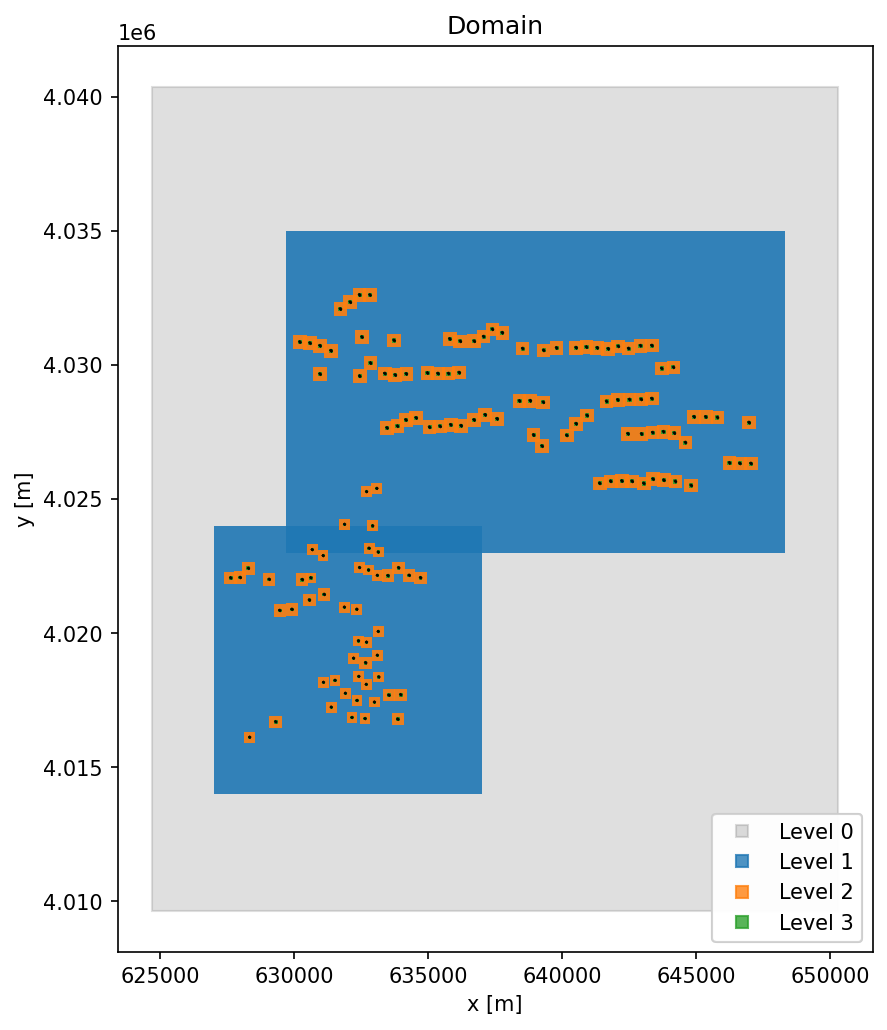

In [21]:
# Plot the domain (total domain)
fig, ax = plt.subplots(figsize=(8,8), facecolor='w', dpi=150)
case.popup_storteddata['plotdomain']['plot_turbines']        = case.listboxpopupwindict['listboxactuator'].getitemlist()
case.popup_storteddata['plotdomain']['plot_refineboxes']     = case.listboxpopupwindict['listboxtagging'].getitemlist()
case.popup_storteddata['plotdomain']['plot_windnortharrows'] = False
case.popup_storteddata['plotdomain']['plot_chooseview']      = 'XY'
case.plotDomain(ax=ax)
ax.axis('scaled')

In [22]:
# Estimate mesh size
case.estimateMeshSize(verbose=False)

ESTIMATED MESH SIZE
   Level       Ncells                      Cell Size
       0    314572800             20.0 x 20.0 x 20.0
       1    145440000             10.0 x 10.0 x 10.0
       2     31368106                5.0 x 5.0 x 5.0
       3     22584991                2.5 x 2.5 x 2.5
  TOTAL:    513965897


### Add metmast/lidar sampling

In [23]:
# Set up averaging

## Surface measurements
metmastpprosetup = case.get_default_postprosetupdict()
metmastpprosetup['postprocessing_setup_name'] = 'surf_'
metmastpprosetup['postprocessing_setup_type'] = 'Sampling'
metmastpprosetup['postprocessing_setup_output_frequency'] =  1
metmastpprosetup['postprocessing_setup_fields']           =  ['velocity', 'temperature', 'tke']
case.add_postprosetup(metmastpprosetup, verbose=True)

## Lidar measurements
metmastpprosetup = case.get_default_postprosetupdict()
metmastpprosetup['postprocessing_setup_name'] = 'lidar_'
metmastpprosetup['postprocessing_setup_type'] = 'Sampling'
metmastpprosetup['postprocessing_setup_output_frequency'] =  1
metmastpprosetup['postprocessing_setup_fields']           =  ['velocity', 'temperature', 'tke']
case.add_postprosetup(metmastpprosetup, verbose=True)

### Lidar measurements
#metmastpprosetup = case.get_default_postprosetupdict()
#metmastpprosetup['postprocessing_setup_name'] = 'tprof_'
#metmastpprosetup['postprocessing_setup_type'] = 'Sampling'
#metmastpprosetup['postprocessing_setup_output_frequency'] =  1
#metmastpprosetup['postprocessing_setup_fields']           =  ['velocity', 'temperature', 'tke']
#case.add_postprosetup(metmastpprosetup, verbose=True)


postprocessing_setup_name: 'surf_'
postprocessing_setup_type: 'Sampling'
postprocessing_setup_output_frequency: 1
postprocessing_setup_fields: ['velocity', 'temperature', 'tke']
postprocessing_setup_derived_fields: None
postprocessing_setup_averaging_window: None
postprocessing_setup_averaging_start_time: None
postprocessing_setup_averaging_stop_time: None
postprocessing_setup_name: 'lidar_'
postprocessing_setup_type: 'Sampling'
postprocessing_setup_output_frequency: 1
postprocessing_setup_fields: ['velocity', 'temperature', 'tke']
postprocessing_setup_derived_fields: None
postprocessing_setup_averaging_window: None
postprocessing_setup_averaging_start_time: None
postprocessing_setup_averaging_stop_time: None


In [24]:
print(case.listboxpopupwindict['listboxsampling'].getitemlist())
print(case.listboxpopupwindict['listboxpostprosetup'].getitemlist())

['Farm_sw1', 'Farm_hh']
['sw_', 'hubheight_', 'surf_', 'lidar_']


In [25]:
# Add surface measurement outputs
for name in ['siteA1', 'siteA2', 'siteA5']:
    sampledict = case.get_default_samplingdict()
    sampledict['sampling_name']     = 'surface_'+name
    sampledict['sampling_outputto'] = 'surf_'
    sampledict['sampling_type']     = 'LineSampler'
    sampledict['sampling_l_num_points'] = 2
    sampledict['sampling_l_start']      = [mdict[name]['utmx'], mdict[name]['utmy'], 4.0]
    sampledict['sampling_l_end']        = [mdict[name]['utmx'], mdict[name]['utmy'], 10.0]
    case.add_sampling(sampledict, verbose=False)
    
for name in ['siteA1', 'siteA2', 'siteB', 'siteE36', 'siteC1a', 'siteH', 'siteG', 'siteGC']:
    sampledict = case.get_default_samplingdict()
    sampledict['sampling_name']     = 'lidar_'+name
    sampledict['sampling_outputto'] = 'lidar_'
    sampledict['sampling_type']     = 'LineSampler'
    sampledict['sampling_l_num_points'] = 95
    sampledict['sampling_l_start']      = [mdict[name]['utmx'], mdict[name]['utmy'], 10.0]
    sampledict['sampling_l_end']        = [mdict[name]['utmx'], mdict[name]['utmy'], 950.0]
    case.add_sampling(sampledict, verbose=False)
    
# Add surface wake measurements
for name in ['siteC1a', 'siteG', 'siteH']:
    sampledict = case.get_default_samplingdict()
    sampledict['sampling_name']     = 'surface_'+name
    sampledict['sampling_outputto'] = 'surf_'
    sampledict['sampling_type']     = 'LineSampler'
    sampledict['sampling_l_num_points'] = 2
    sampledict['sampling_l_start']      = [mdict[name]['utmx'], mdict[name]['utmy'], 4.0]
    sampledict['sampling_l_end']        = [mdict[name]['utmx'], mdict[name]['utmy'], 10.0]
    case.add_sampling(sampledict, verbose=False)
    

In [26]:
outputoptions="outputvars:velocity;tke;temperature outputfreq:10"

#centerx, centery = 637500, 4025000.0
centerx, centery = 639000, 4029000
AFcenterx, AFcentery = 632000, 4018000
## Add E06 Wake sampling
samplingcsv = """
# CSV file should have columns withturbinescsv=
# name, type, upstream, downstream, lateral, below, above, n1, n2, options
name, type, upstream, downstream, lateral, below, above, n1, n2, options
E06wake27,  hubheight, 0, 4000.5, 2540,    0,  none,  11, 11, usedx:{dx} units:meter center:specified centerx:{centerx} centery:{centery} centerz:27   orientation:y outputto:E06wake_z27_ {outputoptions} 
E06wake59,  hubheight, 0, 4000.5, 2540,    0,  none,  11, 11, usedx:{dx} units:meter center:specified centerx:{centerx} centery:{centery} centerz:59   orientation:y outputto:E06wake_z59_ {outputoptions} 
E06wake90,  hubheight, 0, 4000.5, 2540,    0,  none,  11, 11, usedx:{dx} units:meter center:specified centerx:{centerx} centery:{centery} centerz:90.5 orientation:y outputto:E06wake_z90_ {outputoptions} 
E06wake122, hubheight, 0, 4000.5, 2540,    0,  none,  11, 11, usedx:{dx} units:meter center:specified centerx:{centerx} centery:{centery} centerz:122  orientation:y outputto:E06wake_z122_ {outputoptions} 
E06wake154, hubheight, 0, 4000.5, 2540,    0,  none,  11, 11, usedx:{dx} units:meter center:specified centerx:{centerx} centery:{centery} centerz:154  orientation:y outputto:E06wake_z154_ {outputoptions} 
E06wake217, hubheight, 0, 4000.5, 2540,    0,  none,  11, 11, usedx:{dx} units:meter center:specified centerx:{centerx} centery:{centery} centerz:217.5  orientation:y outputto:E06wake_z217_ {outputoptions} 
E06wake281, hubheight, 0, 4000.5, 2540,    0,  none,  11, 11, usedx:{dx} units:meter center:specified centerx:{centerx} centery:{centery} centerz:281  orientation:y outputto:E06wake_z281_ {outputoptions} 
E06wake344, hubheight, 0, 4000.5, 2540,    0,  none,  11, 11, usedx:{dx} units:meter center:specified centerx:{centerx} centery:{centery} centerz:344.5  orientation:y outputto:E06wake_z344_ {outputoptions} 
""".format(outputoptions=outputoptions, dx=12.7, centerx=mdict['turbE06']['utmx'], centery=mdict['turbE06']['utmy'])
#print(samplingcsv)

samplingcsv += """
# CSV file should have columns withturbinescsv=
# name, type, upstream, downstream, lateral, below, above, n1, n2, options
allhh,  hubheight, {up}, {down}, {lateral}, 0,  none,  11, 11, usedx:{dx} units:meter center:specified centerx:{centerx} centery:{centery} centerz:90 orientation:y  wholedomain:1 outputto:all_z90_ {outputoptions} 
hh90,  hubheight, {up}, {down}, {lateral}, 0,  none,  11, 11, usedx:{dx} units:meter center:specified centerx:{centerx} centery:{centery} centerz:90 orientation:y   outputto:farm_z90_ {outputoptions} 
hh153,  hubheight, {up}, {down}, {lateral}, 0,  none,  11, 11, usedx:{dx} units:meter center:specified centerx:{centerx} centery:{centery} centerz:153 orientation:y outputto:farm_z153_ {outputoptions} 
""".format(centerx=centerx, centery=centery, up=6000, down=6000, lateral=9300, dx=200, outputoptions=outputoptions)

samplingcsv += """
# King plains inflow/outflow
KP500, hubheight,  6000,  7000, 10000,  0, none, 0, 0,              usedx:20 units:meter center:specified centerx:{centerx} centery:{centery} centerz:500 outputto:KP_z500hh_  orientation:180.0 {outputoptions}
KP153, hubheight,  6000,  7000, 10000,  0, none, 0, 0,              usedx:20 units:meter center:specified centerx:{centerx} centery:{centery} centerz:153 outputto:KP_z153hh_  orientation:180.0 {outputoptions}
KP090, hubheight,  6000,  7000, 10000,  0, none, 0, 0,              usedx:20 units:meter center:specified centerx:{centerx} centery:{centery} centerz:90 outputto:KP_z090hh_   orientation:180.0 {outputoptions}
KP026, hubheight,  6000,  7000, 10000,  0, none, 0, 0,              usedx:20 units:meter center:specified centerx:{centerx} centery:{centery} centerz:26 outputto:KP_z026hh_   orientation:180.0 {outputoptions}

KP_sideplane1, streamwise, 6000, 7000,  10000,  100, 400, 0, 0,     usedx:20 units:meter center:specified centerx:{centerx} centery:{centery} centerz:100.1 outputto:KP_sideplane1_ noffsets:2 orientation:180.0 {outputoptions}
KP_sideplane2, streamwise, 6000, 7000, -10000,  100, 400, 0, 0,     usedx:20 units:meter center:specified centerx:{centerx} centery:{centery} centerz:100.1 outputto:KP_sideplane2_ noffsets:2 orientation:180.0 {outputoptions}
KP_ioflow1,  rotorplane,   6000, 7000,  10000,  100, 400, 0, 0,     usedx:20 units:meter center:specified centerx:{centerx} centery:{centery} centerz:100.1 outputto:KP_inflow1_    noffsets:4 orientation:180.0 {outputoptions}
""".format(centerx=centerx, centery=centery,outputoptions=outputoptions, inityaw=inityaw)

samplingcsv += """
# Armadillo flats inflow/outflow
AF090,      hubheight,  4000,   8000, 5000,  0, none, 0, 0,      usedx:20 units:meter center:specified centerx:{centerx} centery:{centery} centerz:90 outputto:AF_z090hh_   orientation:180.0 {outputoptions}
AF_ioflow1, rotorplane, 4000,   8000, 5000,  100, 400, 0, 0,     usedx:20 units:meter center:specified centerx:{centerx} centery:{centery} centerz:100.1 outputto:AF_inflow1_    noffsets:4 orientation:180.0 {outputoptions}
AF_sideplane1, streamwise, 4000, 8000,  5000,  100, 400, 0, 0,     usedx:20 units:meter center:specified centerx:{centerx} centery:{centery} centerz:100.1 outputto:AF_sideplane1_ noffsets:2 orientation:180.0 {outputoptions}
AF_sideplane2, streamwise, 4000, 8000, -5000,  100, 400, 0, 0,     usedx:20 units:meter center:specified centerx:{centerx} centery:{centery} centerz:100.1 outputto:AF_sideplane2_ noffsets:2 orientation:180.0 {outputoptions}
""".format(centerx=AFcenterx, centery=AFcentery,outputoptions=outputoptions, inityaw=inityaw)

samplingcsv += """
# CSV file should have columns withturbinescsv=
# name, type, upstream, downstream, lateral, below, above, n1, n2, options
KPturbhh,  hubheight, 1020, 1020,       760,     0,     0,     11, 11, usedx:10 units:meter outputto:KPturbhh_ orientation:nacdir outputvars:velocity   applyto:WIT_USKPL_* {outputoptions}
KPsw,     streamwise, 1020, 1020,       0,       80,    380,   11, 11, usedx:10 units:meter outputto:KPsw_     orientation:nacdir outputvars:velocity    applyto:WIT_USKPL_* {outputoptions}
KProtor,  rotorplane, 1020, 1020,       760,     ,      380,   11, 11, usedx:10 units:meter outputto:KProtor_  orientation:nacdir outputvars:velocity noffsets:8   applyto:WIT_USKPL_* {outputoptions}
""".format(outputoptions=outputoptions)

In [27]:
# heights at 
print(127/4.0*np.array([-2, -1.5, -1, -0.5, 0,0.5,1,1.5,2,2.5,3,3.5,4])+90.5)

[ 27.     42.875  58.75   74.625  90.5   106.375 122.25  138.125 154.
 169.875 185.75  201.625 217.5  ]


In [28]:
# Add H05 scanning lidars (optional)
H05centerx, H05centery = 643049.78, 4025582.41
samplingcsv += """
# CSV file should have columns withturbinescsv=
# name, type, upstream, downstream, lateral, below, above, n1, n2, options
H05wake27,  hubheight, 2000.25, 2000.25, 2540,    0,  none,  11, 11, usedx:{dx} units:meter center:specified centerx:{centerx} centery:{centery} centerz:27    orientation:y outputto:H05wake_z27_ {outputoptions} 
H05wake43,  hubheight, 2000.25, 2000.25, 2540,    0,  none,  11, 11, usedx:{dx} units:meter center:specified centerx:{centerx} centery:{centery} centerz:42.875 orientation:y outputto:H05wake_z43_ {outputoptions} 
H05wake59,  hubheight, 2000.25, 2000.25, 2540,    0,  none,  11, 11, usedx:{dx} units:meter center:specified centerx:{centerx} centery:{centery} centerz:59    orientation:y outputto:H05wake_z59_ {outputoptions} 
H05wake75,  hubheight, 2000.25, 2000.25, 2540,    0,  none,  11, 11, usedx:{dx} units:meter center:specified centerx:{centerx} centery:{centery} centerz:74.625 orientation:y outputto:H05wake_z75_ {outputoptions} 
H05wake90,  hubheight, 2000.25, 2000.25, 2540,    0,  none,  11, 11, usedx:{dx} units:meter center:specified centerx:{centerx} centery:{centery} centerz:90.5  orientation:y outputto:H05wake_z90_ {outputoptions} 
H05wake106, hubheight, 2000.25, 2000.25, 2540,    0,  none,  11, 11, usedx:{dx} units:meter center:specified centerx:{centerx} centery:{centery} centerz:106.375 orientation:y outputto:H05wake_z106_ {outputoptions} 
H05wake122, hubheight, 2000.25, 2000.25, 2540,    0,  none,  11, 11, usedx:{dx} units:meter center:specified centerx:{centerx} centery:{centery} centerz:122       orientation:y outputto:H05wake_z122_ {outputoptions} 
H05wake138, hubheight, 2000.25, 2000.25, 2540,    0,  none,  11, 11, usedx:{dx} units:meter center:specified centerx:{centerx} centery:{centery} centerz:138.125   orientation:y outputto:H05wake_z138_ {outputoptions} 
H05wake154, hubheight, 2000.25, 2000.25, 2540,    0,  none,  11, 11, usedx:{dx} units:meter center:specified centerx:{centerx} centery:{centery} centerz:154       orientation:y outputto:H05wake_z154_ {outputoptions} 
H05wake170, hubheight, 2000.25, 2000.25, 2540,    0,  none,  11, 11, usedx:{dx} units:meter center:specified centerx:{centerx} centery:{centery} centerz:169.875   orientation:y outputto:H05wake_z170_ {outputoptions} 
H05wake186,  hubheight, 2000.25, 2000.25, 2540,    0,  none,  11, 11, usedx:{dx} units:meter center:specified centerx:{centerx} centery:{centery} centerz:185.75   orientation:y outputto:H05wake_z186_ {outputoptions} 
H05wake202,  hubheight, 2000.25, 2000.25, 2540,    0,  none,  11, 11, usedx:{dx} units:meter center:specified centerx:{centerx} centery:{centery} centerz:201.625  orientation:y outputto:H05wake_z202_ {outputoptions} 
H05wake217, hubheight, 2000.25, 2000.25, 2540,    0,  none,  11, 11, usedx:{dx} units:meter center:specified centerx:{centerx} centery:{centery} centerz:217.5 orientation:y outputto:H05wake_z217_ {outputoptions} 
H05wake281, hubheight, 2000.25, 2000.25, 2540,    0,  none,  11, 11, usedx:{dx} units:meter center:specified centerx:{centerx} centery:{centery} centerz:281   orientation:y outputto:H05wake_z281_ {outputoptions} 
H05wake344, hubheight, 2000.25, 2000.25, 2540,    0,  none,  11, 11, usedx:{dx} units:meter center:specified centerx:{centerx} centery:{centery} centerz:344.5 orientation:y outputto:H05wake_z344_ {outputoptions} 
""".format(outputoptions=outputoptions, dx=12.7, centerx=H05centerx, centery=H05centery)
#print(samplingcsv)

In [29]:
case.setAMRWindInput('sampling_csvtextbox', samplingcsv)
case.setAMRWindInput('sampling_deleteprev', False)

case.sampling_createAllProbes(verbose=False)

In [30]:
KPturbhh = [x for x in case.listboxpopupwindict['listboxsampling'].getitemlist() if x.endswith('_KPturbhh') ]
KPsw     = [x for x in case.listboxpopupwindict['listboxsampling'].getitemlist() if x.endswith('_KPsw') ]
KProtor  = [x for x in case.listboxpopupwindict['listboxsampling'].getitemlist() if x.endswith('_KProtor') ]
lidarsam = [x for x in case.listboxpopupwindict['listboxsampling'].getitemlist() if x.startswith('lidar') ]
KPIO     = [x for x in case.listboxpopupwindict['listboxsampling'].getitemlist() if x.startswith('Farm_KP') ]
E06wake  = [x for x in case.listboxpopupwindict['listboxsampling'].getitemlist() if x.startswith('Farm_E06') ]
H05wake  = [x for x in case.listboxpopupwindict['listboxsampling'].getitemlist() if x.startswith('Farm_H05') ]

In [31]:
print(E06wake)
print(H05wake)

['Farm_E06wake27', 'Farm_E06wake59', 'Farm_E06wake90', 'Farm_E06wake122', 'Farm_E06wake154', 'Farm_E06wake217', 'Farm_E06wake281', 'Farm_E06wake344']
['Farm_H05wake27', 'Farm_H05wake43', 'Farm_H05wake59', 'Farm_H05wake75', 'Farm_H05wake90', 'Farm_H05wake106', 'Farm_H05wake122', 'Farm_H05wake138', 'Farm_H05wake154', 'Farm_H05wake170', 'Farm_H05wake186', 'Farm_H05wake202', 'Farm_H05wake217', 'Farm_H05wake281', 'Farm_H05wake344']


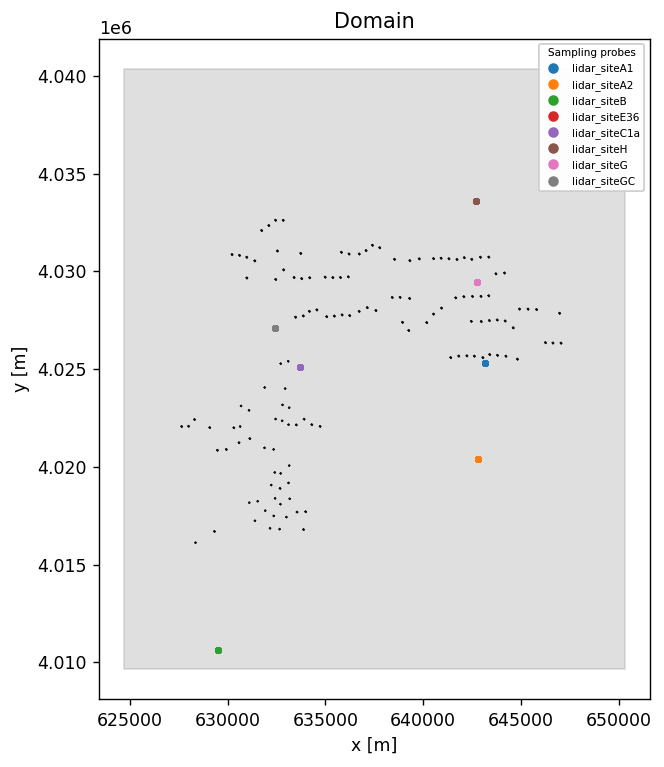

In [32]:
# Plot the domain
fig, ax = plt.subplots(figsize=(7,7), facecolor='w', dpi=125)

# Set any additional items to plot
#case.popup_storteddata['plotdomain']['plot_sampleprobes_style']  = "{'markersize':0.1, 'marker':'.', 'linestyle':'None', }"
#case.popup_storteddata['plotdomain']['plot_sampleprobes_legend'] = "{'title':'Sampling probes', 'fontsize':6, 'loc':'upper right', 'markerscale':6}"


case.popup_storteddata['plotdomain']['plot_sampleprobes_legend'] = "{'title':'Sampling probes', 'fontsize':6, 'loc':'upper right', 'markerscale':2}"
#case.popup_storteddata['plotdomain']['plot_sampleprobes']    = KPturbhh[-10:] + KPsw[-10:] + KProtor[-10:] 
#case.popup_storteddata['plotdomain']['plot_sampleprobes']    = E06wake
case.popup_storteddata['plotdomain']['plot_sampleprobes_style']  = "{'markersize':5, 'marker':'.', 'linestyle':'None', }"
case.popup_storteddata['plotdomain']['plot_sampleprobes']    = lidarsam #case.listboxpopupwindict['listboxsampling'].getitemlist() 

#case.popup_storteddata['plotdomain']['plot_sampleprobes_style']  = "{'markersize':0.5, 'marker':'.', 'linestyle':'None', }"
#case.popup_storteddata['plotdomain']['plot_sampleprobes']    = KPturbhh #lidarsam #case.listboxpopupwindict['listboxsampling'].getitemlist() 
#case.popup_storteddata['plotdomain']['plot_sampleprobes_legend'] = "{}"

case.popup_storteddata['plotdomain']['plot_chooseview']      = 'XY'
case.popup_storteddata['plotdomain']['plot_refineboxes']     = [] 
case.popup_storteddata['plotdomain']['plot_turbines']        = case.listboxpopupwindict['listboxactuator'].getitemlist()
case.popup_storteddata['plotdomain']['plot_windnortharrows'] = False
case.plotDomain(ax=ax, verbose=False)

ax.set_aspect('equal')
#ax.set_xlim([ 640000,  650000])
#ax.set_ylim([4025000, 4035000])

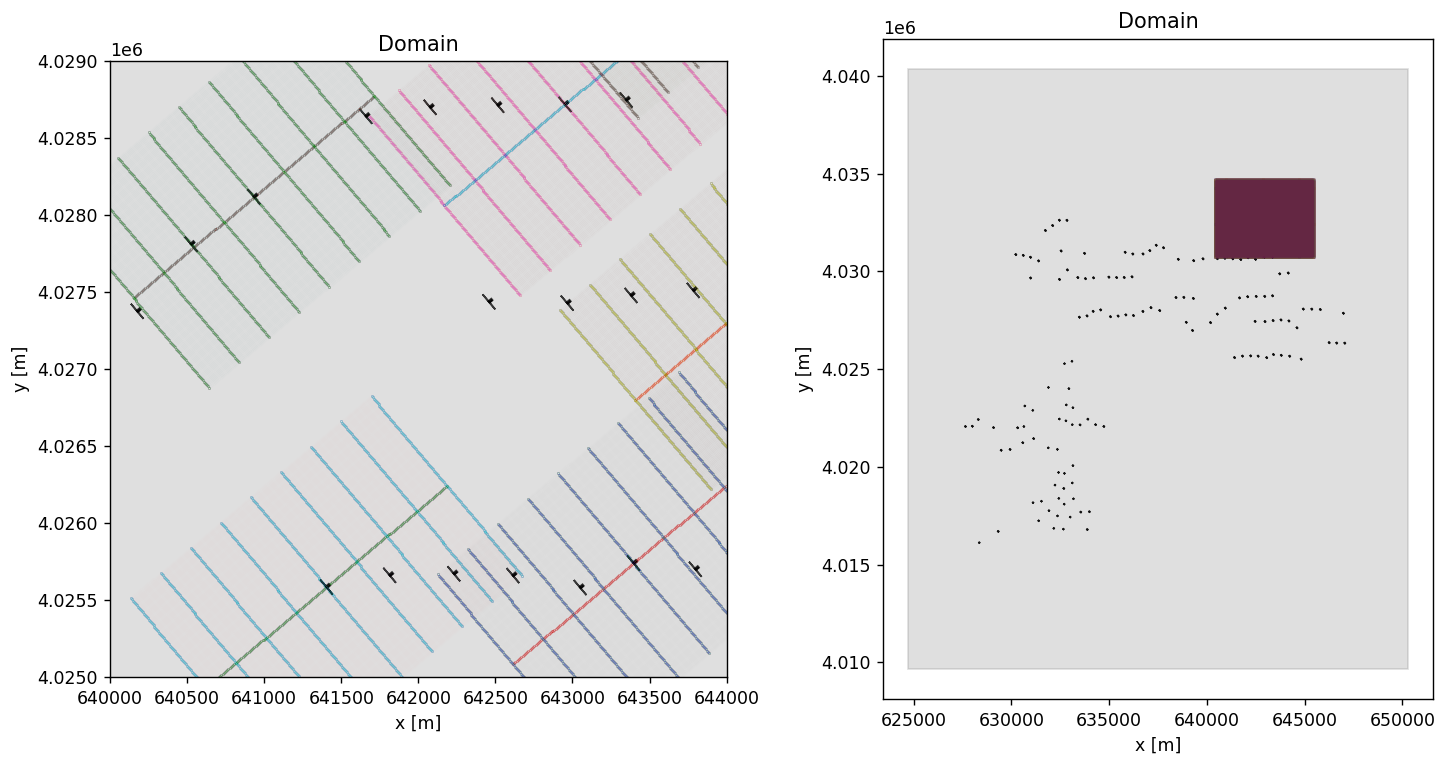

In [33]:
# Plot the domain
fig, axs = plt.subplots(1,2, figsize=(14,7), facecolor='w', dpi=125)
case.popup_storteddata['plotdomain']['plot_sampleprobes_style']  = "{'markersize':0.01, 'marker':'.', 'linestyle':'None', }"
case.popup_storteddata['plotdomain']['plot_sampleprobes']    = KPsw[::5]+KProtor[::5]+KPturbhh[::5] 
case.popup_storteddata['plotdomain']['plot_sampleprobes_legend'] = "{}"
case.plotDomain(ax=axs[0], verbose=False)

case.popup_storteddata['plotdomain']['plot_sampleprobes_style']  = "{'markersize':0.01, 'marker':'.', 'linestyle':'None', }"
case.popup_storteddata['plotdomain']['plot_sampleprobes']        = E06wake #lidarsam #case.listboxpopupwindict['listboxsampling'].getitemlist() 
case.popup_storteddata['plotdomain']['plot_sampleprobes_legend'] = "{}"
case.plotDomain(ax=axs[1], verbose=False)


axs[0].set_xlim([640000, 644000])
axs[0].set_ylim([4.025E6, 4.029E6])

axs[0].set_aspect('equal')
axs[1].set_aspect('equal')

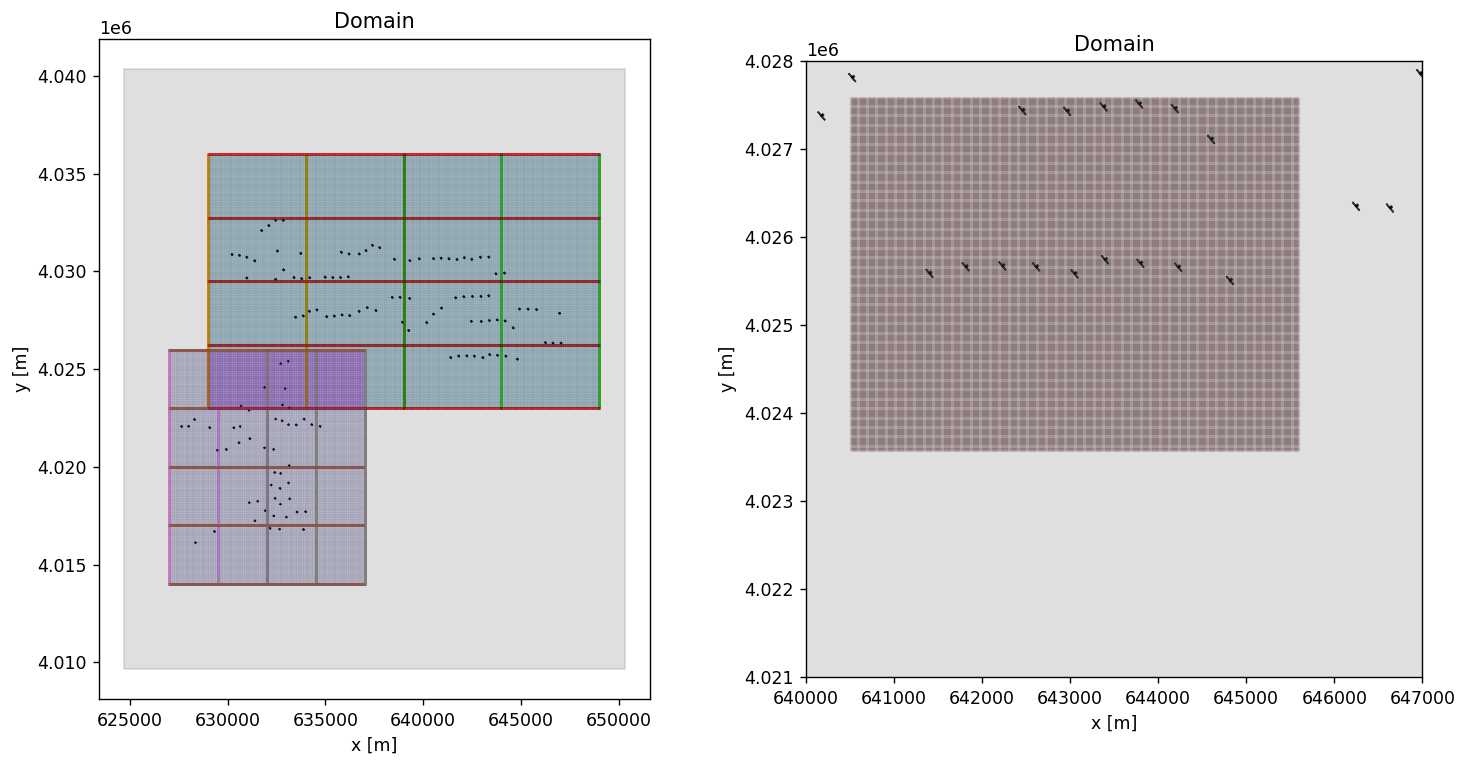

In [34]:
# Plot the domain
fig, axs = plt.subplots(1,2, figsize=(14,7), facecolor='w', dpi=125)
case.popup_storteddata['plotdomain']['plot_sampleprobes_style']  = "{'markersize':0.01, 'marker':'.', 'linestyle':'None', }"
case.popup_storteddata['plotdomain']['plot_sampleprobes']    = ['Farm_KP090', 'Farm_KP_sideplane1', 'Farm_KP_sideplane2', 'Farm_KP_ioflow1',
                                                                'Farm_AF090', 'Farm_AF_ioflow1', 'Farm_AF_sideplane1', 'Farm_AF_sideplane2',]
case.popup_storteddata['plotdomain']['plot_sampleprobes_legend'] = "{}"
case.plotDomain(ax=axs[0], verbose=False)

case.popup_storteddata['plotdomain']['plot_sampleprobes_style']  = "{'markersize':0.01, 'marker':'.', 'linestyle':'None', }"
case.popup_storteddata['plotdomain']['plot_sampleprobes']    = H05wake #lidarsam #case.listboxpopupwindict['listboxsampling'].getitemlist() 
case.popup_storteddata['plotdomain']['plot_sampleprobes_legend'] = "{}"
case.plotDomain(ax=axs[1], verbose=False)

axs[1].set_xlim([640000, 647000])
axs[1].set_ylim([4.021E6, 4.028E6])

axs[0].set_aspect('equal')
axs[1].set_aspect('equal')

In [35]:
# Write the input file
print(case.writeAMRWindInput(inputfile))

# --- Simulation time control parameters ---
time.stop_time                           = 14400.0             # Max (simulated) time to evolve [s]
time.max_step                            = -1                  
time.fixed_dt                            = 0.1                 # Fixed timestep size (in seconds). If negative, then time.cfl is used
time.checkpoint_interval                 = 1800                
time.checkpoint_start                    = 12600               
incflo.physics                           = ABL Actuator        # List of physics models to include in simulation.
incflo.verbose                           = 3                   
io.check_file                            = chk                 
io.restart_file                          = /gpfs/lcheung/AWAKEN/Benchmark1/Phase2/MMC/inoutflow.MMC_BM2_BigPrecursor/chk12600
incflo.use_godunov                       = true                
incflo.godunov_type                      = weno_z              
turbulence.model                 